# $\textbf{Part 1. Predicting LFSR States Using Feedforward Neural Networks}$
$\text{Author: Ryan Burns}$

#### $\textbf{Linear Feedback Shift Registers (LFSRs)}$
$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

#### $\textbf{Prediction of LFSR State }n + 1\textbf{ Given State }n$
$\text{Suppose we are given an arbitrary LFSR feedback polynomial and we build a representation of the LFSR in software. Using this LFSR, and}$
$\text{assuming the feedback polynomial is primitive in a polynomial ring of fixed degree over }GF(2)\text{, we can generate a maximum-length binary}$
$\text{sequence which has well-documented correlation properties which make them desirable building blocks for stream ciphers or spread-spectrum}$
$\text{codes, to name a few examples. On their own, LFSRs do not afford any real cryptographic protection, being famously susceptible to correlation}$
$\text{attacks. Speaking of attacks, our goal in this notebook is to demonstrate that we can use a }\textit{very}\text{ simple neural network to predict LFSR behavior.}$
$\text{Specifically, we posit that a two-layer (i.e., single hidden-layer) feedforward neural network can readily predict the state-evolution of an arbitrary}$
$\text{LFSR. For simplicity, we constrain this network to have a very specific architecture. Its input layer consists of a fixed-length binary vector that}$
$\text{represents the LFSR state vector at some time index (epoch) }n\text{. We use the ground truth register state at index / epoch }n + 1\text{ to train a the network}$
$\text{to develop a latent representation of the finite field recursion. Both layers of the network are sigmoid connections, representing soft approximations}$
$\text{of boolean gates, outputing activations in the unit interval, }[0,1].\text{ These layers assume no bias terms, only weighted combinations of inputs. For}$
$\text{an LFSR of recursion-order/polynomial degree }deg\text{, the first (and only) hidden layer consists a total of }deg + 2\text{ weighted sigmoidal activations.}$
$\text{The output layer consists of the }deg\text{ total activations predicting }deg\text{ total bits in the LFSR state vector at epoch }n + 1\text{, for all }n\text{. These binary}$
$\text{activations are trained against the true LFSR state vectors at these indices }n + 1\text{ using a binary cross-entropy error function. The population of}$
$\text{observations are the }deg\text{-length LFSR states across all epochs in one full }m\text{-sequence period / cycle. The labels for the error function are the }$
$deg\text{-length state vector values upon 1 iteration of the LFSR recursion, per observation.}$

#### $\textbf{Part 1 of This Notebook}$
$\text{Part 1 of this notebook prototypes a feedforward binary (bias-less) neural network using Keras, training it as described above using RMSprop. The}$
$\text{model is given too few degrees of freedom to completely memorize the bits, so it must learn a latent representation of the underlying finite field}$
$\text{mathematics defining the recurrence relation. After sufficiently many training epochs, the model has been tested to converge to 100}\%\text{ accuracy}$
$\text{for all degree-10 primitive polynomials in the file 10.txt. Primitive polynomials defining }m\text{-sequences for other polynomial degrees are available}$
$\text{for download at the following site: }\textit{https://users.ece.cmu.edu/~koopman/lfsr/index.html}\text{. Future efforts may build this proof-of-concept out to}$
$\text{higher degree recursions and more complicated kinds of stream ciphers. For now, we demonstrate that a relatively shallow binary network is}$
$\text{sufficiently powerful to "crack" (i.e., predict) an LFSR's underlying recursive state vector mapping.}$

$\text{In addition to training the network, we animate the results in a plot which depicts the time-evolution of the LFSR recursion and the neural}$
$\text{network's state predictions. In addition, options are provided for plotting the correlation properties of the }m\text{-sequence training data and the Keras}$
$\text{model metrics vs training epoch, respectively. Documentation and source code for all the functions below can be found in this repo's modules.}$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange, max, roll

# Galois / LFSR utilities
from galois_tools import *
from m_sequence_viz import *
from lfsr_network_viz import *
from ml_utils import *

# Plotting functionality
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

# Tensorflow/Keras functionality
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

### $\textbf{Plotting Macro (Requires IPython)}$

In [2]:
%matplotlib notebook

### $\textbf{Specify LFSR & Neural Net Parameters}$

In [3]:
###########################
# Specify LFSR parameters #
###########################

# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

# Primitive polynomial choice
p = 16 # (index in catalog)

###############################
# Network training parameters #
###############################

# Number of RMSprop training epochs
N_epoch = 20000

# Batch size equal to m-sequence length
N_batch = 2**deg - 1

# Learning rate for RMSprop
learning_rate = 0.001

#########################
# Behavioral parameters #
#########################

# Turn ON/OFF correlation plot
plot_correlations = True

# Turn ON/OFF true vs. predicted mask plot
plot_prediction_masks = True

# Turn ON/OFF tapped vs. normal LFSR state observations
enable_tapped_register_obs = False

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [4]:
#############################################################
# Load coeff. of primitive polynomials over GF(2) from file #
#############################################################

# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg,
    path='./primitive_polynomials/')

###########################################################
# Generate linear feedback shift registers w/ polynomials #
###########################################################

# Define a bank of LFSRs - 1 per polynomial in the catalog
LFSRs = [LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))]

### $\textbf{Visualize Auto- & Cross-Correlations of Two m-Sequences}$

<IPython.core.display.Javascript object>


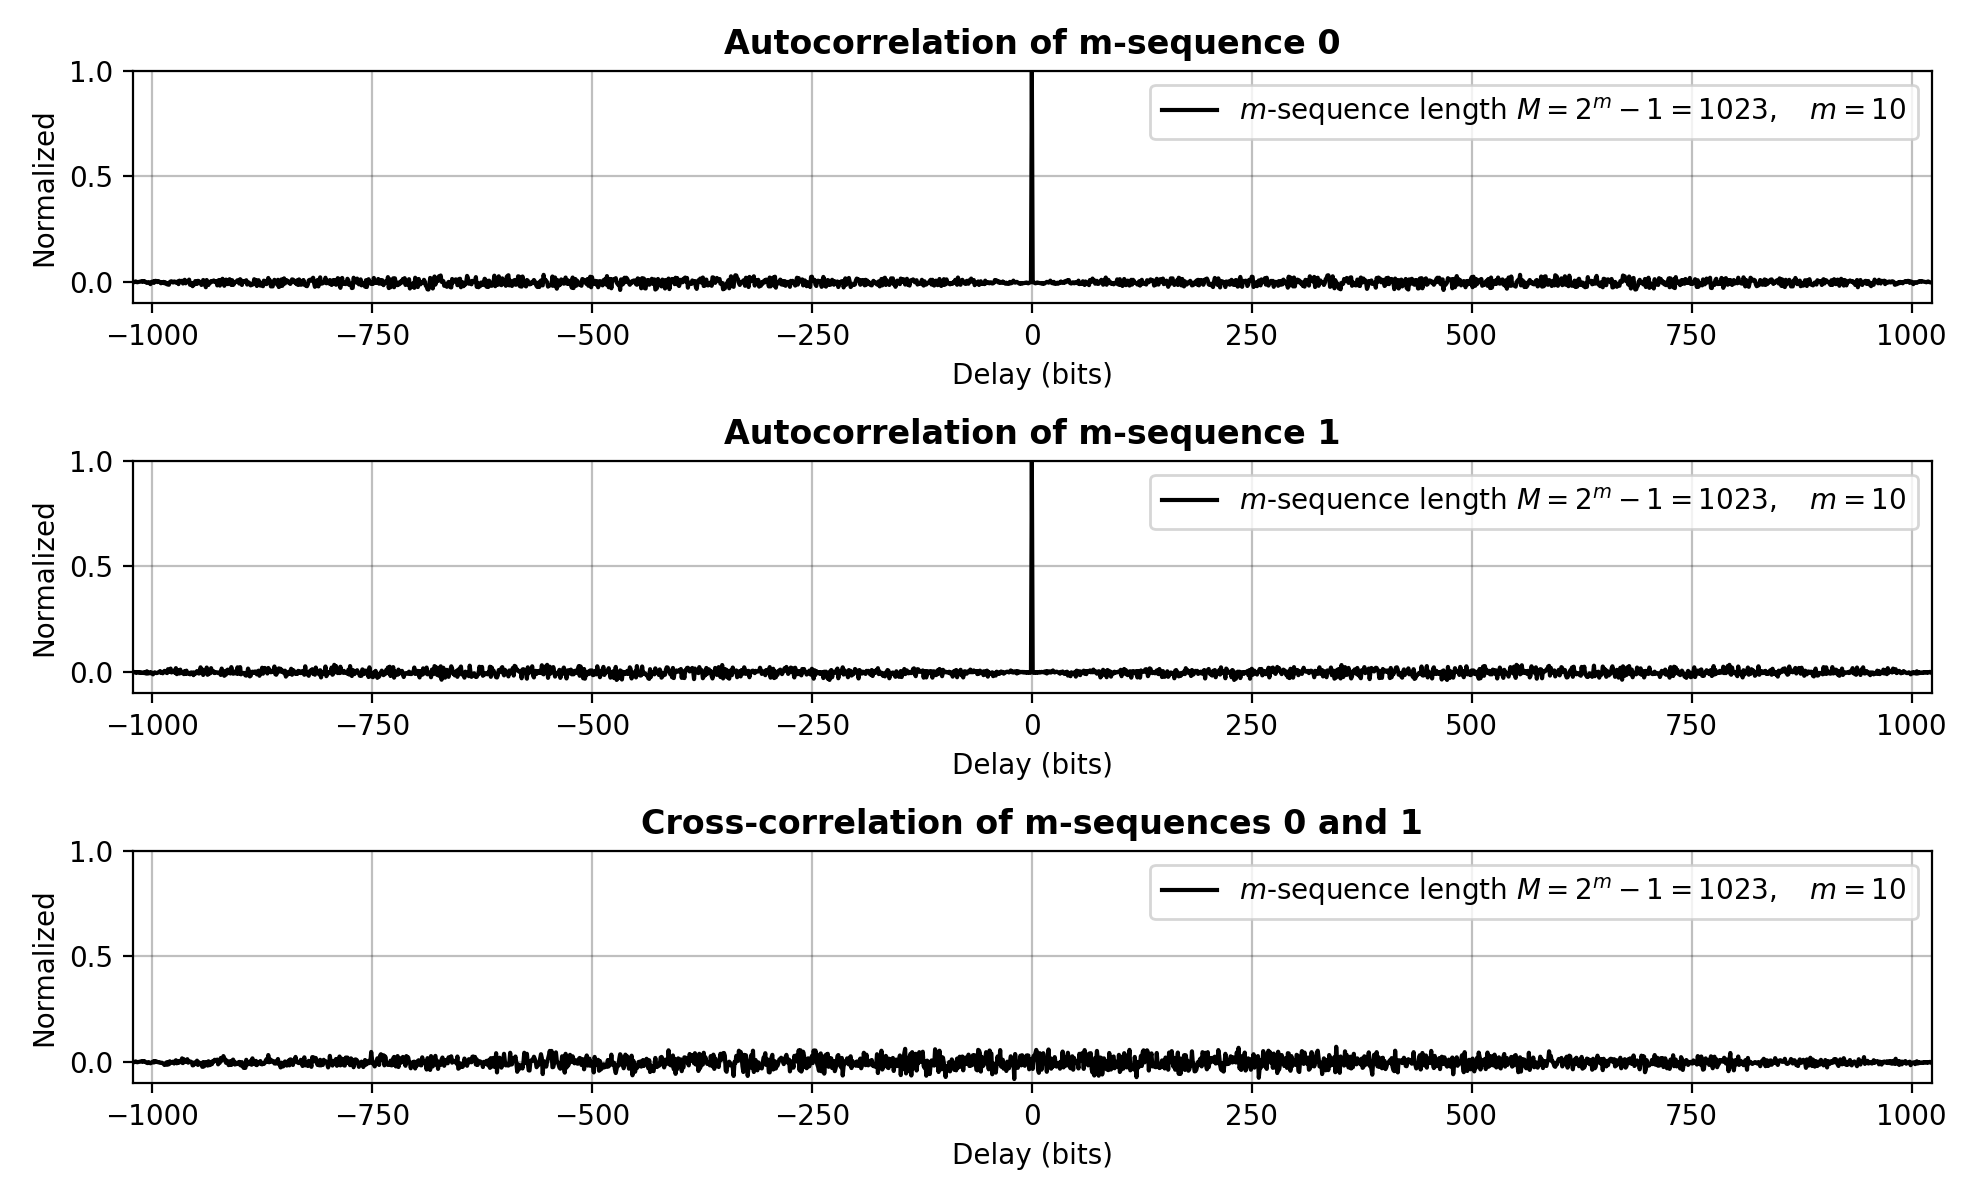

In [5]:
# Optional correlation plot...
if plot_correlations:

    ##################################################
    # Generate m-sequences for each LFSR in the bank #
    ##################################################

    # Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
    m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

    # Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
    algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

    ###################################################
    # Visualize correlation properties of m-sequences #
    ###################################################

    # Plot the correlations of the 1st 2 m-sequences generated above
    correlation_example(m_sequence0=algebraic_m_sequences[p,:], 
        m_sequence1=algebraic_m_sequences[p + 1,:],  deg=deg)

### $\textbf{Form Observations of }n^{\text{th}}\textbf{ LFSR State for Prediction of }(n + 1)^\text{st}\textbf{ State, for }n=0,1,2,\ldots$

In [6]:
#######################################################
# Observation vectors by streaming LFSR tapped at 0x1 #
#######################################################

# Tap LFSR or simply use state sequence?...
if enable_tapped_register_obs:

    # Observations formed by tapping a p'th LFSR from a list of options
    X, Y = form_tap_based_obs(LFSRs, p, deg)

#######################################################
# Observation vectors: LFSR state vs. epoch / index n #
#######################################################

# Use state sequence...
else:

    # Observations of 1 period of p'th LFSR in list
    X, Y = register_state_observations(LFSRs[p])

### $\textbf{Define Feedforward Binary Neural Network}$

In [7]:
# Use Keras to define feedforward binary neural network, with
# two sigmoidal layers (without bias terms) for estimation of
# the LFSR state vector at epoch n + 1 from the state at epoch n
model = feedforward_lfsr_predictor(deg=deg, num_hidden=(deg + 2),
    learning_rate=learning_rate, print_summary=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden (Dense)               (None, 12)                120       
_________________________________________________________________
output (Dense)               (None, 10)                120       
Total params: 240
Trainable params: 240
Non-trainable params: 0
_________________________________________________________________


### $\textbf{Fit Sigmoid Model to Predict Register State }n + 1\textbf{ from State }n$

In [8]:
# Model training (save history)
model_history = model.fit(
    
    # Input dataset
    x=X, # state vectot "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=0, # (use everything)
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False);

Train on 1023 samples
Epoch 1/20000
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.7578 - true_positives: 1809.0000 - true_negatives: 3221.0000 - false_positives: 1889.0000 - false_negatives: 3311.0000
Epoch 2/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.7545 - true_positives: 1863.0000 - true_negatives: 3173.0000 - false_positives: 1937.0000 - false_negatives: 3257.0000
Epoch 3/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.7521 - true_positives: 1899.0000 - true_negatives: 3136.0000 - false_positives: 1974.0000 - false_negatives: 3221.0000
Epoch 4/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.7503 - true_positives: 1924.0000 - true_negatives: 3116.0000 - false_positives: 1994.0000 - false_negatives: 3196.0000
Epoch 5/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.7486 - true_positives: 1947.0000 - true_negatives: 3105.0000 - false_positives: 2005.00

Epoch 42/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7182 - true_positives: 1998.0000 - true_negatives: 3045.0000 - false_positives: 2065.0000 - false_negatives: 3122.0000
Epoch 43/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7176 - true_positives: 1996.0000 - true_negatives: 3049.0000 - false_positives: 2061.0000 - false_negatives: 3124.0000
Epoch 44/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7170 - true_positives: 2000.0000 - true_negatives: 3053.0000 - false_positives: 2057.0000 - false_negatives: 3120.0000
Epoch 45/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7164 - true_positives: 2003.0000 - true_negatives: 3056.0000 - false_positives: 2054.0000 - false_negatives: 3117.0000
Epoch 46/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.7158 - true_positives: 1999.0000 - true_negatives: 3061.0000 - false_positives: 2049.0000 - false_negati

Epoch 83/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6982 - true_positives: 2172.0000 - true_negatives: 3233.0000 - false_positives: 1877.0000 - false_negatives: 2948.0000
Epoch 84/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6978 - true_positives: 2177.0000 - true_negatives: 3242.0000 - false_positives: 1868.0000 - false_negatives: 2943.0000
Epoch 85/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6974 - true_positives: 2180.0000 - true_negatives: 3243.0000 - false_positives: 1867.0000 - false_negatives: 2940.0000
Epoch 86/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6971 - true_positives: 2180.0000 - true_negatives: 3252.0000 - false_positives: 1858.0000 - false_negatives: 2940.0000
Epoch 87/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6967 - true_positives: 2187.0000 - true_negatives: 3261.0000 - false_positives: 1849.0000 - false_negati

Epoch 124/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6847 - true_positives: 2333.0000 - true_negatives: 3527.0000 - false_positives: 1583.0000 - false_negatives: 2787.0000
Epoch 125/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6844 - true_positives: 2333.0000 - true_negatives: 3545.0000 - false_positives: 1565.0000 - false_negatives: 2787.0000
Epoch 126/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6841 - true_positives: 2348.0000 - true_negatives: 3540.0000 - false_positives: 1570.0000 - false_negatives: 2772.0000
Epoch 127/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6838 - true_positives: 2354.0000 - true_negatives: 3556.0000 - false_positives: 1554.0000 - false_negatives: 2766.0000
Epoch 128/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6836 - true_positives: 2360.0000 - true_negatives: 3551.0000 - false_positives: 1559.0000 - false_n

Epoch 165/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6742 - true_positives: 2703.0000 - true_negatives: 3639.0000 - false_positives: 1471.0000 - false_negatives: 2417.0000
Epoch 166/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6740 - true_positives: 2736.0000 - true_negatives: 3599.0000 - false_positives: 1511.0000 - false_negatives: 2384.0000
Epoch 167/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6737 - true_positives: 2722.0000 - true_negatives: 3637.0000 - false_positives: 1473.0000 - false_negatives: 2398.0000
Epoch 168/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6735 - true_positives: 2760.0000 - true_negatives: 3603.0000 - false_positives: 1507.0000 - false_negatives: 2360.0000
Epoch 169/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6732 - true_positives: 2747.0000 - true_negatives: 3636.0000 - false_positives: 1474.0000 - false_n

Epoch 206/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6642 - true_positives: 3167.0000 - true_negatives: 3602.0000 - false_positives: 1508.0000 - false_negatives: 1953.0000
Epoch 207/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6639 - true_positives: 3131.0000 - true_negatives: 3647.0000 - false_positives: 1463.0000 - false_negatives: 1989.0000
Epoch 208/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6637 - true_positives: 3187.0000 - true_negatives: 3602.0000 - false_positives: 1508.0000 - false_negatives: 1933.0000
Epoch 209/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6634 - true_positives: 3150.0000 - true_negatives: 3644.0000 - false_positives: 1466.0000 - false_negatives: 1970.0000
Epoch 210/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6632 - true_positives: 3200.0000 - true_negatives: 3598.0000 - false_positives: 1512.0000 - false_n

Epoch 247/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6539 - true_positives: 3414.0000 - true_negatives: 3635.0000 - false_positives: 1475.0000 - false_negatives: 1706.0000
Epoch 248/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6536 - true_positives: 3461.0000 - true_negatives: 3594.0000 - false_positives: 1516.0000 - false_negatives: 1659.0000
Epoch 249/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6534 - true_positives: 3431.0000 - true_negatives: 3633.0000 - false_positives: 1477.0000 - false_negatives: 1689.0000
Epoch 250/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6531 - true_positives: 3473.0000 - true_negatives: 3595.0000 - false_positives: 1515.0000 - false_negatives: 1647.0000
Epoch 251/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6529 - true_positives: 3440.0000 - true_negatives: 3632.0000 - false_positives: 1478.0000 - false_n

Epoch 288/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6432 - true_positives: 3687.0000 - true_negatives: 3651.0000 - false_positives: 1459.0000 - false_negatives: 1433.0000
Epoch 289/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6429 - true_positives: 3648.0000 - true_negatives: 3694.0000 - false_positives: 1416.0000 - false_negatives: 1472.0000
Epoch 290/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6427 - true_positives: 3698.0000 - true_negatives: 3656.0000 - false_positives: 1454.0000 - false_negatives: 1422.0000
Epoch 291/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6424 - true_positives: 3655.0000 - true_negatives: 3705.0000 - false_positives: 1405.0000 - false_negatives: 1465.0000
Epoch 292/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6421 - true_positives: 3708.0000 - true_negatives: 3660.0000 - false_positives: 1450.0000 - false_n

Epoch 329/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6321 - true_positives: 3755.0000 - true_negatives: 3756.0000 - false_positives: 1354.0000 - false_negatives: 1365.0000
Epoch 330/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6318 - true_positives: 3789.0000 - true_negatives: 3709.0000 - false_positives: 1401.0000 - false_negatives: 1331.0000
Epoch 331/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6315 - true_positives: 3756.0000 - true_negatives: 3756.0000 - false_positives: 1354.0000 - false_negatives: 1364.0000
Epoch 332/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6312 - true_positives: 3794.0000 - true_negatives: 3709.0000 - false_positives: 1401.0000 - false_negatives: 1326.0000
Epoch 333/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6309 - true_positives: 3759.0000 - true_negatives: 3761.0000 - false_positives: 1349.0000 - false_n

Epoch 370/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6204 - true_positives: 3861.0000 - true_negatives: 3767.0000 - false_positives: 1343.0000 - false_negatives: 1259.0000
Epoch 371/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6201 - true_positives: 3812.0000 - true_negatives: 3821.0000 - false_positives: 1289.0000 - false_negatives: 1308.0000
Epoch 372/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6198 - true_positives: 3862.0000 - true_negatives: 3769.0000 - false_positives: 1341.0000 - false_negatives: 1258.0000
Epoch 373/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6195 - true_positives: 3821.0000 - true_negatives: 3824.0000 - false_positives: 1286.0000 - false_negatives: 1299.0000
Epoch 374/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6192 - true_positives: 3868.0000 - true_negatives: 3768.0000 - false_positives: 1342.0000 - false_n

Epoch 411/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6083 - true_positives: 3871.0000 - true_negatives: 3887.0000 - false_positives: 1223.0000 - false_negatives: 1249.0000
Epoch 412/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6080 - true_positives: 3932.0000 - true_negatives: 3827.0000 - false_positives: 1283.0000 - false_negatives: 1188.0000
Epoch 413/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.6077 - true_positives: 3870.0000 - true_negatives: 3888.0000 - false_positives: 1222.0000 - false_negatives: 1250.0000
Epoch 414/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6074 - true_positives: 3935.0000 - true_negatives: 3822.0000 - false_positives: 1288.0000 - false_negatives: 1185.0000
Epoch 415/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6071 - true_positives: 3869.0000 - true_negatives: 3892.0000 - false_positives: 1218.0000 - false_n

Epoch 452/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5958 - true_positives: 3977.0000 - true_negatives: 3842.0000 - false_positives: 1268.0000 - false_negatives: 1143.0000
Epoch 453/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5955 - true_positives: 3895.0000 - true_negatives: 3918.0000 - false_positives: 1192.0000 - false_negatives: 1225.0000
Epoch 454/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5952 - true_positives: 3979.0000 - true_negatives: 3849.0000 - false_positives: 1261.0000 - false_negatives: 1141.0000
Epoch 455/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5949 - true_positives: 3895.0000 - true_negatives: 3923.0000 - false_positives: 1187.0000 - false_negatives: 1225.0000
Epoch 456/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5946 - true_positives: 3982.0000 - true_negatives: 3850.0000 - false_positives: 1260.0000 - false_n

Epoch 493/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5831 - true_positives: 3907.0000 - true_negatives: 3959.0000 - false_positives: 1151.0000 - false_negatives: 1213.0000
Epoch 494/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5828 - true_positives: 4002.0000 - true_negatives: 3869.0000 - false_positives: 1241.0000 - false_negatives: 1118.0000
Epoch 495/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5825 - true_positives: 3908.0000 - true_negatives: 3961.0000 - false_positives: 1149.0000 - false_negatives: 1212.0000
Epoch 496/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5822 - true_positives: 4000.0000 - true_negatives: 3871.0000 - false_positives: 1239.0000 - false_negatives: 1120.0000
Epoch 497/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5819 - true_positives: 3908.0000 - true_negatives: 3963.0000 - false_positives: 1147.0000 - false_n

Epoch 534/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5703 - true_positives: 4030.0000 - true_negatives: 3905.0000 - false_positives: 1205.0000 - false_negatives: 1090.0000
Epoch 535/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5700 - true_positives: 3923.0000 - true_negatives: 4004.0000 - false_positives: 1106.0000 - false_negatives: 1197.0000
Epoch 536/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5697 - true_positives: 4034.0000 - true_negatives: 3912.0000 - false_positives: 1198.0000 - false_negatives: 1086.0000
Epoch 537/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5694 - true_positives: 3920.0000 - true_negatives: 4009.0000 - false_positives: 1101.0000 - false_negatives: 1200.0000
Epoch 538/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5691 - true_positives: 4033.0000 - true_negatives: 3915.0000 - false_positives: 1195.0000 - false_n

Epoch 575/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5575 - true_positives: 3956.0000 - true_negatives: 4042.0000 - false_positives: 1068.0000 - false_negatives: 1164.0000
Epoch 576/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5572 - true_positives: 4041.0000 - true_negatives: 3933.0000 - false_positives: 1177.0000 - false_negatives: 1079.0000
Epoch 577/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5569 - true_positives: 3957.0000 - true_negatives: 4044.0000 - false_positives: 1066.0000 - false_negatives: 1163.0000
Epoch 578/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5566 - true_positives: 4042.0000 - true_negatives: 3935.0000 - false_positives: 1175.0000 - false_negatives: 1078.0000
Epoch 579/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5563 - true_positives: 3959.0000 - true_negatives: 4047.0000 - false_positives: 1063.0000 - false_n

Epoch 616/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5449 - true_positives: 4059.0000 - true_negatives: 3947.0000 - false_positives: 1163.0000 - false_negatives: 1061.0000
Epoch 617/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5446 - true_positives: 3964.0000 - true_negatives: 4053.0000 - false_positives: 1057.0000 - false_negatives: 1156.0000
Epoch 618/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5443 - true_positives: 4059.0000 - true_negatives: 3947.0000 - false_positives: 1163.0000 - false_negatives: 1061.0000
Epoch 619/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5440 - true_positives: 3968.0000 - true_negatives: 4055.0000 - false_positives: 1055.0000 - false_negatives: 1152.0000
Epoch 620/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5437 - true_positives: 4056.0000 - true_negatives: 3948.0000 - false_positives: 1162.0000 - false_n

Epoch 657/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5325 - true_positives: 3967.0000 - true_negatives: 4070.0000 - false_positives: 1040.0000 - false_negatives: 1153.0000
Epoch 658/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5322 - true_positives: 4078.0000 - true_negatives: 3958.0000 - false_positives: 1152.0000 - false_negatives: 1042.0000
Epoch 659/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5319 - true_positives: 3969.0000 - true_negatives: 4072.0000 - false_positives: 1038.0000 - false_negatives: 1151.0000
Epoch 660/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5316 - true_positives: 4076.0000 - true_negatives: 3958.0000 - false_positives: 1152.0000 - false_negatives: 1044.0000
Epoch 661/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5313 - true_positives: 3973.0000 - true_negatives: 4073.0000 - false_positives: 1037.0000 - false_n

Epoch 698/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5204 - true_positives: 4081.0000 - true_negatives: 3965.0000 - false_positives: 1145.0000 - false_negatives: 1039.0000
Epoch 699/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5202 - true_positives: 3980.0000 - true_negatives: 4088.0000 - false_positives: 1022.0000 - false_negatives: 1140.0000
Epoch 700/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5199 - true_positives: 4081.0000 - true_negatives: 3963.0000 - false_positives: 1147.0000 - false_negatives: 1039.0000
Epoch 701/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5196 - true_positives: 3981.0000 - true_negatives: 4092.0000 - false_positives: 1018.0000 - false_negatives: 1139.0000
Epoch 702/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5193 - true_positives: 4083.0000 - true_negatives: 3967.0000 - false_positives: 1143.0000 - false_n

Epoch 739/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5087 - true_positives: 4009.0000 - true_negatives: 4103.0000 - false_positives: 1007.0000 - false_negatives: 1111.0000
Epoch 740/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5084 - true_positives: 4093.0000 - true_negatives: 3980.0000 - false_positives: 1130.0000 - false_negatives: 1027.0000
Epoch 741/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5082 - true_positives: 4011.0000 - true_negatives: 4107.0000 - false_positives: 1003.0000 - false_negatives: 1109.0000
Epoch 742/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5079 - true_positives: 4090.0000 - true_negatives: 3980.0000 - false_positives: 1130.0000 - false_negatives: 1030.0000
Epoch 743/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.5076 - true_positives: 4011.0000 - true_negatives: 4115.0000 - false_positives: 995.0000 - false_ne

Epoch 780/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4974 - true_positives: 4108.0000 - true_negatives: 4000.0000 - false_positives: 1110.0000 - false_negatives: 1012.0000
Epoch 781/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4971 - true_positives: 4023.0000 - true_negatives: 4126.0000 - false_positives: 984.0000 - false_negatives: 1097.0000
Epoch 782/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4968 - true_positives: 4111.0000 - true_negatives: 3997.0000 - false_positives: 1113.0000 - false_negatives: 1009.0000
Epoch 783/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4966 - true_positives: 4027.0000 - true_negatives: 4133.0000 - false_positives: 977.0000 - false_negatives: 1093.0000
Epoch 784/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4963 - true_positives: 4111.0000 - true_negatives: 3996.0000 - false_positives: 1114.0000 - false_neg

Epoch 821/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4865 - true_positives: 4054.0000 - true_negatives: 4151.0000 - false_positives: 959.0000 - false_negatives: 1066.0000
Epoch 822/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4862 - true_positives: 4115.0000 - true_negatives: 4025.0000 - false_positives: 1085.0000 - false_negatives: 1005.0000
Epoch 823/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4859 - true_positives: 4056.0000 - true_negatives: 4151.0000 - false_positives: 959.0000 - false_negatives: 1064.0000
Epoch 824/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4857 - true_positives: 4115.0000 - true_negatives: 4027.0000 - false_positives: 1083.0000 - false_negatives: 1005.0000
Epoch 825/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4854 - true_positives: 4057.0000 - true_negatives: 4150.0000 - false_positives: 960.0000 - false_nega

Epoch 862/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4759 - true_positives: 4128.0000 - true_negatives: 4068.0000 - false_positives: 1042.0000 - false_negatives: 992.0000
Epoch 863/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4756 - true_positives: 4071.0000 - true_negatives: 4178.0000 - false_positives: 932.0000 - false_negatives: 1049.0000
Epoch 864/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4754 - true_positives: 4129.0000 - true_negatives: 4070.0000 - false_positives: 1040.0000 - false_negatives: 991.0000
Epoch 865/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4751 - true_positives: 4072.0000 - true_negatives: 4180.0000 - false_positives: 930.0000 - false_negatives: 1048.0000
Epoch 866/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4749 - true_positives: 4129.0000 - true_negatives: 4074.0000 - false_positives: 1036.0000 - false_negat

Epoch 903/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4657 - true_positives: 4093.0000 - true_negatives: 4192.0000 - false_positives: 918.0000 - false_negatives: 1027.0000
Epoch 904/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4654 - true_positives: 4141.0000 - true_negatives: 4112.0000 - false_positives: 998.0000 - false_negatives: 979.0000
Epoch 905/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4652 - true_positives: 4098.0000 - true_negatives: 4195.0000 - false_positives: 915.0000 - false_negatives: 1022.0000
Epoch 906/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4650 - true_positives: 4144.0000 - true_negatives: 4110.0000 - false_positives: 1000.0000 - false_negatives: 976.0000
Epoch 907/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4647 - true_positives: 4099.0000 - true_negatives: 4193.0000 - false_positives: 917.0000 - false_negativ

Epoch 944/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4558 - true_positives: 4179.0000 - true_negatives: 4148.0000 - false_positives: 962.0000 - false_negatives: 941.0000
Epoch 945/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4555 - true_positives: 4133.0000 - true_negatives: 4213.0000 - false_positives: 897.0000 - false_negatives: 987.0000
Epoch 946/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4553 - true_positives: 4178.0000 - true_negatives: 4148.0000 - false_positives: 962.0000 - false_negatives: 942.0000
Epoch 947/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4551 - true_positives: 4136.0000 - true_negatives: 4211.0000 - false_positives: 899.0000 - false_negatives: 984.0000
Epoch 948/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4548 - true_positives: 4179.0000 - true_negatives: 4149.0000 - false_positives: 961.0000 - false_negatives:

Epoch 985/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4462 - true_positives: 4143.0000 - true_negatives: 4226.0000 - false_positives: 884.0000 - false_negatives: 977.0000
Epoch 986/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4460 - true_positives: 4187.0000 - true_negatives: 4169.0000 - false_positives: 941.0000 - false_negatives: 933.0000
Epoch 987/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4457 - true_positives: 4138.0000 - true_negatives: 4228.0000 - false_positives: 882.0000 - false_negatives: 982.0000
Epoch 988/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4455 - true_positives: 4191.0000 - true_negatives: 4166.0000 - false_positives: 944.0000 - false_negatives: 929.0000
Epoch 989/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4453 - true_positives: 4137.0000 - true_negatives: 4228.0000 - false_positives: 882.0000 - false_negatives:

Epoch 1026/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4369 - true_positives: 4191.0000 - true_negatives: 4192.0000 - false_positives: 918.0000 - false_negatives: 929.0000
Epoch 1027/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4366 - true_positives: 4141.0000 - true_negatives: 4252.0000 - false_positives: 858.0000 - false_negatives: 979.0000
Epoch 1028/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4364 - true_positives: 4192.0000 - true_negatives: 4195.0000 - false_positives: 915.0000 - false_negatives: 928.0000
Epoch 1029/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4362 - true_positives: 4142.0000 - true_negatives: 4253.0000 - false_positives: 857.0000 - false_negatives: 978.0000
Epoch 1030/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4360 - true_positives: 4194.0000 - true_negatives: 4199.0000 - false_positives: 911.0000 - false_negat

Epoch 1067/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4278 - true_positives: 4170.0000 - true_negatives: 4291.0000 - false_positives: 819.0000 - false_negatives: 950.0000
Epoch 1068/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4276 - true_positives: 4205.0000 - true_negatives: 4238.0000 - false_positives: 872.0000 - false_negatives: 915.0000
Epoch 1069/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4274 - true_positives: 4173.0000 - true_negatives: 4289.0000 - false_positives: 821.0000 - false_negatives: 947.0000
Epoch 1070/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4271 - true_positives: 4205.0000 - true_negatives: 4243.0000 - false_positives: 867.0000 - false_negatives: 915.0000
Epoch 1071/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4269 - true_positives: 4175.0000 - true_negatives: 4287.0000 - false_positives: 823.0000 - false_negat

Epoch 1108/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4189 - true_positives: 4239.0000 - true_negatives: 4261.0000 - false_positives: 849.0000 - false_negatives: 881.0000
Epoch 1109/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4187 - true_positives: 4208.0000 - true_negatives: 4299.0000 - false_positives: 811.0000 - false_negatives: 912.0000
Epoch 1110/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4185 - true_positives: 4242.0000 - true_negatives: 4263.0000 - false_positives: 847.0000 - false_negatives: 878.0000
Epoch 1111/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4183 - true_positives: 4212.0000 - true_negatives: 4298.0000 - false_positives: 812.0000 - false_negatives: 908.0000
Epoch 1112/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4181 - true_positives: 4243.0000 - true_negatives: 4261.0000 - false_positives: 849.0000 - false_negat

Epoch 1149/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4103 - true_positives: 4233.0000 - true_negatives: 4316.0000 - false_positives: 794.0000 - false_negatives: 887.0000
Epoch 1150/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4100 - true_positives: 4261.0000 - true_negatives: 4275.0000 - false_positives: 835.0000 - false_negatives: 859.0000
Epoch 1151/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4098 - true_positives: 4232.0000 - true_negatives: 4316.0000 - false_positives: 794.0000 - false_negatives: 888.0000
Epoch 1152/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4096 - true_positives: 4260.0000 - true_negatives: 4275.0000 - false_positives: 835.0000 - false_negatives: 860.0000
Epoch 1153/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4094 - true_positives: 4231.0000 - true_negatives: 4314.0000 - false_positives: 796.0000 - false_negat

Epoch 1190/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4017 - true_positives: 4266.0000 - true_negatives: 4307.0000 - false_positives: 803.0000 - false_negatives: 854.0000
Epoch 1191/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.4015 - true_positives: 4242.0000 - true_negatives: 4330.0000 - false_positives: 780.0000 - false_negatives: 878.0000
Epoch 1192/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4013 - true_positives: 4267.0000 - true_negatives: 4308.0000 - false_positives: 802.0000 - false_negatives: 853.0000
Epoch 1193/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4011 - true_positives: 4245.0000 - true_negatives: 4330.0000 - false_positives: 780.0000 - false_negatives: 875.0000
Epoch 1194/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.4009 - true_positives: 4274.0000 - true_negatives: 4307.0000 - false_positives: 803.0000 - false_negat

Epoch 1231/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3934 - true_positives: 4251.0000 - true_negatives: 4352.0000 - false_positives: 758.0000 - false_negatives: 869.0000
Epoch 1232/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3932 - true_positives: 4282.0000 - true_negatives: 4320.0000 - false_positives: 790.0000 - false_negatives: 838.0000
Epoch 1233/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3930 - true_positives: 4255.0000 - true_negatives: 4351.0000 - false_positives: 759.0000 - false_negatives: 865.0000
Epoch 1234/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3928 - true_positives: 4286.0000 - true_negatives: 4321.0000 - false_positives: 789.0000 - false_negatives: 834.0000
Epoch 1235/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3926 - true_positives: 4255.0000 - true_negatives: 4352.0000 - false_positives: 758.0000 - false_negat

Epoch 1272/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3853 - true_positives: 4293.0000 - true_negatives: 4337.0000 - false_positives: 773.0000 - false_negatives: 827.0000
Epoch 1273/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3851 - true_positives: 4261.0000 - true_negatives: 4361.0000 - false_positives: 749.0000 - false_negatives: 859.0000
Epoch 1274/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3849 - true_positives: 4295.0000 - true_negatives: 4335.0000 - false_positives: 775.0000 - false_negatives: 825.0000
Epoch 1275/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3847 - true_positives: 4264.0000 - true_negatives: 4359.0000 - false_positives: 751.0000 - false_negatives: 856.0000
Epoch 1276/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3845 - true_positives: 4298.0000 - true_negatives: 4336.0000 - false_positives: 774.0000 - false_negat

Epoch 1313/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3774 - true_positives: 4287.0000 - true_negatives: 4363.0000 - false_positives: 747.0000 - false_negatives: 833.0000
Epoch 1314/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3772 - true_positives: 4314.0000 - true_negatives: 4336.0000 - false_positives: 774.0000 - false_negatives: 806.0000
Epoch 1315/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3770 - true_positives: 4287.0000 - true_negatives: 4364.0000 - false_positives: 746.0000 - false_negatives: 833.0000
Epoch 1316/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3768 - true_positives: 4315.0000 - true_negatives: 4334.0000 - false_positives: 776.0000 - false_negatives: 805.0000
Epoch 1317/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3766 - true_positives: 4284.0000 - true_negatives: 4364.0000 - false_positives: 746.0000 - false_negat

Epoch 1354/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3697 - true_positives: 4323.0000 - true_negatives: 4352.0000 - false_positives: 758.0000 - false_negatives: 797.0000
Epoch 1355/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3695 - true_positives: 4303.0000 - true_negatives: 4377.0000 - false_positives: 733.0000 - false_negatives: 817.0000
Epoch 1356/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3693 - true_positives: 4322.0000 - true_negatives: 4354.0000 - false_positives: 756.0000 - false_negatives: 798.0000
Epoch 1357/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3691 - true_positives: 4307.0000 - true_negatives: 4376.0000 - false_positives: 734.0000 - false_negatives: 813.0000
Epoch 1358/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3689 - true_positives: 4324.0000 - true_negatives: 4357.0000 - false_positives: 753.0000 - false_negat

Epoch 1395/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3622 - true_positives: 4318.0000 - true_negatives: 4383.0000 - false_positives: 727.0000 - false_negatives: 802.0000
Epoch 1396/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3620 - true_positives: 4333.0000 - true_negatives: 4361.0000 - false_positives: 749.0000 - false_negatives: 787.0000
Epoch 1397/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3619 - true_positives: 4320.0000 - true_negatives: 4382.0000 - false_positives: 728.0000 - false_negatives: 800.0000
Epoch 1398/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3617 - true_positives: 4334.0000 - true_negatives: 4362.0000 - false_positives: 748.0000 - false_negatives: 786.0000
Epoch 1399/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3615 - true_positives: 4322.0000 - true_negatives: 4382.0000 - false_positives: 728.0000 - false_negat

Epoch 1436/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3550 - true_positives: 4345.0000 - true_negatives: 4368.0000 - false_positives: 742.0000 - false_negatives: 775.0000
Epoch 1437/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3548 - true_positives: 4330.0000 - true_negatives: 4393.0000 - false_positives: 717.0000 - false_negatives: 790.0000
Epoch 1438/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3547 - true_positives: 4345.0000 - true_negatives: 4369.0000 - false_positives: 741.0000 - false_negatives: 775.0000
Epoch 1439/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3545 - true_positives: 4330.0000 - true_negatives: 4391.0000 - false_positives: 719.0000 - false_negatives: 790.0000
Epoch 1440/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3543 - true_positives: 4344.0000 - true_negatives: 4369.0000 - false_positives: 741.0000 - false_negat

Epoch 1477/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3481 - true_positives: 4337.0000 - true_negatives: 4398.0000 - false_positives: 712.0000 - false_negatives: 783.0000
Epoch 1478/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3479 - true_positives: 4349.0000 - true_negatives: 4377.0000 - false_positives: 733.0000 - false_negatives: 771.0000
Epoch 1479/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3477 - true_positives: 4337.0000 - true_negatives: 4397.0000 - false_positives: 713.0000 - false_negatives: 783.0000
Epoch 1480/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3476 - true_positives: 4349.0000 - true_negatives: 4377.0000 - false_positives: 733.0000 - false_negatives: 771.0000
Epoch 1481/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3474 - true_positives: 4336.0000 - true_negatives: 4398.0000 - false_positives: 712.0000 - false_negat

Epoch 1518/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3414 - true_positives: 4356.0000 - true_negatives: 4373.0000 - false_positives: 737.0000 - false_negatives: 764.0000
Epoch 1519/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3412 - true_positives: 4336.0000 - true_negatives: 4402.0000 - false_positives: 708.0000 - false_negatives: 784.0000
Epoch 1520/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3411 - true_positives: 4356.0000 - true_negatives: 4377.0000 - false_positives: 733.0000 - false_negatives: 764.0000
Epoch 1521/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3409 - true_positives: 4338.0000 - true_negatives: 4402.0000 - false_positives: 708.0000 - false_negatives: 782.0000
Epoch 1522/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3408 - true_positives: 4357.0000 - true_negatives: 4378.0000 - false_positives: 732.0000 - false_negat

Epoch 1559/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3350 - true_positives: 4340.0000 - true_negatives: 4410.0000 - false_positives: 700.0000 - false_negatives: 780.0000
Epoch 1560/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3349 - true_positives: 4361.0000 - true_negatives: 4389.0000 - false_positives: 721.0000 - false_negatives: 759.0000
Epoch 1561/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3347 - true_positives: 4342.0000 - true_negatives: 4409.0000 - false_positives: 701.0000 - false_negatives: 778.0000
Epoch 1562/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3346 - true_positives: 4362.0000 - true_negatives: 4390.0000 - false_positives: 720.0000 - false_negatives: 758.0000
Epoch 1563/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3344 - true_positives: 4341.0000 - true_negatives: 4410.0000 - false_positives: 700.0000 - false_negat

Epoch 1600/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3289 - true_positives: 4375.0000 - true_negatives: 4398.0000 - false_positives: 712.0000 - false_negatives: 745.0000
Epoch 1601/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3288 - true_positives: 4352.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negatives: 768.0000
Epoch 1602/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3286 - true_positives: 4377.0000 - true_negatives: 4399.0000 - false_positives: 711.0000 - false_negatives: 743.0000
Epoch 1603/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3285 - true_positives: 4351.0000 - true_negatives: 4425.0000 - false_positives: 685.0000 - false_negatives: 769.0000
Epoch 1604/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3283 - true_positives: 4379.0000 - true_negatives: 4398.0000 - false_positives: 712.0000 - false_negat

Epoch 1641/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3231 - true_positives: 4359.0000 - true_negatives: 4424.0000 - false_positives: 686.0000 - false_negatives: 761.0000
Epoch 1642/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3230 - true_positives: 4383.0000 - true_negatives: 4401.0000 - false_positives: 709.0000 - false_negatives: 737.0000
Epoch 1643/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3228 - true_positives: 4362.0000 - true_negatives: 4422.0000 - false_positives: 688.0000 - false_negatives: 758.0000
Epoch 1644/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3227 - true_positives: 4382.0000 - true_negatives: 4402.0000 - false_positives: 708.0000 - false_negatives: 738.0000
Epoch 1645/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3225 - true_positives: 4363.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negat

Epoch 1682/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3176 - true_positives: 4392.0000 - true_negatives: 4397.0000 - false_positives: 713.0000 - false_negatives: 728.0000
Epoch 1683/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3174 - true_positives: 4365.0000 - true_negatives: 4429.0000 - false_positives: 681.0000 - false_negatives: 755.0000
Epoch 1684/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3173 - true_positives: 4393.0000 - true_negatives: 4397.0000 - false_positives: 713.0000 - false_negatives: 727.0000
Epoch 1685/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3172 - true_positives: 4365.0000 - true_negatives: 4428.0000 - false_positives: 682.0000 - false_negatives: 755.0000
Epoch 1686/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3170 - true_positives: 4394.0000 - true_negatives: 4397.0000 - false_positives: 713.0000 - false_negat

Epoch 1723/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3123 - true_positives: 4371.0000 - true_negatives: 4428.0000 - false_positives: 682.0000 - false_negatives: 749.0000
Epoch 1724/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3122 - true_positives: 4396.0000 - true_negatives: 4409.0000 - false_positives: 701.0000 - false_negatives: 724.0000
Epoch 1725/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3121 - true_positives: 4370.0000 - true_negatives: 4428.0000 - false_positives: 682.0000 - false_negatives: 750.0000
Epoch 1726/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3119 - true_positives: 4399.0000 - true_negatives: 4406.0000 - false_positives: 704.0000 - false_negatives: 721.0000
Epoch 1727/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3118 - true_positives: 4368.0000 - true_negatives: 4429.0000 - false_positives: 681.0000 - false_negat

Epoch 1764/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3073 - true_positives: 4402.0000 - true_negatives: 4408.0000 - false_positives: 702.0000 - false_negatives: 718.0000
Epoch 1765/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3072 - true_positives: 4378.0000 - true_negatives: 4433.0000 - false_positives: 677.0000 - false_negatives: 742.0000
Epoch 1766/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3071 - true_positives: 4400.0000 - true_negatives: 4409.0000 - false_positives: 701.0000 - false_negatives: 720.0000
Epoch 1767/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3070 - true_positives: 4380.0000 - true_negatives: 4432.0000 - false_positives: 678.0000 - false_negatives: 740.0000
Epoch 1768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3069 - true_positives: 4397.0000 - true_negatives: 4410.0000 - false_positives: 700.0000 - false_negat

Epoch 1805/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3026 - true_positives: 4379.0000 - true_negatives: 4433.0000 - false_positives: 677.0000 - false_negatives: 741.0000
Epoch 1806/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3025 - true_positives: 4403.0000 - true_negatives: 4400.0000 - false_positives: 710.0000 - false_negatives: 717.0000
Epoch 1807/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3024 - true_positives: 4382.0000 - true_negatives: 4431.0000 - false_positives: 679.0000 - false_negatives: 738.0000
Epoch 1808/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.3023 - true_positives: 4402.0000 - true_negatives: 4400.0000 - false_positives: 710.0000 - false_negatives: 718.0000
Epoch 1809/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.3022 - true_positives: 4382.0000 - true_negatives: 4432.0000 - false_positives: 678.0000 - false_negat

Epoch 1846/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2982 - true_positives: 4407.0000 - true_negatives: 4396.0000 - false_positives: 714.0000 - false_negatives: 713.0000
Epoch 1847/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2980 - true_positives: 4373.0000 - true_negatives: 4432.0000 - false_positives: 678.0000 - false_negatives: 747.0000
Epoch 1848/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2979 - true_positives: 4407.0000 - true_negatives: 4398.0000 - false_positives: 712.0000 - false_negatives: 713.0000
Epoch 1849/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2978 - true_positives: 4374.0000 - true_negatives: 4431.0000 - false_positives: 679.0000 - false_negatives: 746.0000
Epoch 1850/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2977 - true_positives: 4403.0000 - true_negatives: 4401.0000 - false_positives: 709.0000 - false_negat

Epoch 1887/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2939 - true_positives: 4379.0000 - true_negatives: 4424.0000 - false_positives: 686.0000 - false_negatives: 741.0000
Epoch 1888/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2938 - true_positives: 4401.0000 - true_negatives: 4399.0000 - false_positives: 711.0000 - false_negatives: 719.0000
Epoch 1889/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2937 - true_positives: 4378.0000 - true_negatives: 4424.0000 - false_positives: 686.0000 - false_negatives: 742.0000
Epoch 1890/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2936 - true_positives: 4401.0000 - true_negatives: 4399.0000 - false_positives: 711.0000 - false_negatives: 719.0000
Epoch 1891/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2935 - true_positives: 4378.0000 - true_negatives: 4424.0000 - false_positives: 686.0000 - false_negat

Epoch 1928/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2900 - true_positives: 4406.0000 - true_negatives: 4400.0000 - false_positives: 710.0000 - false_negatives: 714.0000
Epoch 1929/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2899 - true_positives: 4378.0000 - true_negatives: 4420.0000 - false_positives: 690.0000 - false_negatives: 742.0000
Epoch 1930/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2898 - true_positives: 4408.0000 - true_negatives: 4400.0000 - false_positives: 710.0000 - false_negatives: 712.0000
Epoch 1931/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2897 - true_positives: 4377.0000 - true_negatives: 4420.0000 - false_positives: 690.0000 - false_negatives: 743.0000
Epoch 1932/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2896 - true_positives: 4409.0000 - true_negatives: 4399.0000 - false_positives: 711.0000 - false_negat

Epoch 1969/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2862 - true_positives: 4383.0000 - true_negatives: 4426.0000 - false_positives: 684.0000 - false_negatives: 737.0000
Epoch 1970/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2861 - true_positives: 4408.0000 - true_negatives: 4397.0000 - false_positives: 713.0000 - false_negatives: 712.0000
Epoch 1971/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2860 - true_positives: 4385.0000 - true_negatives: 4425.0000 - false_positives: 685.0000 - false_negatives: 735.0000
Epoch 1972/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2859 - true_positives: 4409.0000 - true_negatives: 4400.0000 - false_positives: 710.0000 - false_negatives: 711.0000
Epoch 1973/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2858 - true_positives: 4386.0000 - true_negatives: 4425.0000 - false_positives: 685.0000 - false_negat

Epoch 2010/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2826 - true_positives: 4413.0000 - true_negatives: 4406.0000 - false_positives: 704.0000 - false_negatives: 707.0000
Epoch 2011/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2825 - true_positives: 4387.0000 - true_negatives: 4422.0000 - false_positives: 688.0000 - false_negatives: 733.0000
Epoch 2012/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2825 - true_positives: 4413.0000 - true_negatives: 4406.0000 - false_positives: 704.0000 - false_negatives: 707.0000
Epoch 2013/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2824 - true_positives: 4388.0000 - true_negatives: 4422.0000 - false_positives: 688.0000 - false_negatives: 732.0000
Epoch 2014/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2823 - true_positives: 4410.0000 - true_negatives: 4407.0000 - false_positives: 703.0000 - false_negat

Epoch 2051/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2793 - true_positives: 4385.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negatives: 735.0000
Epoch 2052/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2792 - true_positives: 4411.0000 - true_negatives: 4399.0000 - false_positives: 711.0000 - false_negatives: 709.0000
Epoch 2053/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2791 - true_positives: 4385.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negatives: 735.0000
Epoch 2054/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2790 - true_positives: 4410.0000 - true_negatives: 4399.0000 - false_positives: 711.0000 - false_negatives: 710.0000
Epoch 2055/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2789 - true_positives: 4386.0000 - true_negatives: 4421.0000 - false_positives: 689.0000 - false_negat

Epoch 2092/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2761 - true_positives: 4407.0000 - true_negatives: 4400.0000 - false_positives: 710.0000 - false_negatives: 713.0000
Epoch 2093/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2760 - true_positives: 4379.0000 - true_negatives: 4422.0000 - false_positives: 688.0000 - false_negatives: 741.0000
Epoch 2094/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2759 - true_positives: 4406.0000 - true_negatives: 4405.0000 - false_positives: 705.0000 - false_negatives: 714.0000
Epoch 2095/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2759 - true_positives: 4379.0000 - true_negatives: 4421.0000 - false_positives: 689.0000 - false_negatives: 741.0000
Epoch 2096/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2758 - true_positives: 4405.0000 - true_negatives: 4406.0000 - false_positives: 704.0000 - false_negat

Epoch 2133/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2731 - true_positives: 4381.0000 - true_negatives: 4421.0000 - false_positives: 689.0000 - false_negatives: 739.0000
Epoch 2134/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2730 - true_positives: 4405.0000 - true_negatives: 4407.0000 - false_positives: 703.0000 - false_negatives: 715.0000
Epoch 2135/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2729 - true_positives: 4381.0000 - true_negatives: 4422.0000 - false_positives: 688.0000 - false_negatives: 739.0000
Epoch 2136/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2728 - true_positives: 4404.0000 - true_negatives: 4408.0000 - false_positives: 702.0000 - false_negatives: 716.0000
Epoch 2137/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2728 - true_positives: 4381.0000 - true_negatives: 4421.0000 - false_positives: 689.0000 - false_negat

Epoch 2174/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2702 - true_positives: 4397.0000 - true_negatives: 4410.0000 - false_positives: 700.0000 - false_negatives: 723.0000
Epoch 2175/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2701 - true_positives: 4378.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negatives: 742.0000
Epoch 2176/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2701 - true_positives: 4396.0000 - true_negatives: 4410.0000 - false_positives: 700.0000 - false_negatives: 724.0000
Epoch 2177/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2700 - true_positives: 4378.0000 - true_negatives: 4423.0000 - false_positives: 687.0000 - false_negatives: 742.0000
Epoch 2178/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2699 - true_positives: 4395.0000 - true_negatives: 4411.0000 - false_positives: 699.0000 - false_negat

Epoch 2215/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2675 - true_positives: 4375.0000 - true_negatives: 4418.0000 - false_positives: 692.0000 - false_negatives: 745.0000
Epoch 2216/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2674 - true_positives: 4399.0000 - true_negatives: 4407.0000 - false_positives: 703.0000 - false_negatives: 721.0000
Epoch 2217/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2674 - true_positives: 4373.0000 - true_negatives: 4421.0000 - false_positives: 689.0000 - false_negatives: 747.0000
Epoch 2218/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2673 - true_positives: 4400.0000 - true_negatives: 4405.0000 - false_positives: 705.0000 - false_negatives: 720.0000
Epoch 2219/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2672 - true_positives: 4370.0000 - true_negatives: 4422.0000 - false_positives: 688.0000 - false_negat

Epoch 2256/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2649 - true_positives: 4393.0000 - true_negatives: 4407.0000 - false_positives: 703.0000 - false_negatives: 727.0000
Epoch 2257/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2649 - true_positives: 4372.0000 - true_negatives: 4420.0000 - false_positives: 690.0000 - false_negatives: 748.0000
Epoch 2258/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2648 - true_positives: 4391.0000 - true_negatives: 4405.0000 - false_positives: 705.0000 - false_negatives: 729.0000
Epoch 2259/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2647 - true_positives: 4372.0000 - true_negatives: 4421.0000 - false_positives: 689.0000 - false_negatives: 748.0000
Epoch 2260/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2647 - true_positives: 4394.0000 - true_negatives: 4405.0000 - false_positives: 705.0000 - false_negat

Epoch 2297/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2625 - true_positives: 4372.0000 - true_negatives: 4424.0000 - false_positives: 686.0000 - false_negatives: 748.0000
Epoch 2298/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2624 - true_positives: 4397.0000 - true_negatives: 4403.0000 - false_positives: 707.0000 - false_negatives: 723.0000
Epoch 2299/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2624 - true_positives: 4372.0000 - true_negatives: 4424.0000 - false_positives: 686.0000 - false_negatives: 748.0000
Epoch 2300/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2623 - true_positives: 4397.0000 - true_negatives: 4403.0000 - false_positives: 707.0000 - false_negatives: 723.0000
Epoch 2301/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2623 - true_positives: 4373.0000 - true_negatives: 4425.0000 - false_positives: 685.0000 - false_negat

Epoch 2338/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2602 - true_positives: 4395.0000 - true_negatives: 4401.0000 - false_positives: 709.0000 - false_negatives: 725.0000
Epoch 2339/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2601 - true_positives: 4370.0000 - true_negatives: 4429.0000 - false_positives: 681.0000 - false_negatives: 750.0000
Epoch 2340/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2601 - true_positives: 4396.0000 - true_negatives: 4401.0000 - false_positives: 709.0000 - false_negatives: 724.0000
Epoch 2341/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2600 - true_positives: 4370.0000 - true_negatives: 4429.0000 - false_positives: 681.0000 - false_negatives: 750.0000
Epoch 2342/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2600 - true_positives: 4398.0000 - true_negatives: 4402.0000 - false_positives: 708.0000 - false_negat

Epoch 2379/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2580 - true_positives: 4368.0000 - true_negatives: 4433.0000 - false_positives: 677.0000 - false_negatives: 752.0000
Epoch 2380/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2579 - true_positives: 4397.0000 - true_negatives: 4407.0000 - false_positives: 703.0000 - false_negatives: 723.0000
Epoch 2381/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2579 - true_positives: 4369.0000 - true_negatives: 4434.0000 - false_positives: 676.0000 - false_negatives: 751.0000
Epoch 2382/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2578 - true_positives: 4397.0000 - true_negatives: 4406.0000 - false_positives: 704.0000 - false_negatives: 723.0000
Epoch 2383/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2578 - true_positives: 4369.0000 - true_negatives: 4434.0000 - false_positives: 676.0000 - false_negat

Epoch 2420/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2559 - true_positives: 4393.0000 - true_negatives: 4414.0000 - false_positives: 696.0000 - false_negatives: 727.0000
Epoch 2421/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2559 - true_positives: 4371.0000 - true_negatives: 4441.0000 - false_positives: 669.0000 - false_negatives: 749.0000
Epoch 2422/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2558 - true_positives: 4393.0000 - true_negatives: 4414.0000 - false_positives: 696.0000 - false_negatives: 727.0000
Epoch 2423/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2558 - true_positives: 4368.0000 - true_negatives: 4443.0000 - false_positives: 667.0000 - false_negatives: 752.0000
Epoch 2424/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2557 - true_positives: 4393.0000 - true_negatives: 4414.0000 - false_positives: 696.0000 - false_negat

Epoch 2461/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2539 - true_positives: 4364.0000 - true_negatives: 4444.0000 - false_positives: 666.0000 - false_negatives: 756.0000
Epoch 2462/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2539 - true_positives: 4396.0000 - true_negatives: 4418.0000 - false_positives: 692.0000 - false_negatives: 724.0000
Epoch 2463/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2538 - true_positives: 4364.0000 - true_negatives: 4444.0000 - false_positives: 666.0000 - false_negatives: 756.0000
Epoch 2464/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2538 - true_positives: 4393.0000 - true_negatives: 4418.0000 - false_positives: 692.0000 - false_negatives: 727.0000
Epoch 2465/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2537 - true_positives: 4364.0000 - true_negatives: 4444.0000 - false_positives: 666.0000 - false_negat

Epoch 2502/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2521 - true_positives: 4390.0000 - true_negatives: 4421.0000 - false_positives: 689.0000 - false_negatives: 730.0000
Epoch 2503/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2520 - true_positives: 4360.0000 - true_negatives: 4450.0000 - false_positives: 660.0000 - false_negatives: 760.0000
Epoch 2504/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2520 - true_positives: 4390.0000 - true_negatives: 4419.0000 - false_positives: 691.0000 - false_negatives: 730.0000
Epoch 2505/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2519 - true_positives: 4361.0000 - true_negatives: 4449.0000 - false_positives: 661.0000 - false_negatives: 759.0000
Epoch 2506/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2519 - true_positives: 4389.0000 - true_negatives: 4420.0000 - false_positives: 690.0000 - false_negat

Epoch 2543/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2503 - true_positives: 4363.0000 - true_negatives: 4451.0000 - false_positives: 659.0000 - false_negatives: 757.0000
Epoch 2544/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2502 - true_positives: 4384.0000 - true_negatives: 4417.0000 - false_positives: 693.0000 - false_negatives: 736.0000
Epoch 2545/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2502 - true_positives: 4362.0000 - true_negatives: 4452.0000 - false_positives: 658.0000 - false_negatives: 758.0000
Epoch 2546/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2502 - true_positives: 4386.0000 - true_negatives: 4416.0000 - false_positives: 694.0000 - false_negatives: 734.0000
Epoch 2547/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2501 - true_positives: 4362.0000 - true_negatives: 4454.0000 - false_positives: 656.0000 - false_negat

Epoch 2584/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2486 - true_positives: 4378.0000 - true_negatives: 4424.0000 - false_positives: 686.0000 - false_negatives: 742.0000
Epoch 2585/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2486 - true_positives: 4361.0000 - true_negatives: 4453.0000 - false_positives: 657.0000 - false_negatives: 759.0000
Epoch 2586/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2485 - true_positives: 4377.0000 - true_negatives: 4426.0000 - false_positives: 684.0000 - false_negatives: 743.0000
Epoch 2587/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2485 - true_positives: 4360.0000 - true_negatives: 4453.0000 - false_positives: 657.0000 - false_negatives: 760.0000
Epoch 2588/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2484 - true_positives: 4377.0000 - true_negatives: 4426.0000 - false_positives: 684.0000 - false_negat

Epoch 2625/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2470 - true_positives: 4358.0000 - true_negatives: 4452.0000 - false_positives: 658.0000 - false_negatives: 762.0000
Epoch 2626/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2469 - true_positives: 4383.0000 - true_negatives: 4425.0000 - false_positives: 685.0000 - false_negatives: 737.0000
Epoch 2627/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2469 - true_positives: 4358.0000 - true_negatives: 4452.0000 - false_positives: 658.0000 - false_negatives: 762.0000
Epoch 2628/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2469 - true_positives: 4383.0000 - true_negatives: 4425.0000 - false_positives: 685.0000 - false_negatives: 737.0000
Epoch 2629/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2468 - true_positives: 4358.0000 - true_negatives: 4452.0000 - false_positives: 658.0000 - false_negat

Epoch 2666/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2455 - true_positives: 4377.0000 - true_negatives: 4427.0000 - false_positives: 683.0000 - false_negatives: 743.0000
Epoch 2667/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2454 - true_positives: 4356.0000 - true_negatives: 4455.0000 - false_positives: 655.0000 - false_negatives: 764.0000
Epoch 2668/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2454 - true_positives: 4377.0000 - true_negatives: 4427.0000 - false_positives: 683.0000 - false_negatives: 743.0000
Epoch 2669/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2453 - true_positives: 4357.0000 - true_negatives: 4453.0000 - false_positives: 657.0000 - false_negatives: 763.0000
Epoch 2670/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2453 - true_positives: 4377.0000 - true_negatives: 4429.0000 - false_positives: 681.0000 - false_negat

Epoch 2707/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2440 - true_positives: 4352.0000 - true_negatives: 4469.0000 - false_positives: 641.0000 - false_negatives: 768.0000
Epoch 2708/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2440 - true_positives: 4379.0000 - true_negatives: 4430.0000 - false_positives: 680.0000 - false_negatives: 741.0000
Epoch 2709/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2439 - true_positives: 4353.0000 - true_negatives: 4468.0000 - false_positives: 642.0000 - false_negatives: 767.0000
Epoch 2710/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2439 - true_positives: 4379.0000 - true_negatives: 4433.0000 - false_positives: 677.0000 - false_negatives: 741.0000
Epoch 2711/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2438 - true_positives: 4353.0000 - true_negatives: 4467.0000 - false_positives: 643.0000 - false_negat

Epoch 2748/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2426 - true_positives: 4375.0000 - true_negatives: 4438.0000 - false_positives: 672.0000 - false_negatives: 745.0000
Epoch 2749/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2426 - true_positives: 4353.0000 - true_negatives: 4475.0000 - false_positives: 635.0000 - false_negatives: 767.0000
Epoch 2750/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2425 - true_positives: 4375.0000 - true_negatives: 4436.0000 - false_positives: 674.0000 - false_negatives: 745.0000
Epoch 2751/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2425 - true_positives: 4353.0000 - true_negatives: 4475.0000 - false_positives: 635.0000 - false_negatives: 767.0000
Epoch 2752/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2424 - true_positives: 4376.0000 - true_negatives: 4435.0000 - false_positives: 675.0000 - false_negat

Epoch 2789/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2412 - true_positives: 4349.0000 - true_negatives: 4485.0000 - false_positives: 625.0000 - false_negatives: 771.0000
Epoch 2790/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2412 - true_positives: 4377.0000 - true_negatives: 4447.0000 - false_positives: 663.0000 - false_negatives: 743.0000
Epoch 2791/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2412 - true_positives: 4349.0000 - true_negatives: 4484.0000 - false_positives: 626.0000 - false_negatives: 771.0000
Epoch 2792/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2411 - true_positives: 4376.0000 - true_negatives: 4447.0000 - false_positives: 663.0000 - false_negatives: 744.0000
Epoch 2793/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2411 - true_positives: 4350.0000 - true_negatives: 4485.0000 - false_positives: 625.0000 - false_negat

Epoch 2830/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2399 - true_positives: 4378.0000 - true_negatives: 4449.0000 - false_positives: 661.0000 - false_negatives: 742.0000
Epoch 2831/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2399 - true_positives: 4352.0000 - true_negatives: 4489.0000 - false_positives: 621.0000 - false_negatives: 768.0000
Epoch 2832/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2399 - true_positives: 4378.0000 - true_negatives: 4451.0000 - false_positives: 659.0000 - false_negatives: 742.0000
Epoch 2833/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2399 - true_positives: 4356.0000 - true_negatives: 4489.0000 - false_positives: 621.0000 - false_negatives: 764.0000
Epoch 2834/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2398 - true_positives: 4378.0000 - true_negatives: 4450.0000 - false_positives: 660.0000 - false_negat

Epoch 2871/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2387 - true_positives: 4354.0000 - true_negatives: 4493.0000 - false_positives: 617.0000 - false_negatives: 766.0000
Epoch 2872/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2387 - true_positives: 4374.0000 - true_negatives: 4459.0000 - false_positives: 651.0000 - false_negatives: 746.0000
Epoch 2873/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2386 - true_positives: 4357.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negatives: 763.0000
Epoch 2874/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2386 - true_positives: 4374.0000 - true_negatives: 4457.0000 - false_positives: 653.0000 - false_negatives: 746.0000
Epoch 2875/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2386 - true_positives: 4357.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negat

Epoch 2912/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2375 - true_positives: 4377.0000 - true_negatives: 4461.0000 - false_positives: 649.0000 - false_negatives: 743.0000
Epoch 2913/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2375 - true_positives: 4354.0000 - true_negatives: 4490.0000 - false_positives: 620.0000 - false_negatives: 766.0000
Epoch 2914/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2374 - true_positives: 4377.0000 - true_negatives: 4461.0000 - false_positives: 649.0000 - false_negatives: 743.0000
Epoch 2915/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2374 - true_positives: 4350.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negatives: 770.0000
Epoch 2916/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2374 - true_positives: 4380.0000 - true_negatives: 4461.0000 - false_positives: 649.0000 - false_negat

Epoch 2953/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2363 - true_positives: 4358.0000 - true_negatives: 4495.0000 - false_positives: 615.0000 - false_negatives: 762.0000
Epoch 2954/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2363 - true_positives: 4377.0000 - true_negatives: 4461.0000 - false_positives: 649.0000 - false_negatives: 743.0000
Epoch 2955/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2363 - true_positives: 4359.0000 - true_negatives: 4496.0000 - false_positives: 614.0000 - false_negatives: 761.0000
Epoch 2956/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2363 - true_positives: 4377.0000 - true_negatives: 4460.0000 - false_positives: 650.0000 - false_negatives: 743.0000
Epoch 2957/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2362 - true_positives: 4359.0000 - true_negatives: 4497.0000 - false_positives: 613.0000 - false_negat

Epoch 2994/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2352 - true_positives: 4376.0000 - true_negatives: 4465.0000 - false_positives: 645.0000 - false_negatives: 744.0000
Epoch 2995/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2352 - true_positives: 4361.0000 - true_negatives: 4497.0000 - false_positives: 613.0000 - false_negatives: 759.0000
Epoch 2996/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2352 - true_positives: 4374.0000 - true_negatives: 4468.0000 - false_positives: 642.0000 - false_negatives: 746.0000
Epoch 2997/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2351 - true_positives: 4362.0000 - true_negatives: 4496.0000 - false_positives: 614.0000 - false_negatives: 758.0000
Epoch 2998/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2351 - true_positives: 4373.0000 - true_negatives: 4469.0000 - false_positives: 641.0000 - false_negat

Epoch 3035/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2341 - true_positives: 4360.0000 - true_negatives: 4501.0000 - false_positives: 609.0000 - false_negatives: 760.0000
Epoch 3036/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2341 - true_positives: 4375.0000 - true_negatives: 4475.0000 - false_positives: 635.0000 - false_negatives: 745.0000
Epoch 3037/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2341 - true_positives: 4358.0000 - true_negatives: 4502.0000 - false_positives: 608.0000 - false_negatives: 762.0000
Epoch 3038/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2341 - true_positives: 4375.0000 - true_negatives: 4475.0000 - false_positives: 635.0000 - false_negatives: 745.0000
Epoch 3039/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2340 - true_positives: 4361.0000 - true_negatives: 4502.0000 - false_positives: 608.0000 - false_negat

Epoch 3076/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2331 - true_positives: 4371.0000 - true_negatives: 4483.0000 - false_positives: 627.0000 - false_negatives: 749.0000
Epoch 3077/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2331 - true_positives: 4360.0000 - true_negatives: 4510.0000 - false_positives: 600.0000 - false_negatives: 760.0000
Epoch 3078/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2330 - true_positives: 4371.0000 - true_negatives: 4482.0000 - false_positives: 628.0000 - false_negatives: 749.0000
Epoch 3079/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2330 - true_positives: 4361.0000 - true_negatives: 4509.0000 - false_positives: 601.0000 - false_negatives: 759.0000
Epoch 3080/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2330 - true_positives: 4370.0000 - true_negatives: 4482.0000 - false_positives: 628.0000 - false_negat

Epoch 3117/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2321 - true_positives: 4352.0000 - true_negatives: 4515.0000 - false_positives: 595.0000 - false_negatives: 768.0000
Epoch 3118/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2320 - true_positives: 4364.0000 - true_negatives: 4488.0000 - false_positives: 622.0000 - false_negatives: 756.0000
Epoch 3119/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2320 - true_positives: 4352.0000 - true_negatives: 4514.0000 - false_positives: 596.0000 - false_negatives: 768.0000
Epoch 3120/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2320 - true_positives: 4363.0000 - true_negatives: 4489.0000 - false_positives: 621.0000 - false_negatives: 757.0000
Epoch 3121/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2320 - true_positives: 4351.0000 - true_negatives: 4515.0000 - false_positives: 595.0000 - false_negat

Epoch 3158/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2311 - true_positives: 4367.0000 - true_negatives: 4489.0000 - false_positives: 621.0000 - false_negatives: 753.0000
Epoch 3159/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2310 - true_positives: 4351.0000 - true_negatives: 4518.0000 - false_positives: 592.0000 - false_negatives: 769.0000
Epoch 3160/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2310 - true_positives: 4367.0000 - true_negatives: 4490.0000 - false_positives: 620.0000 - false_negatives: 753.0000
Epoch 3161/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2310 - true_positives: 4352.0000 - true_negatives: 4515.0000 - false_positives: 595.0000 - false_negatives: 768.0000
Epoch 3162/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2310 - true_positives: 4365.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negat

Epoch 3199/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2301 - true_positives: 4348.0000 - true_negatives: 4522.0000 - false_positives: 588.0000 - false_negatives: 772.0000
Epoch 3200/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2301 - true_positives: 4369.0000 - true_negatives: 4501.0000 - false_positives: 609.0000 - false_negatives: 751.0000
Epoch 3201/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2300 - true_positives: 4347.0000 - true_negatives: 4522.0000 - false_positives: 588.0000 - false_negatives: 773.0000
Epoch 3202/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2300 - true_positives: 4369.0000 - true_negatives: 4502.0000 - false_positives: 608.0000 - false_negatives: 751.0000
Epoch 3203/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2300 - true_positives: 4347.0000 - true_negatives: 4522.0000 - false_positives: 588.0000 - false_negat

Epoch 3240/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2291 - true_positives: 4367.0000 - true_negatives: 4504.0000 - false_positives: 606.0000 - false_negatives: 753.0000
Epoch 3241/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2291 - true_positives: 4349.0000 - true_negatives: 4519.0000 - false_positives: 591.0000 - false_negatives: 771.0000
Epoch 3242/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2291 - true_positives: 4365.0000 - true_negatives: 4504.0000 - false_positives: 606.0000 - false_negatives: 755.0000
Epoch 3243/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2291 - true_positives: 4349.0000 - true_negatives: 4518.0000 - false_positives: 592.0000 - false_negatives: 771.0000
Epoch 3244/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2290 - true_positives: 4365.0000 - true_negatives: 4504.0000 - false_positives: 606.0000 - false_negat

Epoch 3281/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2282 - true_positives: 4350.0000 - true_negatives: 4518.0000 - false_positives: 592.0000 - false_negatives: 770.0000
Epoch 3282/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2282 - true_positives: 4367.0000 - true_negatives: 4504.0000 - false_positives: 606.0000 - false_negatives: 753.0000
Epoch 3283/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2281 - true_positives: 4350.0000 - true_negatives: 4518.0000 - false_positives: 592.0000 - false_negatives: 770.0000
Epoch 3284/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2281 - true_positives: 4368.0000 - true_negatives: 4504.0000 - false_positives: 606.0000 - false_negatives: 752.0000
Epoch 3285/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2281 - true_positives: 4351.0000 - true_negatives: 4521.0000 - false_positives: 589.0000 - false_negat

Epoch 3322/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2273 - true_positives: 4374.0000 - true_negatives: 4507.0000 - false_positives: 603.0000 - false_negatives: 746.0000
Epoch 3323/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2273 - true_positives: 4360.0000 - true_negatives: 4523.0000 - false_positives: 587.0000 - false_negatives: 760.0000
Epoch 3324/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2272 - true_positives: 4376.0000 - true_negatives: 4507.0000 - false_positives: 603.0000 - false_negatives: 744.0000
Epoch 3325/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2272 - true_positives: 4359.0000 - true_negatives: 4523.0000 - false_positives: 587.0000 - false_negatives: 761.0000
Epoch 3326/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2272 - true_positives: 4377.0000 - true_negatives: 4506.0000 - false_positives: 604.0000 - false_negat

Epoch 3363/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2264 - true_positives: 4368.0000 - true_negatives: 4520.0000 - false_positives: 590.0000 - false_negatives: 752.0000
Epoch 3364/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2263 - true_positives: 4393.0000 - true_negatives: 4502.0000 - false_positives: 608.0000 - false_negatives: 727.0000
Epoch 3365/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2263 - true_positives: 4371.0000 - true_negatives: 4519.0000 - false_positives: 591.0000 - false_negatives: 749.0000
Epoch 3366/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2263 - true_positives: 4393.0000 - true_negatives: 4501.0000 - false_positives: 609.0000 - false_negatives: 727.0000
Epoch 3367/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2263 - true_positives: 4369.0000 - true_negatives: 4521.0000 - false_positives: 589.0000 - false_negat

Epoch 3404/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2255 - true_positives: 4398.0000 - true_negatives: 4499.0000 - false_positives: 611.0000 - false_negatives: 722.0000
Epoch 3405/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2254 - true_positives: 4382.0000 - true_negatives: 4519.0000 - false_positives: 591.0000 - false_negatives: 738.0000
Epoch 3406/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2254 - true_positives: 4402.0000 - true_negatives: 4495.0000 - false_positives: 615.0000 - false_negatives: 718.0000
Epoch 3407/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2254 - true_positives: 4382.0000 - true_negatives: 4522.0000 - false_positives: 588.0000 - false_negatives: 738.0000
Epoch 3408/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2254 - true_positives: 4403.0000 - true_negatives: 4494.0000 - false_positives: 616.0000 - false_negat

Epoch 3445/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2246 - true_positives: 4389.0000 - true_negatives: 4517.0000 - false_positives: 593.0000 - false_negatives: 731.0000
Epoch 3446/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2245 - true_positives: 4407.0000 - true_negatives: 4494.0000 - false_positives: 616.0000 - false_negatives: 713.0000
Epoch 3447/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2245 - true_positives: 4390.0000 - true_negatives: 4516.0000 - false_positives: 594.0000 - false_negatives: 730.0000
Epoch 3448/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2245 - true_positives: 4407.0000 - true_negatives: 4494.0000 - false_positives: 616.0000 - false_negatives: 713.0000
Epoch 3449/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2245 - true_positives: 4391.0000 - true_negatives: 4516.0000 - false_positives: 594.0000 - false_negat

Epoch 3486/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2237 - true_positives: 4410.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negatives: 710.0000
Epoch 3487/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2237 - true_positives: 4400.0000 - true_negatives: 4507.0000 - false_positives: 603.0000 - false_negatives: 720.0000
Epoch 3488/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2236 - true_positives: 4413.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negatives: 707.0000
Epoch 3489/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2236 - true_positives: 4400.0000 - true_negatives: 4507.0000 - false_positives: 603.0000 - false_negatives: 720.0000
Epoch 3490/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2236 - true_positives: 4413.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negat

Epoch 3527/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2228 - true_positives: 4403.0000 - true_negatives: 4506.0000 - false_positives: 604.0000 - false_negatives: 717.0000
Epoch 3528/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2228 - true_positives: 4416.0000 - true_negatives: 4491.0000 - false_positives: 619.0000 - false_negatives: 704.0000
Epoch 3529/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2227 - true_positives: 4404.0000 - true_negatives: 4506.0000 - false_positives: 604.0000 - false_negatives: 716.0000
Epoch 3530/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2227 - true_positives: 4416.0000 - true_negatives: 4492.0000 - false_positives: 618.0000 - false_negatives: 704.0000
Epoch 3531/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2227 - true_positives: 4404.0000 - true_negatives: 4506.0000 - false_positives: 604.0000 - false_negat

Epoch 3568/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2219 - true_positives: 4419.0000 - true_negatives: 4487.0000 - false_positives: 623.0000 - false_negatives: 701.0000
Epoch 3569/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2219 - true_positives: 4410.0000 - true_negatives: 4503.0000 - false_positives: 607.0000 - false_negatives: 710.0000
Epoch 3570/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2219 - true_positives: 4420.0000 - true_negatives: 4487.0000 - false_positives: 623.0000 - false_negatives: 700.0000
Epoch 3571/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2218 - true_positives: 4411.0000 - true_negatives: 4503.0000 - false_positives: 607.0000 - false_negatives: 709.0000
Epoch 3572/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2218 - true_positives: 4419.0000 - true_negatives: 4488.0000 - false_positives: 622.0000 - false_negat

Epoch 3609/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2210 - true_positives: 4417.0000 - true_negatives: 4502.0000 - false_positives: 608.0000 - false_negatives: 703.0000
Epoch 3610/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2210 - true_positives: 4434.0000 - true_negatives: 4485.0000 - false_positives: 625.0000 - false_negatives: 686.0000
Epoch 3611/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2210 - true_positives: 4419.0000 - true_negatives: 4501.0000 - false_positives: 609.0000 - false_negatives: 701.0000
Epoch 3612/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2209 - true_positives: 4434.0000 - true_negatives: 4486.0000 - false_positives: 624.0000 - false_negatives: 686.0000
Epoch 3613/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2209 - true_positives: 4420.0000 - true_negatives: 4501.0000 - false_positives: 609.0000 - false_negat

Epoch 3650/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2201 - true_positives: 4437.0000 - true_negatives: 4484.0000 - false_positives: 626.0000 - false_negatives: 683.0000
Epoch 3651/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2201 - true_positives: 4426.0000 - true_negatives: 4495.0000 - false_positives: 615.0000 - false_negatives: 694.0000
Epoch 3652/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2200 - true_positives: 4439.0000 - true_negatives: 4483.0000 - false_positives: 627.0000 - false_negatives: 681.0000
Epoch 3653/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2200 - true_positives: 4425.0000 - true_negatives: 4499.0000 - false_positives: 611.0000 - false_negatives: 695.0000
Epoch 3654/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2200 - true_positives: 4443.0000 - true_negatives: 4481.0000 - false_positives: 629.0000 - false_negat

Epoch 3691/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2192 - true_positives: 4437.0000 - true_negatives: 4507.0000 - false_positives: 603.0000 - false_negatives: 683.0000
Epoch 3692/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2191 - true_positives: 4452.0000 - true_negatives: 4485.0000 - false_positives: 625.0000 - false_negatives: 668.0000
Epoch 3693/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2191 - true_positives: 4437.0000 - true_negatives: 4507.0000 - false_positives: 603.0000 - false_negatives: 683.0000
Epoch 3694/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2191 - true_positives: 4454.0000 - true_negatives: 4485.0000 - false_positives: 625.0000 - false_negatives: 666.0000
Epoch 3695/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2191 - true_positives: 4436.0000 - true_negatives: 4510.0000 - false_positives: 600.0000 - false_negat

Epoch 3732/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2182 - true_positives: 4462.0000 - true_negatives: 4494.0000 - false_positives: 616.0000 - false_negatives: 658.0000
Epoch 3733/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2182 - true_positives: 4450.0000 - true_negatives: 4513.0000 - false_positives: 597.0000 - false_negatives: 670.0000
Epoch 3734/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2182 - true_positives: 4462.0000 - true_negatives: 4496.0000 - false_positives: 614.0000 - false_negatives: 658.0000
Epoch 3735/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2181 - true_positives: 4451.0000 - true_negatives: 4512.0000 - false_positives: 598.0000 - false_negatives: 669.0000
Epoch 3736/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2181 - true_positives: 4461.0000 - true_negatives: 4497.0000 - false_positives: 613.0000 - false_negat

Epoch 3773/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2172 - true_positives: 4462.0000 - true_negatives: 4516.0000 - false_positives: 594.0000 - false_negatives: 658.0000
Epoch 3774/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2172 - true_positives: 4471.0000 - true_negatives: 4509.0000 - false_positives: 601.0000 - false_negatives: 649.0000
Epoch 3775/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2172 - true_positives: 4462.0000 - true_negatives: 4519.0000 - false_positives: 591.0000 - false_negatives: 658.0000
Epoch 3776/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2172 - true_positives: 4471.0000 - true_negatives: 4509.0000 - false_positives: 601.0000 - false_negatives: 649.0000
Epoch 3777/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2172 - true_positives: 4462.0000 - true_negatives: 4523.0000 - false_positives: 587.0000 - false_negat

Epoch 3814/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2163 - true_positives: 4481.0000 - true_negatives: 4516.0000 - false_positives: 594.0000 - false_negatives: 639.0000
Epoch 3815/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2162 - true_positives: 4473.0000 - true_negatives: 4540.0000 - false_positives: 570.0000 - false_negatives: 647.0000
Epoch 3816/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2162 - true_positives: 4482.0000 - true_negatives: 4516.0000 - false_positives: 594.0000 - false_negatives: 638.0000
Epoch 3817/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2162 - true_positives: 4472.0000 - true_negatives: 4541.0000 - false_positives: 569.0000 - false_negatives: 648.0000
Epoch 3818/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2162 - true_positives: 4483.0000 - true_negatives: 4518.0000 - false_positives: 592.0000 - false_negat

Epoch 3855/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2153 - true_positives: 4478.0000 - true_negatives: 4543.0000 - false_positives: 567.0000 - false_negatives: 642.0000
Epoch 3856/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2152 - true_positives: 4484.0000 - true_negatives: 4531.0000 - false_positives: 579.0000 - false_negatives: 636.0000
Epoch 3857/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2152 - true_positives: 4478.0000 - true_negatives: 4543.0000 - false_positives: 567.0000 - false_negatives: 642.0000
Epoch 3858/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2152 - true_positives: 4483.0000 - true_negatives: 4533.0000 - false_positives: 577.0000 - false_negatives: 637.0000
Epoch 3859/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2152 - true_positives: 4478.0000 - true_negatives: 4544.0000 - false_positives: 566.0000 - false_negat

Epoch 3896/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2142 - true_positives: 4495.0000 - true_negatives: 4546.0000 - false_positives: 564.0000 - false_negatives: 625.0000
Epoch 3897/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2142 - true_positives: 4485.0000 - true_negatives: 4552.0000 - false_positives: 558.0000 - false_negatives: 635.0000
Epoch 3898/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2142 - true_positives: 4495.0000 - true_negatives: 4546.0000 - false_positives: 564.0000 - false_negatives: 625.0000
Epoch 3899/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2141 - true_positives: 4485.0000 - true_negatives: 4553.0000 - false_positives: 557.0000 - false_negatives: 635.0000
Epoch 3900/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2141 - true_positives: 4497.0000 - true_negatives: 4546.0000 - false_positives: 564.0000 - false_negat

Epoch 3937/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2132 - true_positives: 4500.0000 - true_negatives: 4566.0000 - false_positives: 544.0000 - false_negatives: 620.0000
Epoch 3938/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2131 - true_positives: 4505.0000 - true_negatives: 4556.0000 - false_positives: 554.0000 - false_negatives: 615.0000
Epoch 3939/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2131 - true_positives: 4500.0000 - true_negatives: 4568.0000 - false_positives: 542.0000 - false_negatives: 620.0000
Epoch 3940/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2131 - true_positives: 4505.0000 - true_negatives: 4556.0000 - false_positives: 554.0000 - false_negatives: 615.0000
Epoch 3941/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2131 - true_positives: 4499.0000 - true_negatives: 4570.0000 - false_positives: 540.0000 - false_negat

Epoch 3978/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2121 - true_positives: 4508.0000 - true_negatives: 4561.0000 - false_positives: 549.0000 - false_negatives: 612.0000
Epoch 3979/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2120 - true_positives: 4502.0000 - true_negatives: 4575.0000 - false_positives: 535.0000 - false_negatives: 618.0000
Epoch 3980/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2120 - true_positives: 4510.0000 - true_negatives: 4560.0000 - false_positives: 550.0000 - false_negatives: 610.0000
Epoch 3981/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2120 - true_positives: 4502.0000 - true_negatives: 4576.0000 - false_positives: 534.0000 - false_negatives: 618.0000
Epoch 3982/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2120 - true_positives: 4510.0000 - true_negatives: 4561.0000 - false_positives: 549.0000 - false_negat

Epoch 4019/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2109 - true_positives: 4504.0000 - true_negatives: 4592.0000 - false_positives: 518.0000 - false_negatives: 616.0000
Epoch 4020/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2109 - true_positives: 4517.0000 - true_negatives: 4578.0000 - false_positives: 532.0000 - false_negatives: 603.0000
Epoch 4021/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2109 - true_positives: 4504.0000 - true_negatives: 4592.0000 - false_positives: 518.0000 - false_negatives: 616.0000
Epoch 4022/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2109 - true_positives: 4519.0000 - true_negatives: 4579.0000 - false_positives: 531.0000 - false_negatives: 601.0000
Epoch 4023/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2108 - true_positives: 4504.0000 - true_negatives: 4593.0000 - false_positives: 517.0000 - false_negat

Epoch 4060/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2098 - true_positives: 4529.0000 - true_negatives: 4589.0000 - false_positives: 521.0000 - false_negatives: 591.0000
Epoch 4061/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2098 - true_positives: 4522.0000 - true_negatives: 4600.0000 - false_positives: 510.0000 - false_negatives: 598.0000
Epoch 4062/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2097 - true_positives: 4527.0000 - true_negatives: 4590.0000 - false_positives: 520.0000 - false_negatives: 593.0000
Epoch 4063/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2097 - true_positives: 4522.0000 - true_negatives: 4600.0000 - false_positives: 510.0000 - false_negatives: 598.0000
Epoch 4064/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2097 - true_positives: 4526.0000 - true_negatives: 4591.0000 - false_positives: 519.0000 - false_negat

Epoch 4101/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2086 - true_positives: 4534.0000 - true_negatives: 4613.0000 - false_positives: 497.0000 - false_negatives: 586.0000
Epoch 4102/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2086 - true_positives: 4539.0000 - true_negatives: 4603.0000 - false_positives: 507.0000 - false_negatives: 581.0000
Epoch 4103/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2085 - true_positives: 4535.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 585.0000
Epoch 4104/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2085 - true_positives: 4541.0000 - true_negatives: 4603.0000 - false_positives: 507.0000 - false_negatives: 579.0000
Epoch 4105/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2085 - true_positives: 4535.0000 - true_negatives: 4615.0000 - false_positives: 495.0000 - false_negat

Epoch 4142/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2074 - true_positives: 4559.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 561.0000
Epoch 4143/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2074 - true_positives: 4549.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negatives: 571.0000
Epoch 4144/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2073 - true_positives: 4560.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negatives: 560.0000
Epoch 4145/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2073 - true_positives: 4549.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negatives: 571.0000
Epoch 4146/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2073 - true_positives: 4560.0000 - true_negatives: 4616.0000 - false_positives: 494.0000 - false_negat

Epoch 4183/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2062 - true_positives: 4557.0000 - true_negatives: 4633.0000 - false_positives: 477.0000 - false_negatives: 563.0000
Epoch 4184/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2061 - true_positives: 4562.0000 - true_negatives: 4624.0000 - false_positives: 486.0000 - false_negatives: 558.0000
Epoch 4185/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2061 - true_positives: 4558.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 562.0000
Epoch 4186/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2061 - true_positives: 4562.0000 - true_negatives: 4625.0000 - false_positives: 485.0000 - false_negatives: 558.0000
Epoch 4187/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2060 - true_positives: 4557.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negat

Epoch 4224/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2049 - true_positives: 4571.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 549.0000
Epoch 4225/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2049 - true_positives: 4563.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 557.0000
Epoch 4226/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2048 - true_positives: 4570.0000 - true_negatives: 4636.0000 - false_positives: 474.0000 - false_negatives: 550.0000
Epoch 4227/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2048 - true_positives: 4563.0000 - true_negatives: 4645.0000 - false_positives: 465.0000 - false_negatives: 557.0000
Epoch 4228/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2048 - true_positives: 4569.0000 - true_negatives: 4637.0000 - false_positives: 473.0000 - false_negat

Epoch 4265/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2036 - true_positives: 4573.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negatives: 547.0000
Epoch 4266/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2036 - true_positives: 4577.0000 - true_negatives: 4644.0000 - false_positives: 466.0000 - false_negatives: 543.0000
Epoch 4267/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2036 - true_positives: 4574.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negatives: 546.0000
Epoch 4268/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2035 - true_positives: 4578.0000 - true_negatives: 4646.0000 - false_positives: 464.0000 - false_negatives: 542.0000
Epoch 4269/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2035 - true_positives: 4575.0000 - true_negatives: 4648.0000 - false_positives: 462.0000 - false_negat

Epoch 4306/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2023 - true_positives: 4593.0000 - true_negatives: 4651.0000 - false_positives: 459.0000 - false_negatives: 527.0000
Epoch 4307/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2023 - true_positives: 4590.0000 - true_negatives: 4652.0000 - false_positives: 458.0000 - false_negatives: 530.0000
Epoch 4308/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2023 - true_positives: 4593.0000 - true_negatives: 4652.0000 - false_positives: 458.0000 - false_negatives: 527.0000
Epoch 4309/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2022 - true_positives: 4592.0000 - true_negatives: 4652.0000 - false_positives: 458.0000 - false_negatives: 528.0000
Epoch 4310/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2022 - true_positives: 4590.0000 - true_negatives: 4653.0000 - false_positives: 457.0000 - false_negat

Epoch 4347/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2010 - true_positives: 4606.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 514.0000
Epoch 4348/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2010 - true_positives: 4613.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 507.0000
Epoch 4349/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2010 - true_positives: 4609.0000 - true_negatives: 4661.0000 - false_positives: 449.0000 - false_negatives: 511.0000
Epoch 4350/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.2009 - true_positives: 4615.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 505.0000
Epoch 4351/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.2009 - true_positives: 4610.0000 - true_negatives: 4663.0000 - false_positives: 447.0000 - false_negat

Epoch 4388/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1997 - true_positives: 4625.0000 - true_negatives: 4669.0000 - false_positives: 441.0000 - false_negatives: 495.0000
Epoch 4389/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1997 - true_positives: 4620.0000 - true_negatives: 4670.0000 - false_positives: 440.0000 - false_negatives: 500.0000
Epoch 4390/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1996 - true_positives: 4627.0000 - true_negatives: 4669.0000 - false_positives: 441.0000 - false_negatives: 493.0000
Epoch 4391/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1996 - true_positives: 4620.0000 - true_negatives: 4671.0000 - false_positives: 439.0000 - false_negatives: 500.0000
Epoch 4392/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1996 - true_positives: 4629.0000 - true_negatives: 4669.0000 - false_positives: 441.0000 - false_negat

Epoch 4429/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1984 - true_positives: 4629.0000 - true_negatives: 4675.0000 - false_positives: 435.0000 - false_negatives: 491.0000
Epoch 4430/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1983 - true_positives: 4634.0000 - true_negatives: 4669.0000 - false_positives: 441.0000 - false_negatives: 486.0000
Epoch 4431/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1983 - true_positives: 4629.0000 - true_negatives: 4675.0000 - false_positives: 435.0000 - false_negatives: 491.0000
Epoch 4432/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1983 - true_positives: 4634.0000 - true_negatives: 4669.0000 - false_positives: 441.0000 - false_negatives: 486.0000
Epoch 4433/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1982 - true_positives: 4630.0000 - true_negatives: 4677.0000 - false_positives: 433.0000 - false_negat

Epoch 4470/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1970 - true_positives: 4645.0000 - true_negatives: 4677.0000 - false_positives: 433.0000 - false_negatives: 475.0000
Epoch 4471/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1970 - true_positives: 4641.0000 - true_negatives: 4683.0000 - false_positives: 427.0000 - false_negatives: 479.0000
Epoch 4472/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1970 - true_positives: 4645.0000 - true_negatives: 4677.0000 - false_positives: 433.0000 - false_negatives: 475.0000
Epoch 4473/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1969 - true_positives: 4642.0000 - true_negatives: 4682.0000 - false_positives: 428.0000 - false_negatives: 478.0000
Epoch 4474/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1969 - true_positives: 4645.0000 - true_negatives: 4676.0000 - false_positives: 434.0000 - false_negat

Epoch 4511/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1957 - true_positives: 4649.0000 - true_negatives: 4683.0000 - false_positives: 427.0000 - false_negatives: 471.0000
Epoch 4512/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1957 - true_positives: 4657.0000 - true_negatives: 4682.0000 - false_positives: 428.0000 - false_negatives: 463.0000
Epoch 4513/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1957 - true_positives: 4648.0000 - true_negatives: 4683.0000 - false_positives: 427.0000 - false_negatives: 472.0000
Epoch 4514/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1956 - true_positives: 4658.0000 - true_negatives: 4683.0000 - false_positives: 427.0000 - false_negatives: 462.0000
Epoch 4515/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1956 - true_positives: 4648.0000 - true_negatives: 4684.0000 - false_positives: 426.0000 - false_negat

Epoch 4552/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1944 - true_positives: 4663.0000 - true_negatives: 4692.0000 - false_positives: 418.0000 - false_negatives: 457.0000
Epoch 4553/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1944 - true_positives: 4664.0000 - true_negatives: 4688.0000 - false_positives: 422.0000 - false_negatives: 456.0000
Epoch 4554/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1943 - true_positives: 4662.0000 - true_negatives: 4692.0000 - false_positives: 418.0000 - false_negatives: 458.0000
Epoch 4555/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1943 - true_positives: 4663.0000 - true_negatives: 4693.0000 - false_positives: 417.0000 - false_negatives: 457.0000
Epoch 4556/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1943 - true_positives: 4663.0000 - true_negatives: 4692.0000 - false_positives: 418.0000 - false_negat

Epoch 4593/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1931 - true_positives: 4668.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 452.0000
Epoch 4594/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1930 - true_positives: 4672.0000 - true_negatives: 4697.0000 - false_positives: 413.0000 - false_negatives: 448.0000
Epoch 4595/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1930 - true_positives: 4668.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 452.0000
Epoch 4596/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1930 - true_positives: 4671.0000 - true_negatives: 4697.0000 - false_positives: 413.0000 - false_negatives: 449.0000
Epoch 4597/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1929 - true_positives: 4668.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negat

Epoch 4634/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1918 - true_positives: 4679.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 441.0000
Epoch 4635/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1917 - true_positives: 4677.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 443.0000
Epoch 4636/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1917 - true_positives: 4681.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 439.0000
Epoch 4637/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1917 - true_positives: 4677.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 443.0000
Epoch 4638/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1916 - true_positives: 4681.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negat

Epoch 4675/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1905 - true_positives: 4681.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 439.0000
Epoch 4676/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1904 - true_positives: 4688.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 432.0000
Epoch 4677/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1904 - true_positives: 4682.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 438.0000
Epoch 4678/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1904 - true_positives: 4687.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 433.0000
Epoch 4679/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1903 - true_positives: 4683.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negat

Epoch 4716/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1892 - true_positives: 4689.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 431.0000
Epoch 4717/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1891 - true_positives: 4683.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negatives: 437.0000
Epoch 4718/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1891 - true_positives: 4690.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 430.0000
Epoch 4719/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1891 - true_positives: 4684.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negatives: 436.0000
Epoch 4720/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1890 - true_positives: 4690.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negat

Epoch 4757/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1879 - true_positives: 4693.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 427.0000
Epoch 4758/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1879 - true_positives: 4697.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 423.0000
Epoch 4759/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1878 - true_positives: 4694.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negatives: 426.0000
Epoch 4760/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1878 - true_positives: 4697.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 423.0000
Epoch 4761/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1878 - true_positives: 4695.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negat

Epoch 4798/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1866 - true_positives: 4703.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 417.0000
Epoch 4799/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1866 - true_positives: 4703.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 417.0000
Epoch 4800/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1866 - true_positives: 4703.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 417.0000
Epoch 4801/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1865 - true_positives: 4703.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 417.0000
Epoch 4802/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1865 - true_positives: 4703.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negat

Epoch 4839/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1854 - true_positives: 4709.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 411.0000
Epoch 4840/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1854 - true_positives: 4710.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 410.0000
Epoch 4841/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1853 - true_positives: 4711.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 409.0000
Epoch 4842/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1853 - true_positives: 4710.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 410.0000
Epoch 4843/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1853 - true_positives: 4710.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negat

Epoch 4880/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1842 - true_positives: 4714.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 406.0000
Epoch 4881/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1842 - true_positives: 4712.0000 - true_negatives: 4720.0000 - false_positives: 390.0000 - false_negatives: 408.0000
Epoch 4882/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1841 - true_positives: 4715.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 405.0000
Epoch 4883/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1841 - true_positives: 4712.0000 - true_negatives: 4718.0000 - false_positives: 392.0000 - false_negatives: 408.0000
Epoch 4884/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1841 - true_positives: 4715.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 4921/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1830 - true_positives: 4719.0000 - true_negatives: 4719.0000 - false_positives: 391.0000 - false_negatives: 401.0000
Epoch 4922/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1830 - true_positives: 4721.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 399.0000
Epoch 4923/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1829 - true_positives: 4719.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 401.0000
Epoch 4924/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1829 - true_positives: 4722.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 398.0000
Epoch 4925/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1829 - true_positives: 4720.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negat

Epoch 4962/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1818 - true_positives: 4731.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 389.0000
Epoch 4963/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1818 - true_positives: 4729.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 391.0000
Epoch 4964/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1818 - true_positives: 4731.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 389.0000
Epoch 4965/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1817 - true_positives: 4730.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 390.0000
Epoch 4966/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1817 - true_positives: 4732.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negat

Epoch 5003/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1807 - true_positives: 4739.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 381.0000
Epoch 5004/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1806 - true_positives: 4737.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 383.0000
Epoch 5005/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1806 - true_positives: 4739.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 381.0000
Epoch 5006/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1806 - true_positives: 4738.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 382.0000
Epoch 5007/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1806 - true_positives: 4738.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negat

Epoch 5044/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1796 - true_positives: 4743.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 377.0000
Epoch 5045/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1795 - true_positives: 4743.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 377.0000
Epoch 5046/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1795 - true_positives: 4743.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 377.0000
Epoch 5047/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1795 - true_positives: 4743.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 377.0000
Epoch 5048/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1794 - true_positives: 4743.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 5085/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1785 - true_positives: 4740.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 380.0000
Epoch 5086/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1784 - true_positives: 4744.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 376.0000
Epoch 5087/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1784 - true_positives: 4740.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 380.0000
Epoch 5088/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1784 - true_positives: 4744.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 376.0000
Epoch 5089/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1784 - true_positives: 4740.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 5126/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1774 - true_positives: 4743.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 377.0000
Epoch 5127/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1774 - true_positives: 4740.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 380.0000
Epoch 5128/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1773 - true_positives: 4743.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 377.0000
Epoch 5129/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1773 - true_positives: 4740.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 380.0000
Epoch 5130/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1773 - true_positives: 4743.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negat

Epoch 5167/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1763 - true_positives: 4742.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 378.0000
Epoch 5168/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1763 - true_positives: 4746.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 374.0000
Epoch 5169/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1763 - true_positives: 4742.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 378.0000
Epoch 5170/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1763 - true_positives: 4746.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 374.0000
Epoch 5171/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1762 - true_positives: 4742.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negat

Epoch 5208/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1753 - true_positives: 4747.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negatives: 373.0000
Epoch 5209/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1753 - true_positives: 4747.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 373.0000
Epoch 5210/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1753 - true_positives: 4746.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negatives: 374.0000
Epoch 5211/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1752 - true_positives: 4747.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 373.0000
Epoch 5212/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1752 - true_positives: 4746.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negat

Epoch 5249/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1743 - true_positives: 4745.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 375.0000
Epoch 5250/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1743 - true_positives: 4745.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 375.0000
Epoch 5251/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1743 - true_positives: 4745.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 375.0000
Epoch 5252/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1743 - true_positives: 4745.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 375.0000
Epoch 5253/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1742 - true_positives: 4745.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 5290/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1734 - true_positives: 4748.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 372.0000
Epoch 5291/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1733 - true_positives: 4745.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 375.0000
Epoch 5292/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1733 - true_positives: 4748.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 372.0000
Epoch 5293/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1733 - true_positives: 4745.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 375.0000
Epoch 5294/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1733 - true_positives: 4748.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negat

Epoch 5331/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1724 - true_positives: 4750.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 370.0000
Epoch 5332/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1724 - true_positives: 4753.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negatives: 367.0000
Epoch 5333/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1724 - true_positives: 4750.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 370.0000
Epoch 5334/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1724 - true_positives: 4753.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negatives: 367.0000
Epoch 5335/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1723 - true_positives: 4751.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negat

Epoch 5372/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1715 - true_positives: 4756.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 364.0000
Epoch 5373/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1715 - true_positives: 4756.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 364.0000
Epoch 5374/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1715 - true_positives: 4756.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 364.0000
Epoch 5375/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1714 - true_positives: 4756.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 364.0000
Epoch 5376/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1714 - true_positives: 4756.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negat

Epoch 5413/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1706 - true_positives: 4756.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negatives: 364.0000
Epoch 5414/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1706 - true_positives: 4758.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 362.0000
Epoch 5415/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1706 - true_positives: 4755.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negatives: 365.0000
Epoch 5416/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1705 - true_positives: 4758.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 362.0000
Epoch 5417/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1705 - true_positives: 4755.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negat

Epoch 5454/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1697 - true_positives: 4759.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negatives: 361.0000
Epoch 5455/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1697 - true_positives: 4757.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 363.0000
Epoch 5456/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1697 - true_positives: 4759.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negatives: 361.0000
Epoch 5457/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1697 - true_positives: 4757.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 363.0000
Epoch 5458/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1696 - true_positives: 4759.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negat

Epoch 5495/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1688 - true_positives: 4756.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negatives: 364.0000
Epoch 5496/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1688 - true_positives: 4757.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 363.0000
Epoch 5497/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1688 - true_positives: 4756.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 364.0000
Epoch 5498/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1688 - true_positives: 4757.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negatives: 363.0000
Epoch 5499/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1688 - true_positives: 4756.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negat

Epoch 5536/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1680 - true_positives: 4760.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negatives: 360.0000
Epoch 5537/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1680 - true_positives: 4758.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negatives: 362.0000
Epoch 5538/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1679 - true_positives: 4760.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negatives: 360.0000
Epoch 5539/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1679 - true_positives: 4758.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negatives: 362.0000
Epoch 5540/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1679 - true_positives: 4760.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negat

Epoch 5577/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1671 - true_positives: 4759.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 361.0000
Epoch 5578/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1671 - true_positives: 4760.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 360.0000
Epoch 5579/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1670 - true_positives: 4759.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 361.0000
Epoch 5580/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1670 - true_positives: 4760.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 360.0000
Epoch 5581/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1670 - true_positives: 4759.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 5618/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1662 - true_positives: 4764.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 356.0000
Epoch 5619/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1662 - true_positives: 4763.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 357.0000
Epoch 5620/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1661 - true_positives: 4763.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negatives: 357.0000
Epoch 5621/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1661 - true_positives: 4763.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 357.0000
Epoch 5622/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1661 - true_positives: 4763.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negat

Epoch 5659/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1653 - true_positives: 4764.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 356.0000
Epoch 5660/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1652 - true_positives: 4766.0000 - true_negatives: 4718.0000 - false_positives: 392.0000 - false_negatives: 354.0000
Epoch 5661/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1652 - true_positives: 4764.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negatives: 356.0000
Epoch 5662/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1652 - true_positives: 4766.0000 - true_negatives: 4718.0000 - false_positives: 392.0000 - false_negatives: 354.0000
Epoch 5663/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1652 - true_positives: 4764.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 5700/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1643 - true_positives: 4770.0000 - true_negatives: 4722.0000 - false_positives: 388.0000 - false_negatives: 350.0000
Epoch 5701/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1643 - true_positives: 4767.0000 - true_negatives: 4724.0000 - false_positives: 386.0000 - false_negatives: 353.0000
Epoch 5702/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1643 - true_positives: 4770.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negatives: 350.0000
Epoch 5703/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1643 - true_positives: 4767.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negatives: 353.0000
Epoch 5704/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1642 - true_positives: 4770.0000 - true_negatives: 4722.0000 - false_positives: 388.0000 - false_negat

Epoch 5741/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1634 - true_positives: 4770.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negatives: 350.0000
Epoch 5742/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1634 - true_positives: 4770.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negatives: 350.0000
Epoch 5743/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1633 - true_positives: 4770.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negatives: 350.0000
Epoch 5744/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1633 - true_positives: 4771.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negatives: 349.0000
Epoch 5745/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1633 - true_positives: 4770.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negat

Epoch 5782/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1624 - true_positives: 4773.0000 - true_negatives: 4731.0000 - false_positives: 379.0000 - false_negatives: 347.0000
Epoch 5783/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1624 - true_positives: 4771.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negatives: 349.0000
Epoch 5784/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1624 - true_positives: 4773.0000 - true_negatives: 4731.0000 - false_positives: 379.0000 - false_negatives: 347.0000
Epoch 5785/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1623 - true_positives: 4771.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negatives: 349.0000
Epoch 5786/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1623 - true_positives: 4773.0000 - true_negatives: 4732.0000 - false_positives: 378.0000 - false_negat

Epoch 5823/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1614 - true_positives: 4776.0000 - true_negatives: 4744.0000 - false_positives: 366.0000 - false_negatives: 344.0000
Epoch 5824/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1614 - true_positives: 4779.0000 - true_negatives: 4742.0000 - false_positives: 368.0000 - false_negatives: 341.0000
Epoch 5825/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1614 - true_positives: 4776.0000 - true_negatives: 4744.0000 - false_positives: 366.0000 - false_negatives: 344.0000
Epoch 5826/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1614 - true_positives: 4779.0000 - true_negatives: 4742.0000 - false_positives: 368.0000 - false_negatives: 341.0000
Epoch 5827/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1613 - true_positives: 4777.0000 - true_negatives: 4744.0000 - false_positives: 366.0000 - false_negat

Epoch 5864/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1604 - true_positives: 4786.0000 - true_negatives: 4746.0000 - false_positives: 364.0000 - false_negatives: 334.0000
Epoch 5865/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1604 - true_positives: 4782.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 338.0000
Epoch 5866/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1604 - true_positives: 4786.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 334.0000
Epoch 5867/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1603 - true_positives: 4782.0000 - true_negatives: 4749.0000 - false_positives: 361.0000 - false_negatives: 338.0000
Epoch 5868/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1603 - true_positives: 4785.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negat

Epoch 5905/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1594 - true_positives: 4789.0000 - true_negatives: 4754.0000 - false_positives: 356.0000 - false_negatives: 331.0000
Epoch 5906/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1594 - true_positives: 4789.0000 - true_negatives: 4750.0000 - false_positives: 360.0000 - false_negatives: 331.0000
Epoch 5907/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1593 - true_positives: 4789.0000 - true_negatives: 4754.0000 - false_positives: 356.0000 - false_negatives: 331.0000
Epoch 5908/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1593 - true_positives: 4789.0000 - true_negatives: 4750.0000 - false_positives: 360.0000 - false_negatives: 331.0000
Epoch 5909/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1593 - true_positives: 4789.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negat

Epoch 5946/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1584 - true_positives: 4793.0000 - true_negatives: 4759.0000 - false_positives: 351.0000 - false_negatives: 327.0000
Epoch 5947/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1583 - true_positives: 4791.0000 - true_negatives: 4761.0000 - false_positives: 349.0000 - false_negatives: 329.0000
Epoch 5948/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1583 - true_positives: 4793.0000 - true_negatives: 4759.0000 - false_positives: 351.0000 - false_negatives: 327.0000
Epoch 5949/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1583 - true_positives: 4791.0000 - true_negatives: 4761.0000 - false_positives: 349.0000 - false_negatives: 329.0000
Epoch 5950/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1583 - true_positives: 4794.0000 - true_negatives: 4759.0000 - false_positives: 351.0000 - false_negat

Epoch 5987/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1573 - true_positives: 4796.0000 - true_negatives: 4767.0000 - false_positives: 343.0000 - false_negatives: 324.0000
Epoch 5988/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1573 - true_positives: 4797.0000 - true_negatives: 4766.0000 - false_positives: 344.0000 - false_negatives: 323.0000
Epoch 5989/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1573 - true_positives: 4796.0000 - true_negatives: 4767.0000 - false_positives: 343.0000 - false_negatives: 324.0000
Epoch 5990/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1572 - true_positives: 4799.0000 - true_negatives: 4766.0000 - false_positives: 344.0000 - false_negatives: 321.0000
Epoch 5991/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1572 - true_positives: 4797.0000 - true_negatives: 4767.0000 - false_positives: 343.0000 - false_negat

Epoch 6028/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1563 - true_positives: 4808.0000 - true_negatives: 4767.0000 - false_positives: 343.0000 - false_negatives: 312.0000
Epoch 6029/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1562 - true_positives: 4803.0000 - true_negatives: 4771.0000 - false_positives: 339.0000 - false_negatives: 317.0000
Epoch 6030/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1562 - true_positives: 4808.0000 - true_negatives: 4767.0000 - false_positives: 343.0000 - false_negatives: 312.0000
Epoch 6031/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1562 - true_positives: 4805.0000 - true_negatives: 4772.0000 - false_positives: 338.0000 - false_negatives: 315.0000
Epoch 6032/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1561 - true_positives: 4808.0000 - true_negatives: 4768.0000 - false_positives: 342.0000 - false_negat

Epoch 6069/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1552 - true_positives: 4808.0000 - true_negatives: 4777.0000 - false_positives: 333.0000 - false_negatives: 312.0000
Epoch 6070/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1552 - true_positives: 4812.0000 - true_negatives: 4774.0000 - false_positives: 336.0000 - false_negatives: 308.0000
Epoch 6071/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1551 - true_positives: 4809.0000 - true_negatives: 4778.0000 - false_positives: 332.0000 - false_negatives: 311.0000
Epoch 6072/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1551 - true_positives: 4812.0000 - true_negatives: 4774.0000 - false_positives: 336.0000 - false_negatives: 308.0000
Epoch 6073/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1551 - true_positives: 4808.0000 - true_negatives: 4778.0000 - false_positives: 332.0000 - false_negat

Epoch 6110/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1541 - true_positives: 4815.0000 - true_negatives: 4778.0000 - false_positives: 332.0000 - false_negatives: 305.0000
Epoch 6111/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1541 - true_positives: 4809.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 311.0000
Epoch 6112/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1541 - true_positives: 4815.0000 - true_negatives: 4778.0000 - false_positives: 332.0000 - false_negatives: 305.0000
Epoch 6113/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1540 - true_positives: 4809.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 311.0000
Epoch 6114/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1540 - true_positives: 4815.0000 - true_negatives: 4778.0000 - false_positives: 332.0000 - false_negat

Epoch 6151/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1530 - true_positives: 4816.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 304.0000
Epoch 6152/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1530 - true_positives: 4818.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 302.0000
Epoch 6153/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1530 - true_positives: 4816.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negatives: 304.0000
Epoch 6154/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1529 - true_positives: 4818.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 302.0000
Epoch 6155/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1529 - true_positives: 4816.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negat

Epoch 6192/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1519 - true_positives: 4818.0000 - true_negatives: 4788.0000 - false_positives: 322.0000 - false_negatives: 302.0000
Epoch 6193/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1519 - true_positives: 4814.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 306.0000
Epoch 6194/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1519 - true_positives: 4819.0000 - true_negatives: 4790.0000 - false_positives: 320.0000 - false_negatives: 301.0000
Epoch 6195/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1519 - true_positives: 4814.0000 - true_negatives: 4792.0000 - false_positives: 318.0000 - false_negatives: 306.0000
Epoch 6196/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1518 - true_positives: 4819.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negat

Epoch 6233/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1508 - true_positives: 4812.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 308.0000
Epoch 6234/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1508 - true_positives: 4819.0000 - true_negatives: 4795.0000 - false_positives: 315.0000 - false_negatives: 301.0000
Epoch 6235/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1508 - true_positives: 4812.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negatives: 308.0000
Epoch 6236/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1508 - true_positives: 4819.0000 - true_negatives: 4795.0000 - false_positives: 315.0000 - false_negatives: 301.0000
Epoch 6237/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1507 - true_positives: 4813.0000 - true_negatives: 4799.0000 - false_positives: 311.0000 - false_negat

Epoch 6274/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1498 - true_positives: 4821.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 299.0000
Epoch 6275/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1497 - true_positives: 4816.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 304.0000
Epoch 6276/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1497 - true_positives: 4822.0000 - true_negatives: 4804.0000 - false_positives: 306.0000 - false_negatives: 298.0000
Epoch 6277/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1497 - true_positives: 4817.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 303.0000
Epoch 6278/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1497 - true_positives: 4823.0000 - true_negatives: 4803.0000 - false_positives: 307.0000 - false_negat

Epoch 6315/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1487 - true_positives: 4827.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 293.0000
Epoch 6316/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1486 - true_positives: 4830.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negatives: 290.0000
Epoch 6317/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1486 - true_positives: 4827.0000 - true_negatives: 4808.0000 - false_positives: 302.0000 - false_negatives: 293.0000
Epoch 6318/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1486 - true_positives: 4829.0000 - true_negatives: 4805.0000 - false_positives: 305.0000 - false_negatives: 291.0000
Epoch 6319/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1486 - true_positives: 4827.0000 - true_negatives: 4808.0000 - false_positives: 302.0000 - false_negat

Epoch 6356/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1476 - true_positives: 4834.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 286.0000
Epoch 6357/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1475 - true_positives: 4829.0000 - true_negatives: 4811.0000 - false_positives: 299.0000 - false_negatives: 291.0000
Epoch 6358/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1475 - true_positives: 4833.0000 - true_negatives: 4807.0000 - false_positives: 303.0000 - false_negatives: 287.0000
Epoch 6359/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1475 - true_positives: 4830.0000 - true_negatives: 4812.0000 - false_positives: 298.0000 - false_negatives: 290.0000
Epoch 6360/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1475 - true_positives: 4834.0000 - true_negatives: 4806.0000 - false_positives: 304.0000 - false_negat

Epoch 6397/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1465 - true_positives: 4832.0000 - true_negatives: 4818.0000 - false_positives: 292.0000 - false_negatives: 288.0000
Epoch 6398/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1465 - true_positives: 4839.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 281.0000
Epoch 6399/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1464 - true_positives: 4832.0000 - true_negatives: 4818.0000 - false_positives: 292.0000 - false_negatives: 288.0000
Epoch 6400/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1464 - true_positives: 4838.0000 - true_negatives: 4811.0000 - false_positives: 299.0000 - false_negatives: 282.0000
Epoch 6401/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1464 - true_positives: 4832.0000 - true_negatives: 4818.0000 - false_positives: 292.0000 - false_negat

Epoch 6438/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1454 - true_positives: 4840.0000 - true_negatives: 4816.0000 - false_positives: 294.0000 - false_negatives: 280.0000
Epoch 6439/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1454 - true_positives: 4832.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 288.0000
Epoch 6440/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1453 - true_positives: 4840.0000 - true_negatives: 4817.0000 - false_positives: 293.0000 - false_negatives: 280.0000
Epoch 6441/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1453 - true_positives: 4833.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 287.0000
Epoch 6442/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1453 - true_positives: 4840.0000 - true_negatives: 4817.0000 - false_positives: 293.0000 - false_negat

Epoch 6479/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1443 - true_positives: 4834.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 286.0000
Epoch 6480/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1443 - true_positives: 4837.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 283.0000
Epoch 6481/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1443 - true_positives: 4834.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 286.0000
Epoch 6482/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1442 - true_positives: 4838.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 282.0000
Epoch 6483/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1442 - true_positives: 4832.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 6520/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1432 - true_positives: 4842.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 278.0000
Epoch 6521/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1432 - true_positives: 4840.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 280.0000
Epoch 6522/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1432 - true_positives: 4843.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 277.0000
Epoch 6523/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1431 - true_positives: 4840.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 280.0000
Epoch 6524/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1431 - true_positives: 4842.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negat

Epoch 6561/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1422 - true_positives: 4846.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 274.0000
Epoch 6562/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1421 - true_positives: 4851.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 269.0000
Epoch 6563/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1421 - true_positives: 4847.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 273.0000
Epoch 6564/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1421 - true_positives: 4852.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 268.0000
Epoch 6565/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1421 - true_positives: 4847.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 6602/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1411 - true_positives: 4851.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 269.0000
Epoch 6603/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1411 - true_positives: 4848.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 272.0000
Epoch 6604/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1410 - true_positives: 4851.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 269.0000
Epoch 6605/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1410 - true_positives: 4848.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 272.0000
Epoch 6606/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1410 - true_positives: 4851.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negat

Epoch 6643/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1400 - true_positives: 4849.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 271.0000
Epoch 6644/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1400 - true_positives: 4854.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 266.0000
Epoch 6645/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1400 - true_positives: 4848.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 272.0000
Epoch 6646/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1400 - true_positives: 4855.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 265.0000
Epoch 6647/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1399 - true_positives: 4848.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negat

Epoch 6684/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1390 - true_positives: 4856.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 264.0000
Epoch 6685/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1390 - true_positives: 4853.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 267.0000
Epoch 6686/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1389 - true_positives: 4856.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 264.0000
Epoch 6687/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1389 - true_positives: 4853.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 267.0000
Epoch 6688/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1389 - true_positives: 4856.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 6725/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1379 - true_positives: 4859.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 261.0000
Epoch 6726/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1379 - true_positives: 4862.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 258.0000
Epoch 6727/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1379 - true_positives: 4859.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 261.0000
Epoch 6728/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1379 - true_positives: 4862.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 258.0000
Epoch 6729/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1378 - true_positives: 4859.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negat

Epoch 6766/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1369 - true_positives: 4863.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 257.0000
Epoch 6767/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1369 - true_positives: 4859.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 261.0000
Epoch 6768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1369 - true_positives: 4864.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 256.0000
Epoch 6769/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1368 - true_positives: 4859.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 261.0000
Epoch 6770/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1368 - true_positives: 4864.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negat

Epoch 6807/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1359 - true_positives: 4859.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 261.0000
Epoch 6808/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1359 - true_positives: 4866.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 254.0000
Epoch 6809/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1358 - true_positives: 4859.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 261.0000
Epoch 6810/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1358 - true_positives: 4867.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 253.0000
Epoch 6811/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1358 - true_positives: 4859.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negat

Epoch 6848/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1349 - true_positives: 4868.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 252.0000
Epoch 6849/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1349 - true_positives: 4866.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 254.0000
Epoch 6850/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1348 - true_positives: 4868.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 252.0000
Epoch 6851/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1348 - true_positives: 4866.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 254.0000
Epoch 6852/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1348 - true_positives: 4868.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 6889/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1339 - true_positives: 4865.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 255.0000
Epoch 6890/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1339 - true_positives: 4868.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 252.0000
Epoch 6891/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1338 - true_positives: 4865.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 255.0000
Epoch 6892/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1338 - true_positives: 4868.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 252.0000
Epoch 6893/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1338 - true_positives: 4865.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negat

Epoch 6930/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1329 - true_positives: 4871.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 249.0000
Epoch 6931/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1329 - true_positives: 4866.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 254.0000
Epoch 6932/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1329 - true_positives: 4871.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 249.0000
Epoch 6933/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1328 - true_positives: 4866.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 254.0000
Epoch 6934/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1328 - true_positives: 4871.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negat

Epoch 6971/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1319 - true_positives: 4866.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 254.0000
Epoch 6972/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1319 - true_positives: 4873.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 247.0000
Epoch 6973/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1319 - true_positives: 4867.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 253.0000
Epoch 6974/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1319 - true_positives: 4873.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 247.0000
Epoch 6975/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1318 - true_positives: 4867.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negat

Epoch 7012/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1310 - true_positives: 4873.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 247.0000
Epoch 7013/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1310 - true_positives: 4869.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 251.0000
Epoch 7014/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1309 - true_positives: 4873.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 247.0000
Epoch 7015/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1309 - true_positives: 4869.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 251.0000
Epoch 7016/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1309 - true_positives: 4872.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negat

Epoch 7053/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1300 - true_positives: 4870.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 250.0000
Epoch 7054/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1300 - true_positives: 4871.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 249.0000
Epoch 7055/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1300 - true_positives: 4870.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 250.0000
Epoch 7056/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1300 - true_positives: 4872.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 248.0000
Epoch 7057/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1299 - true_positives: 4870.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negat

Epoch 7094/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1291 - true_positives: 4879.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 241.0000
Epoch 7095/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1291 - true_positives: 4872.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 248.0000
Epoch 7096/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1290 - true_positives: 4879.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 241.0000
Epoch 7097/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1290 - true_positives: 4872.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 248.0000
Epoch 7098/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1290 - true_positives: 4879.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 7135/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1282 - true_positives: 4874.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 246.0000
Epoch 7136/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1281 - true_positives: 4879.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 241.0000
Epoch 7137/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1281 - true_positives: 4875.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 245.0000
Epoch 7138/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1281 - true_positives: 4879.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 241.0000
Epoch 7139/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1281 - true_positives: 4876.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negat

Epoch 7176/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1273 - true_positives: 4880.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 240.0000
Epoch 7177/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1272 - true_positives: 4872.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 248.0000
Epoch 7178/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1272 - true_positives: 4880.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 240.0000
Epoch 7179/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1272 - true_positives: 4872.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 248.0000
Epoch 7180/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1272 - true_positives: 4880.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 7217/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1264 - true_positives: 4872.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 248.0000
Epoch 7218/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1263 - true_positives: 4878.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 242.0000
Epoch 7219/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1263 - true_positives: 4872.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 248.0000
Epoch 7220/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1263 - true_positives: 4878.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 242.0000
Epoch 7221/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1263 - true_positives: 4872.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negat

Epoch 7258/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1255 - true_positives: 4877.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 243.0000
Epoch 7259/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1255 - true_positives: 4872.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 248.0000
Epoch 7260/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1254 - true_positives: 4877.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 243.0000
Epoch 7261/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1254 - true_positives: 4872.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 248.0000
Epoch 7262/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1254 - true_positives: 4876.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 7299/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1246 - true_positives: 4872.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 248.0000
Epoch 7300/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1246 - true_positives: 4879.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 241.0000
Epoch 7301/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1246 - true_positives: 4872.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 248.0000
Epoch 7302/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1245 - true_positives: 4879.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 241.0000
Epoch 7303/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1245 - true_positives: 4872.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negat

Epoch 7340/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1238 - true_positives: 4879.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 241.0000
Epoch 7341/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1237 - true_positives: 4875.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 245.0000
Epoch 7342/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1237 - true_positives: 4878.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 242.0000
Epoch 7343/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1237 - true_positives: 4875.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 245.0000
Epoch 7344/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1237 - true_positives: 4878.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 7381/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1229 - true_positives: 4874.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 246.0000
Epoch 7382/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1229 - true_positives: 4878.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 242.0000
Epoch 7383/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1229 - true_positives: 4874.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 246.0000
Epoch 7384/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1228 - true_positives: 4878.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 242.0000
Epoch 7385/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1228 - true_positives: 4874.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negat

Epoch 7422/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1221 - true_positives: 4879.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 241.0000
Epoch 7423/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1221 - true_positives: 4874.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 246.0000
Epoch 7424/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1220 - true_positives: 4879.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 241.0000
Epoch 7425/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1220 - true_positives: 4873.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 247.0000
Epoch 7426/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1220 - true_positives: 4879.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 7463/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1213 - true_positives: 4874.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 246.0000
Epoch 7464/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1212 - true_positives: 4879.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 241.0000
Epoch 7465/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1212 - true_positives: 4874.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 246.0000
Epoch 7466/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1212 - true_positives: 4879.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 241.0000
Epoch 7467/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1212 - true_positives: 4874.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negat

Epoch 7504/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1205 - true_positives: 4879.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 241.0000
Epoch 7505/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1204 - true_positives: 4875.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 245.0000
Epoch 7506/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1204 - true_positives: 4879.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 241.0000
Epoch 7507/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1204 - true_positives: 4875.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 245.0000
Epoch 7508/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1204 - true_positives: 4879.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negat

Epoch 7545/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1197 - true_positives: 4874.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 246.0000
Epoch 7546/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1197 - true_positives: 4878.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 242.0000
Epoch 7547/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1196 - true_positives: 4874.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 246.0000
Epoch 7548/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1196 - true_positives: 4878.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 242.0000
Epoch 7549/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1196 - true_positives: 4874.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negat

Epoch 7586/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1189 - true_positives: 4880.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 240.0000
Epoch 7587/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1189 - true_positives: 4875.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 245.0000
Epoch 7588/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1189 - true_positives: 4880.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 240.0000
Epoch 7589/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1188 - true_positives: 4875.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 245.0000
Epoch 7590/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1188 - true_positives: 4880.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 7627/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1181 - true_positives: 4877.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 243.0000
Epoch 7628/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1181 - true_positives: 4881.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 239.0000
Epoch 7629/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1181 - true_positives: 4877.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 243.0000
Epoch 7630/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1181 - true_positives: 4881.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 239.0000
Epoch 7631/20000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1181 - true_positives: 4877.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negat

Epoch 7668/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1174 - true_positives: 4880.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 240.0000
Epoch 7669/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1174 - true_positives: 4878.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 242.0000
Epoch 7670/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1173 - true_positives: 4880.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 240.0000
Epoch 7671/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1173 - true_positives: 4878.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 242.0000
Epoch 7672/20000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1173 - true_positives: 4881.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 7709/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1166 - true_positives: 4877.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 243.0000
Epoch 7710/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1166 - true_positives: 4883.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 237.0000
Epoch 7711/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1166 - true_positives: 4878.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 242.0000
Epoch 7712/20000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1166 - true_positives: 4883.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 237.0000
Epoch 7713/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1166 - true_positives: 4878.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negat

Epoch 7750/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1159 - true_positives: 4884.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 236.0000
Epoch 7751/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1159 - true_positives: 4876.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 244.0000
Epoch 7752/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1159 - true_positives: 4884.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 236.0000
Epoch 7753/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1158 - true_positives: 4877.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 243.0000
Epoch 7754/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1158 - true_positives: 4884.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 7791/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1152 - true_positives: 4878.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 242.0000
Epoch 7792/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1152 - true_positives: 4883.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 237.0000
Epoch 7793/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1151 - true_positives: 4878.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 242.0000
Epoch 7794/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1151 - true_positives: 4883.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 237.0000
Epoch 7795/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1151 - true_positives: 4879.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negat

Epoch 7832/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1145 - true_positives: 4885.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 235.0000
Epoch 7833/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1144 - true_positives: 4879.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 241.0000
Epoch 7834/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1144 - true_positives: 4885.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 235.0000
Epoch 7835/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1144 - true_positives: 4879.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 241.0000
Epoch 7836/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1144 - true_positives: 4885.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 7873/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1138 - true_positives: 4880.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 240.0000
Epoch 7874/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1137 - true_positives: 4886.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 234.0000
Epoch 7875/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1137 - true_positives: 4880.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 240.0000
Epoch 7876/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1137 - true_positives: 4886.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 234.0000
Epoch 7877/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1137 - true_positives: 4880.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negat

Epoch 7914/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1131 - true_positives: 4888.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 232.0000
Epoch 7915/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1130 - true_positives: 4881.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 239.0000
Epoch 7916/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1130 - true_positives: 4888.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 232.0000
Epoch 7917/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1130 - true_positives: 4881.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 239.0000
Epoch 7918/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1130 - true_positives: 4887.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 7955/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1124 - true_positives: 4881.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 239.0000
Epoch 7956/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1124 - true_positives: 4887.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 233.0000
Epoch 7957/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1124 - true_positives: 4881.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 239.0000
Epoch 7958/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1123 - true_positives: 4887.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 233.0000
Epoch 7959/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1123 - true_positives: 4881.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negat

Epoch 7996/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1117 - true_positives: 4887.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 233.0000
Epoch 7997/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1117 - true_positives: 4882.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 238.0000
Epoch 7998/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1117 - true_positives: 4887.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 233.0000
Epoch 7999/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1117 - true_positives: 4882.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 238.0000
Epoch 8000/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1116 - true_positives: 4887.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 8037/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1110 - true_positives: 4885.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 235.0000
Epoch 8038/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1110 - true_positives: 4888.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 232.0000
Epoch 8039/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1110 - true_positives: 4885.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 235.0000
Epoch 8040/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1110 - true_positives: 4888.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 232.0000
Epoch 8041/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1110 - true_positives: 4885.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negat

Epoch 8078/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1104 - true_positives: 4890.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 230.0000
Epoch 8079/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1104 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 235.0000
Epoch 8080/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1104 - true_positives: 4890.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 230.0000
Epoch 8081/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1103 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 235.0000
Epoch 8082/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1103 - true_positives: 4890.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negat

Epoch 8119/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1098 - true_positives: 4884.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 236.0000
Epoch 8120/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1097 - true_positives: 4889.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 231.0000
Epoch 8121/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1097 - true_positives: 4884.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 236.0000
Epoch 8122/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1097 - true_positives: 4889.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 231.0000
Epoch 8123/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1097 - true_positives: 4884.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negat

Epoch 8160/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1091 - true_positives: 4891.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 229.0000
Epoch 8161/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1091 - true_positives: 4885.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 235.0000
Epoch 8162/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1091 - true_positives: 4891.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 229.0000
Epoch 8163/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1091 - true_positives: 4885.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 235.0000
Epoch 8164/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1091 - true_positives: 4891.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negat

Epoch 8201/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1085 - true_positives: 4885.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 235.0000
Epoch 8202/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1085 - true_positives: 4893.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 227.0000
Epoch 8203/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1085 - true_positives: 4885.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 235.0000
Epoch 8204/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1084 - true_positives: 4893.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 227.0000
Epoch 8205/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1084 - true_positives: 4885.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negat

Epoch 8242/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1079 - true_positives: 4893.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 227.0000
Epoch 8243/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1079 - true_positives: 4884.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 236.0000
Epoch 8244/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1078 - true_positives: 4893.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 227.0000
Epoch 8245/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1078 - true_positives: 4884.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 236.0000
Epoch 8246/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1078 - true_positives: 4893.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negat

Epoch 8283/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1073 - true_positives: 4884.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 236.0000
Epoch 8284/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1073 - true_positives: 4893.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 227.0000
Epoch 8285/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1072 - true_positives: 4884.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 236.0000
Epoch 8286/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1072 - true_positives: 4893.0000 - true_negatives: 4822.0000 - false_positives: 288.0000 - false_negatives: 227.0000
Epoch 8287/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1072 - true_positives: 4884.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 8324/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1067 - true_positives: 4894.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 226.0000
Epoch 8325/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1067 - true_positives: 4886.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 234.0000
Epoch 8326/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1066 - true_positives: 4894.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 226.0000
Epoch 8327/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1066 - true_positives: 4886.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 234.0000
Epoch 8328/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1066 - true_positives: 4894.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negat

Epoch 8365/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1061 - true_positives: 4886.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 234.0000
Epoch 8366/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1061 - true_positives: 4893.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 227.0000
Epoch 8367/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1061 - true_positives: 4886.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 234.0000
Epoch 8368/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1060 - true_positives: 4893.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 227.0000
Epoch 8369/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1060 - true_positives: 4886.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 8406/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1055 - true_positives: 4892.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 228.0000
Epoch 8407/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1055 - true_positives: 4887.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 233.0000
Epoch 8408/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1055 - true_positives: 4893.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 227.0000
Epoch 8409/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1055 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8410/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1055 - true_positives: 4893.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negat

Epoch 8447/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1049 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8448/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1049 - true_positives: 4892.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 228.0000
Epoch 8449/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1049 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8450/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1049 - true_positives: 4892.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 228.0000
Epoch 8451/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1049 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 8488/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1044 - true_positives: 4892.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 228.0000
Epoch 8489/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1044 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8490/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1043 - true_positives: 4892.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 228.0000
Epoch 8491/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1043 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8492/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1043 - true_positives: 4892.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negat

Epoch 8529/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1038 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8530/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1038 - true_positives: 4893.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 227.0000
Epoch 8531/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1038 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8532/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1038 - true_positives: 4893.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 227.0000
Epoch 8533/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1038 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 8570/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1033 - true_positives: 4893.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 227.0000
Epoch 8571/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1033 - true_positives: 4888.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 232.0000
Epoch 8572/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1033 - true_positives: 4893.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 227.0000
Epoch 8573/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1032 - true_positives: 4888.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 232.0000
Epoch 8574/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1032 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 8611/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1027 - true_positives: 4889.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 231.0000
Epoch 8612/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1027 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 227.0000
Epoch 8613/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1027 - true_positives: 4889.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 231.0000
Epoch 8614/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1027 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 227.0000
Epoch 8615/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1027 - true_positives: 4889.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 8652/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1022 - true_positives: 4894.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 226.0000
Epoch 8653/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1022 - true_positives: 4890.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 230.0000
Epoch 8654/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1022 - true_positives: 4894.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 226.0000
Epoch 8655/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1022 - true_positives: 4890.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 230.0000
Epoch 8656/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1022 - true_positives: 4894.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 8693/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1017 - true_positives: 4890.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 230.0000
Epoch 8694/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1017 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 227.0000
Epoch 8695/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1017 - true_positives: 4890.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 230.0000
Epoch 8696/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1017 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 227.0000
Epoch 8697/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1017 - true_positives: 4890.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 8734/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1012 - true_positives: 4893.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 227.0000
Epoch 8735/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1012 - true_positives: 4890.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 230.0000
Epoch 8736/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1012 - true_positives: 4893.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 227.0000
Epoch 8737/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1012 - true_positives: 4890.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 230.0000
Epoch 8738/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1011 - true_positives: 4893.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negat

Epoch 8775/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1007 - true_positives: 4889.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 231.0000
Epoch 8776/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1007 - true_positives: 4893.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 227.0000
Epoch 8777/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1007 - true_positives: 4889.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 231.0000
Epoch 8778/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1007 - true_positives: 4893.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 227.0000
Epoch 8779/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1006 - true_positives: 4889.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 8816/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.1002 - true_positives: 4893.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 227.0000
Epoch 8817/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1002 - true_positives: 4890.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 230.0000
Epoch 8818/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1002 - true_positives: 4892.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 228.0000
Epoch 8819/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1002 - true_positives: 4890.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 230.0000
Epoch 8820/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1001 - true_positives: 4892.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negat

Epoch 8857/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0997 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8858/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0997 - true_positives: 4892.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 228.0000
Epoch 8859/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0997 - true_positives: 4888.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 232.0000
Epoch 8860/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0997 - true_positives: 4892.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 228.0000
Epoch 8861/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0997 - true_positives: 4888.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negat

Epoch 8898/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4892.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 228.0000
Epoch 8899/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8900/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4893.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negatives: 227.0000
Epoch 8901/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0992 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8902/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0992 - true_positives: 4893.0000 - true_negatives: 4825.0000 - false_positives: 285.0000 - false_negat

Epoch 8939/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0988 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8940/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0988 - true_positives: 4893.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 227.0000
Epoch 8941/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0987 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8942/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0987 - true_positives: 4893.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 227.0000
Epoch 8943/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0987 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 8980/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0983 - true_positives: 4894.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 226.0000
Epoch 8981/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0983 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8982/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0983 - true_positives: 4894.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 226.0000
Epoch 8983/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0983 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 8984/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0983 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negat

Epoch 9021/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0979 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 9022/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0978 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 225.0000
Epoch 9023/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0978 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 232.0000
Epoch 9024/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0978 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 225.0000
Epoch 9025/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0978 - true_positives: 4888.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 9062/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0974 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 225.0000
Epoch 9063/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0974 - true_positives: 4886.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 234.0000
Epoch 9064/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0974 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 225.0000
Epoch 9065/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0974 - true_positives: 4886.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 234.0000
Epoch 9066/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0974 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negat

Epoch 9103/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0970 - true_positives: 4884.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 236.0000
Epoch 9104/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0970 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 225.0000
Epoch 9105/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0969 - true_positives: 4884.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 236.0000
Epoch 9106/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0969 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 225.0000
Epoch 9107/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0969 - true_positives: 4884.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negat

Epoch 9144/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0965 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 225.0000
Epoch 9145/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0965 - true_positives: 4884.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 236.0000
Epoch 9146/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0965 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negatives: 225.0000
Epoch 9147/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0965 - true_positives: 4884.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 236.0000
Epoch 9148/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0965 - true_positives: 4895.0000 - true_negatives: 4823.0000 - false_positives: 287.0000 - false_negat

Epoch 9185/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0961 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 235.0000
Epoch 9186/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0961 - true_positives: 4894.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 226.0000
Epoch 9187/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0961 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 235.0000
Epoch 9188/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0961 - true_positives: 4894.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 226.0000
Epoch 9189/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0961 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negat

Epoch 9226/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0957 - true_positives: 4895.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 225.0000
Epoch 9227/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0957 - true_positives: 4884.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 236.0000
Epoch 9228/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0957 - true_positives: 4895.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 225.0000
Epoch 9229/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0957 - true_positives: 4884.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 236.0000
Epoch 9230/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0957 - true_positives: 4895.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negat

Epoch 9267/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0953 - true_positives: 4884.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 236.0000
Epoch 9268/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0953 - true_positives: 4895.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 225.0000
Epoch 9269/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0953 - true_positives: 4884.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 236.0000
Epoch 9270/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0953 - true_positives: 4895.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 225.0000
Epoch 9271/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0952 - true_positives: 4884.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negat

Epoch 9308/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0949 - true_positives: 4896.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 224.0000
Epoch 9309/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0949 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 235.0000
Epoch 9310/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0949 - true_positives: 4896.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 224.0000
Epoch 9311/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0949 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 235.0000
Epoch 9312/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0948 - true_positives: 4896.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 9349/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0945 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 235.0000
Epoch 9350/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0945 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 227.0000
Epoch 9351/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0945 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negatives: 235.0000
Epoch 9352/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0945 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 227.0000
Epoch 9353/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0945 - true_positives: 4885.0000 - true_negatives: 4832.0000 - false_positives: 278.0000 - false_negat

Epoch 9390/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0941 - true_positives: 4892.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 228.0000
Epoch 9391/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0941 - true_positives: 4884.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 236.0000
Epoch 9392/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0941 - true_positives: 4892.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 228.0000
Epoch 9393/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0941 - true_positives: 4884.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 236.0000
Epoch 9394/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0941 - true_positives: 4892.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 9431/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0937 - true_positives: 4884.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 236.0000
Epoch 9432/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0937 - true_positives: 4892.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 228.0000
Epoch 9433/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0937 - true_positives: 4883.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 237.0000
Epoch 9434/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0937 - true_positives: 4892.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 228.0000
Epoch 9435/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0937 - true_positives: 4883.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negat

Epoch 9472/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0933 - true_positives: 4891.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 229.0000
Epoch 9473/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0933 - true_positives: 4883.0000 - true_negatives: 4834.0000 - false_positives: 276.0000 - false_negatives: 237.0000
Epoch 9474/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0933 - true_positives: 4891.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 229.0000
Epoch 9475/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0933 - true_positives: 4883.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 237.0000
Epoch 9476/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0933 - true_positives: 4891.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 9513/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0930 - true_positives: 4885.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 235.0000
Epoch 9514/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0930 - true_positives: 4892.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 228.0000
Epoch 9515/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0930 - true_positives: 4885.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 235.0000
Epoch 9516/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0930 - true_positives: 4892.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 228.0000
Epoch 9517/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0929 - true_positives: 4885.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negat

Epoch 9554/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0926 - true_positives: 4892.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 228.0000
Epoch 9555/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0926 - true_positives: 4883.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 237.0000
Epoch 9556/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0926 - true_positives: 4892.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 228.0000
Epoch 9557/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0926 - true_positives: 4883.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 237.0000
Epoch 9558/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0926 - true_positives: 4892.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negat

Epoch 9595/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0923 - true_positives: 4882.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 238.0000
Epoch 9596/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0923 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 227.0000
Epoch 9597/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0922 - true_positives: 4882.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negatives: 238.0000
Epoch 9598/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0922 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 227.0000
Epoch 9599/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0922 - true_positives: 4882.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_negat

Epoch 9636/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0919 - true_positives: 4893.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 227.0000
Epoch 9637/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0919 - true_positives: 4882.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 238.0000
Epoch 9638/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0919 - true_positives: 4893.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 227.0000
Epoch 9639/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0919 - true_positives: 4882.0000 - true_negatives: 4837.0000 - false_positives: 273.0000 - false_negatives: 238.0000
Epoch 9640/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0919 - true_positives: 4892.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negat

Epoch 9677/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0916 - true_positives: 4883.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 237.0000
Epoch 9678/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0916 - true_positives: 4891.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 229.0000
Epoch 9679/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0916 - true_positives: 4883.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 237.0000
Epoch 9680/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0915 - true_positives: 4891.0000 - true_negatives: 4824.0000 - false_positives: 286.0000 - false_negatives: 229.0000
Epoch 9681/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0915 - true_positives: 4883.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negat

Epoch 9718/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0912 - true_positives: 4892.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 228.0000
Epoch 9719/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0912 - true_positives: 4882.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 238.0000
Epoch 9720/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0912 - true_positives: 4892.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 228.0000
Epoch 9721/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0912 - true_positives: 4882.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 238.0000
Epoch 9722/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0912 - true_positives: 4892.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negat

Epoch 9759/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0909 - true_positives: 4882.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 238.0000
Epoch 9760/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0909 - true_positives: 4893.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 227.0000
Epoch 9761/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0909 - true_positives: 4883.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 237.0000
Epoch 9762/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0909 - true_positives: 4894.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 226.0000
Epoch 9763/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0909 - true_positives: 4883.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negat

Epoch 9800/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0906 - true_positives: 4895.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 225.0000
Epoch 9801/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0906 - true_positives: 4883.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 237.0000
Epoch 9802/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0906 - true_positives: 4895.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 225.0000
Epoch 9803/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0906 - true_positives: 4883.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 237.0000
Epoch 9804/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0905 - true_positives: 4895.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negat

Epoch 9841/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0903 - true_positives: 4883.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 237.0000
Epoch 9842/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0903 - true_positives: 4895.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 225.0000
Epoch 9843/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0902 - true_positives: 4883.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 237.0000
Epoch 9844/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0902 - true_positives: 4895.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 225.0000
Epoch 9845/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0902 - true_positives: 4884.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negat

Epoch 9882/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0899 - true_positives: 4894.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 226.0000
Epoch 9883/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0899 - true_positives: 4882.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 238.0000
Epoch 9884/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0899 - true_positives: 4894.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 226.0000
Epoch 9885/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0899 - true_positives: 4882.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 238.0000
Epoch 9886/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0899 - true_positives: 4894.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negat

Epoch 9923/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0896 - true_positives: 4881.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 239.0000
Epoch 9924/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0896 - true_positives: 4897.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 223.0000
Epoch 9925/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0896 - true_positives: 4881.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 239.0000
Epoch 9926/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0896 - true_positives: 4897.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 223.0000
Epoch 9927/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0896 - true_positives: 4881.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negat

Epoch 9964/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0893 - true_positives: 4896.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 224.0000
Epoch 9965/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0893 - true_positives: 4882.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 238.0000
Epoch 9966/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0893 - true_positives: 4896.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 224.0000
Epoch 9967/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0893 - true_positives: 4882.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 238.0000
Epoch 9968/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0893 - true_positives: 4896.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negat

Epoch 10005/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0890 - true_positives: 4881.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 239.0000
Epoch 10006/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0890 - true_positives: 4896.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 224.0000
Epoch 10007/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0890 - true_positives: 4881.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 239.0000
Epoch 10008/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0890 - true_positives: 4895.0000 - true_negatives: 4831.0000 - false_positives: 279.0000 - false_negatives: 225.0000
Epoch 10009/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0890 - true_positives: 4881.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_

Epoch 10046/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0888 - true_positives: 4896.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 224.0000
Epoch 10047/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0887 - true_positives: 4879.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 241.0000
Epoch 10048/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0887 - true_positives: 4896.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 224.0000
Epoch 10049/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0887 - true_positives: 4879.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 241.0000
Epoch 10050/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0887 - true_positives: 4896.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_

Epoch 10087/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0885 - true_positives: 4879.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 241.0000
Epoch 10088/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0885 - true_positives: 4897.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 223.0000
Epoch 10089/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0885 - true_positives: 4880.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 240.0000
Epoch 10090/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0884 - true_positives: 4898.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 222.0000
Epoch 10091/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0884 - true_positives: 4880.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_

Epoch 10128/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0882 - true_positives: 4900.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 220.0000
Epoch 10129/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0882 - true_positives: 4880.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 240.0000
Epoch 10130/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0882 - true_positives: 4900.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 220.0000
Epoch 10131/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0882 - true_positives: 4880.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 240.0000
Epoch 10132/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0882 - true_positives: 4900.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_

Epoch 10169/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0879 - true_positives: 4881.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 239.0000
Epoch 10170/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0879 - true_positives: 4901.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 219.0000
Epoch 10171/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0879 - true_positives: 4881.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 239.0000
Epoch 10172/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0879 - true_positives: 4902.0000 - true_negatives: 4826.0000 - false_positives: 284.0000 - false_negatives: 218.0000
Epoch 10173/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0879 - true_positives: 4881.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_

Epoch 10210/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0876 - true_positives: 4900.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 220.0000
Epoch 10211/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0876 - true_positives: 4880.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 240.0000
Epoch 10212/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0876 - true_positives: 4900.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 220.0000
Epoch 10213/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0876 - true_positives: 4880.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 240.0000
Epoch 10214/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0876 - true_positives: 4900.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_

Epoch 10251/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0874 - true_positives: 4884.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_negatives: 236.0000
Epoch 10252/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0873 - true_positives: 4898.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 222.0000
Epoch 10253/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0873 - true_positives: 4883.0000 - true_negatives: 4839.0000 - false_positives: 271.0000 - false_negatives: 237.0000
Epoch 10254/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0873 - true_positives: 4898.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 222.0000
Epoch 10255/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0873 - true_positives: 4882.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_

Epoch 10292/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0871 - true_positives: 4896.0000 - true_negatives: 4828.0000 - false_positives: 282.0000 - false_negatives: 224.0000
Epoch 10293/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0871 - true_positives: 4882.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 238.0000
Epoch 10294/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0871 - true_positives: 4896.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 224.0000
Epoch 10295/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0871 - true_positives: 4882.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 238.0000
Epoch 10296/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0871 - true_positives: 4896.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_

Epoch 10333/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0868 - true_positives: 4885.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 235.0000
Epoch 10334/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0868 - true_positives: 4896.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 224.0000
Epoch 10335/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0868 - true_positives: 4885.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 235.0000
Epoch 10336/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0868 - true_positives: 4895.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 225.0000
Epoch 10337/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0868 - true_positives: 4885.0000 - true_negatives: 4840.0000 - false_positives: 270.0000 - false_

Epoch 10374/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0866 - true_positives: 4896.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 224.0000
Epoch 10375/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0865 - true_positives: 4882.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 238.0000
Epoch 10376/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0865 - true_positives: 4896.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 224.0000
Epoch 10377/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0865 - true_positives: 4882.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 238.0000
Epoch 10378/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0865 - true_positives: 4896.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_

Epoch 10415/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0863 - true_positives: 4880.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 240.0000
Epoch 10416/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0863 - true_positives: 4895.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 225.0000
Epoch 10417/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0863 - true_positives: 4880.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_negatives: 240.0000
Epoch 10418/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0863 - true_positives: 4895.0000 - true_negatives: 4833.0000 - false_positives: 277.0000 - false_negatives: 225.0000
Epoch 10419/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0863 - true_positives: 4880.0000 - true_negatives: 4845.0000 - false_positives: 265.0000 - false_

Epoch 10456/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0860 - true_positives: 4893.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 227.0000
Epoch 10457/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0860 - true_positives: 4881.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 239.0000
Epoch 10458/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0860 - true_positives: 4893.0000 - true_negatives: 4836.0000 - false_positives: 274.0000 - false_negatives: 227.0000
Epoch 10459/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0860 - true_positives: 4881.0000 - true_negatives: 4848.0000 - false_positives: 262.0000 - false_negatives: 239.0000
Epoch 10460/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0860 - true_positives: 4893.0000 - true_negatives: 4835.0000 - false_positives: 275.0000 - false_

Epoch 10497/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0858 - true_positives: 4878.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 242.0000
Epoch 10498/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0857 - true_positives: 4893.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 227.0000
Epoch 10499/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0857 - true_positives: 4878.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 242.0000
Epoch 10500/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0857 - true_positives: 4893.0000 - true_negatives: 4838.0000 - false_positives: 272.0000 - false_negatives: 227.0000
Epoch 10501/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0857 - true_positives: 4879.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_

Epoch 10538/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0855 - true_positives: 4891.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 229.0000
Epoch 10539/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0855 - true_positives: 4880.0000 - true_negatives: 4853.0000 - false_positives: 257.0000 - false_negatives: 240.0000
Epoch 10540/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0855 - true_positives: 4891.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 229.0000
Epoch 10541/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0855 - true_positives: 4880.0000 - true_negatives: 4853.0000 - false_positives: 257.0000 - false_negatives: 240.0000
Epoch 10542/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0855 - true_positives: 4891.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_

Epoch 10579/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0852 - true_positives: 4882.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 238.0000
Epoch 10580/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0852 - true_positives: 4893.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 227.0000
Epoch 10581/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0852 - true_positives: 4882.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 238.0000
Epoch 10582/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0852 - true_positives: 4893.0000 - true_negatives: 4842.0000 - false_positives: 268.0000 - false_negatives: 227.0000
Epoch 10583/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0852 - true_positives: 4883.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_

Epoch 10620/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0849 - true_positives: 4894.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 226.0000
Epoch 10621/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0849 - true_positives: 4888.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 232.0000
Epoch 10622/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0849 - true_positives: 4894.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_negatives: 226.0000
Epoch 10623/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0849 - true_positives: 4888.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 232.0000
Epoch 10624/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0849 - true_positives: 4894.0000 - true_negatives: 4849.0000 - false_positives: 261.0000 - false_

Epoch 10661/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0846 - true_positives: 4888.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 232.0000
Epoch 10662/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0846 - true_positives: 4895.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 225.0000
Epoch 10663/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0846 - true_positives: 4888.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 232.0000
Epoch 10664/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0846 - true_positives: 4895.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 225.0000
Epoch 10665/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0846 - true_positives: 4888.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_

Epoch 10702/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0843 - true_positives: 4900.0000 - true_negatives: 4862.0000 - false_positives: 248.0000 - false_negatives: 220.0000
Epoch 10703/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0843 - true_positives: 4888.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 232.0000
Epoch 10704/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0843 - true_positives: 4900.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 220.0000
Epoch 10705/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0843 - true_positives: 4888.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 232.0000
Epoch 10706/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0843 - true_positives: 4901.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_

Epoch 10743/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0839 - true_positives: 4889.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 231.0000
Epoch 10744/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0839 - true_positives: 4900.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 220.0000
Epoch 10745/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0839 - true_positives: 4889.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 231.0000
Epoch 10746/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0839 - true_positives: 4902.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 218.0000
Epoch 10747/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0839 - true_positives: 4889.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_

Epoch 10784/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0836 - true_positives: 4906.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 214.0000
Epoch 10785/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0836 - true_positives: 4893.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 227.0000
Epoch 10786/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0836 - true_positives: 4906.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 214.0000
Epoch 10787/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0836 - true_positives: 4894.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 226.0000
Epoch 10788/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0835 - true_positives: 4906.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_

Epoch 10825/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0832 - true_positives: 4895.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negatives: 225.0000
Epoch 10826/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0832 - true_positives: 4906.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 214.0000
Epoch 10827/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0832 - true_positives: 4896.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 224.0000
Epoch 10828/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0832 - true_positives: 4906.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 214.0000
Epoch 10829/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0832 - true_positives: 4896.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_

Epoch 10866/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0828 - true_positives: 4910.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 210.0000
Epoch 10867/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0828 - true_positives: 4899.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 221.0000
Epoch 10868/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0828 - true_positives: 4909.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 211.0000
Epoch 10869/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0828 - true_positives: 4900.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 220.0000
Epoch 10870/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0827 - true_positives: 4909.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_

Epoch 10907/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0824 - true_positives: 4902.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 218.0000
Epoch 10908/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0823 - true_positives: 4914.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 206.0000
Epoch 10909/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0823 - true_positives: 4901.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 219.0000
Epoch 10910/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0823 - true_positives: 4914.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 206.0000
Epoch 10911/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0823 - true_positives: 4901.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_

Epoch 10948/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0819 - true_positives: 4915.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 205.0000
Epoch 10949/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0819 - true_positives: 4909.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 211.0000
Epoch 10950/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0819 - true_positives: 4916.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 204.0000
Epoch 10951/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0819 - true_positives: 4909.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 211.0000
Epoch 10952/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0818 - true_positives: 4916.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_

Epoch 10989/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0814 - true_positives: 4909.0000 - true_negatives: 4923.0000 - false_positives: 187.0000 - false_negatives: 211.0000
Epoch 10990/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0814 - true_positives: 4920.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 200.0000
Epoch 10991/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0814 - true_positives: 4910.0000 - true_negatives: 4923.0000 - false_positives: 187.0000 - false_negatives: 210.0000
Epoch 10992/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0814 - true_positives: 4920.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 200.0000
Epoch 10993/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0814 - true_positives: 4910.0000 - true_negatives: 4924.0000 - false_positives: 186.0000 - false_

Epoch 11030/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 4920.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 200.0000
Epoch 11031/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 4912.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 208.0000
Epoch 11032/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 4920.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 200.0000
Epoch 11033/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 4911.0000 - true_negatives: 4931.0000 - false_positives: 179.0000 - false_negatives: 209.0000
Epoch 11034/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0809 - true_positives: 4920.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_

Epoch 11071/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0804 - true_positives: 4917.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 203.0000
Epoch 11072/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0804 - true_positives: 4921.0000 - true_negatives: 4924.0000 - false_positives: 186.0000 - false_negatives: 199.0000
Epoch 11073/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0804 - true_positives: 4917.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 203.0000
Epoch 11074/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0803 - true_positives: 4921.0000 - true_negatives: 4924.0000 - false_positives: 186.0000 - false_negatives: 199.0000
Epoch 11075/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0803 - true_positives: 4917.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_

Epoch 11112/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0798 - true_positives: 4922.0000 - true_negatives: 4928.0000 - false_positives: 182.0000 - false_negatives: 198.0000
Epoch 11113/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0798 - true_positives: 4917.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 203.0000
Epoch 11114/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0798 - true_positives: 4922.0000 - true_negatives: 4928.0000 - false_positives: 182.0000 - false_negatives: 198.0000
Epoch 11115/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0798 - true_positives: 4917.0000 - true_negatives: 4939.0000 - false_positives: 171.0000 - false_negatives: 203.0000
Epoch 11116/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0798 - true_positives: 4923.0000 - true_negatives: 4929.0000 - false_positives: 181.0000 - false_

Epoch 11153/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0793 - true_positives: 4919.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negatives: 201.0000
Epoch 11154/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0793 - true_positives: 4924.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 196.0000
Epoch 11155/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0792 - true_positives: 4919.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negatives: 201.0000
Epoch 11156/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0792 - true_positives: 4924.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 196.0000
Epoch 11157/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0792 - true_positives: 4919.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_

Epoch 11194/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0787 - true_positives: 4928.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 192.0000
Epoch 11195/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0787 - true_positives: 4920.0000 - true_negatives: 4951.0000 - false_positives: 159.0000 - false_negatives: 200.0000
Epoch 11196/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0786 - true_positives: 4928.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 192.0000
Epoch 11197/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0786 - true_positives: 4920.0000 - true_negatives: 4951.0000 - false_positives: 159.0000 - false_negatives: 200.0000
Epoch 11198/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0786 - true_positives: 4928.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_

Epoch 11235/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0781 - true_positives: 4924.0000 - true_negatives: 4956.0000 - false_positives: 154.0000 - false_negatives: 196.0000
Epoch 11236/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0780 - true_positives: 4934.0000 - true_negatives: 4945.0000 - false_positives: 165.0000 - false_negatives: 186.0000
Epoch 11237/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0780 - true_positives: 4924.0000 - true_negatives: 4956.0000 - false_positives: 154.0000 - false_negatives: 196.0000
Epoch 11238/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0780 - true_positives: 4934.0000 - true_negatives: 4945.0000 - false_positives: 165.0000 - false_negatives: 186.0000
Epoch 11239/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0780 - true_positives: 4924.0000 - true_negatives: 4956.0000 - false_positives: 154.0000 - false_

Epoch 11276/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0774 - true_positives: 4936.0000 - true_negatives: 4951.0000 - false_positives: 159.0000 - false_negatives: 184.0000
Epoch 11277/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0774 - true_positives: 4929.0000 - true_negatives: 4962.0000 - false_positives: 148.0000 - false_negatives: 191.0000
Epoch 11278/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0774 - true_positives: 4937.0000 - true_negatives: 4951.0000 - false_positives: 159.0000 - false_negatives: 183.0000
Epoch 11279/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0774 - true_positives: 4929.0000 - true_negatives: 4962.0000 - false_positives: 148.0000 - false_negatives: 191.0000
Epoch 11280/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0774 - true_positives: 4937.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_

Epoch 11317/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0768 - true_positives: 4932.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 188.0000
Epoch 11318/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0768 - true_positives: 4940.0000 - true_negatives: 4960.0000 - false_positives: 150.0000 - false_negatives: 180.0000
Epoch 11319/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0767 - true_positives: 4932.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 188.0000
Epoch 11320/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0767 - true_positives: 4940.0000 - true_negatives: 4960.0000 - false_positives: 150.0000 - false_negatives: 180.0000
Epoch 11321/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0767 - true_positives: 4931.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_

Epoch 11358/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0761 - true_positives: 4942.0000 - true_negatives: 4963.0000 - false_positives: 147.0000 - false_negatives: 178.0000
Epoch 11359/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0761 - true_positives: 4936.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 184.0000
Epoch 11360/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0761 - true_positives: 4942.0000 - true_negatives: 4963.0000 - false_positives: 147.0000 - false_negatives: 178.0000
Epoch 11361/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0761 - true_positives: 4936.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 184.0000
Epoch 11362/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0760 - true_positives: 4942.0000 - true_negatives: 4963.0000 - false_positives: 147.0000 - false_

Epoch 11399/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0754 - true_positives: 4939.0000 - true_negatives: 4981.0000 - false_positives: 129.0000 - false_negatives: 181.0000
Epoch 11400/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0754 - true_positives: 4949.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 171.0000
Epoch 11401/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0754 - true_positives: 4939.0000 - true_negatives: 4982.0000 - false_positives: 128.0000 - false_negatives: 181.0000
Epoch 11402/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0754 - true_positives: 4949.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 171.0000
Epoch 11403/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0754 - true_positives: 4938.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_

Epoch 11440/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0747 - true_positives: 4950.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 170.0000
Epoch 11441/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0747 - true_positives: 4941.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 179.0000
Epoch 11442/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0747 - true_positives: 4952.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 168.0000
Epoch 11443/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0747 - true_positives: 4941.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 179.0000
Epoch 11444/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0746 - true_positives: 4952.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_

Epoch 11481/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0740 - true_positives: 4943.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 177.0000
Epoch 11482/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0740 - true_positives: 4958.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 162.0000
Epoch 11483/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0740 - true_positives: 4944.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 176.0000
Epoch 11484/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0739 - true_positives: 4958.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 162.0000
Epoch 11485/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0739 - true_positives: 4944.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_

Epoch 11522/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0733 - true_positives: 4961.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 159.0000
Epoch 11523/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0732 - true_positives: 4951.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 169.0000
Epoch 11524/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0732 - true_positives: 4961.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 159.0000
Epoch 11525/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0732 - true_positives: 4951.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 169.0000
Epoch 11526/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0732 - true_positives: 4961.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_

Epoch 11563/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0725 - true_positives: 4955.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 165.0000
Epoch 11564/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0725 - true_positives: 4965.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 155.0000
Epoch 11565/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0725 - true_positives: 4955.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 165.0000
Epoch 11566/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0725 - true_positives: 4966.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 154.0000
Epoch 11567/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0724 - true_positives: 4955.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_

Epoch 11604/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0718 - true_positives: 4971.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 149.0000
Epoch 11605/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0717 - true_positives: 4961.0000 - true_negatives: 4998.0000 - false_positives: 112.0000 - false_negatives: 159.0000
Epoch 11606/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0717 - true_positives: 4971.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 149.0000
Epoch 11607/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0717 - true_positives: 4961.0000 - true_negatives: 4998.0000 - false_positives: 112.0000 - false_negatives: 159.0000
Epoch 11608/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0717 - true_positives: 4972.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_

Epoch 11645/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0710 - true_positives: 4964.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negatives: 156.0000
Epoch 11646/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0710 - true_positives: 4977.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 143.0000
Epoch 11647/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0709 - true_positives: 4964.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negatives: 156.0000
Epoch 11648/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0709 - true_positives: 4977.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 143.0000
Epoch 11649/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0709 - true_positives: 4965.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_

Epoch 11686/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0702 - true_positives: 4980.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 140.0000
Epoch 11687/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0702 - true_positives: 4972.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 148.0000
Epoch 11688/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0702 - true_positives: 4980.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 140.0000
Epoch 11689/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0701 - true_positives: 4972.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 148.0000
Epoch 11690/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0701 - true_positives: 4980.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_

Epoch 11727/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0694 - true_positives: 4978.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 142.0000
Epoch 11728/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0694 - true_positives: 4984.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_negatives: 136.0000
Epoch 11729/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0694 - true_positives: 4978.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 142.0000
Epoch 11730/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0694 - true_positives: 4984.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_negatives: 136.0000
Epoch 11731/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0693 - true_positives: 4978.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_

Epoch 11768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0686 - true_positives: 4986.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 134.0000
Epoch 11769/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0686 - true_positives: 4983.0000 - true_negatives: 5010.0000 - false_positives: 100.0000 - false_negatives: 137.0000
Epoch 11770/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0686 - true_positives: 4987.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 133.0000
Epoch 11771/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0686 - true_positives: 4983.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 137.0000
Epoch 11772/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0685 - true_positives: 4987.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_n

Epoch 11809/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0678 - true_positives: 4986.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 134.0000
Epoch 11810/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0678 - true_positives: 4993.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 127.0000
Epoch 11811/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0678 - true_positives: 4986.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 134.0000
Epoch 11812/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0677 - true_positives: 4994.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 126.0000
Epoch 11813/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0677 - true_positives: 4987.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_neg

Epoch 11850/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0670 - true_positives: 5000.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 120.0000
Epoch 11851/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0670 - true_positives: 4993.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 127.0000
Epoch 11852/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0669 - true_positives: 5000.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 120.0000
Epoch 11853/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0669 - true_positives: 4993.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 127.0000
Epoch 11854/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0669 - true_positives: 5000.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negat

Epoch 11891/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0662 - true_positives: 4997.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 123.0000
Epoch 11892/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0661 - true_positives: 5006.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 114.0000
Epoch 11893/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0661 - true_positives: 4997.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 123.0000
Epoch 11894/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0661 - true_positives: 5006.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 114.0000
Epoch 11895/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0661 - true_positives: 4998.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negat

Epoch 11932/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0653 - true_positives: 5011.0000 - true_negatives: 5018.0000 - false_positives: 92.0000 - false_negatives: 109.0000
Epoch 11933/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0653 - true_positives: 5005.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 115.0000
Epoch 11934/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0653 - true_positives: 5011.0000 - true_negatives: 5018.0000 - false_positives: 92.0000 - false_negatives: 109.0000
Epoch 11935/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0653 - true_positives: 5005.0000 - true_negatives: 5027.0000 - false_positives: 83.0000 - false_negatives: 115.0000
Epoch 11936/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0652 - true_positives: 5011.0000 - true_negatives: 5019.0000 - false_positives: 91.0000 - false_negat

Epoch 11973/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0645 - true_positives: 5010.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 110.0000
Epoch 11974/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0645 - true_positives: 5014.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 106.0000
Epoch 11975/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0644 - true_positives: 5011.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 109.0000
Epoch 11976/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0644 - true_positives: 5014.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 106.0000
Epoch 11977/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0644 - true_positives: 5011.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negat

Epoch 12014/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0636 - true_positives: 5019.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 101.0000
Epoch 12015/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0636 - true_positives: 5016.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 104.0000
Epoch 12016/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0636 - true_positives: 5019.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 101.0000
Epoch 12017/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0636 - true_positives: 5016.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 104.0000
Epoch 12018/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0635 - true_positives: 5020.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negat

Epoch 12055/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0628 - true_positives: 5023.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 97.0000
Epoch 12056/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0627 - true_positives: 5031.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 89.0000
Epoch 12057/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0627 - true_positives: 5024.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 96.0000
Epoch 12058/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0627 - true_positives: 5031.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 89.0000
Epoch 12059/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0627 - true_positives: 5025.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives

Epoch 12096/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0619 - true_positives: 5033.0000 - true_negatives: 5033.0000 - false_positives: 77.0000 - false_negatives: 87.0000
Epoch 12097/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0619 - true_positives: 5030.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 90.0000
Epoch 12098/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0618 - true_positives: 5034.0000 - true_negatives: 5033.0000 - false_positives: 77.0000 - false_negatives: 86.0000
Epoch 12099/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0618 - true_positives: 5030.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 90.0000
Epoch 12100/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0618 - true_positives: 5035.0000 - true_negatives: 5033.0000 - false_positives: 77.0000 - false_negatives

Epoch 12137/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0610 - true_positives: 5037.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 83.0000
Epoch 12138/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0610 - true_positives: 5039.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 81.0000
Epoch 12139/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0610 - true_positives: 5037.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 83.0000
Epoch 12140/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0609 - true_positives: 5039.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 81.0000
Epoch 12141/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0609 - true_positives: 5037.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives

Epoch 12178/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0601 - true_positives: 5044.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 76.0000
Epoch 12179/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0601 - true_positives: 5040.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 80.0000
Epoch 12180/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0601 - true_positives: 5045.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 75.0000
Epoch 12181/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0600 - true_positives: 5040.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 80.0000
Epoch 12182/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0600 - true_positives: 5045.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives

Epoch 12219/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0592 - true_positives: 5046.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 74.0000
Epoch 12220/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0592 - true_positives: 5048.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 72.0000
Epoch 12221/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0592 - true_positives: 5046.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 74.0000
Epoch 12222/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0591 - true_positives: 5050.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 70.0000
Epoch 12223/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0591 - true_positives: 5046.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives

Epoch 12260/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0583 - true_positives: 5057.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 63.0000
Epoch 12261/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0583 - true_positives: 5051.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 69.0000
Epoch 12262/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0583 - true_positives: 5057.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 63.0000
Epoch 12263/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0583 - true_positives: 5051.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 69.0000
Epoch 12264/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0582 - true_positives: 5057.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives

Epoch 12301/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0574 - true_positives: 5057.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 63.0000
Epoch 12302/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0574 - true_positives: 5060.0000 - true_negatives: 5050.0000 - false_positives: 60.0000 - false_negatives: 60.0000
Epoch 12303/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0574 - true_positives: 5057.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 63.0000
Epoch 12304/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0574 - true_positives: 5060.0000 - true_negatives: 5050.0000 - false_positives: 60.0000 - false_negatives: 60.0000
Epoch 12305/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0574 - true_positives: 5057.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives

Epoch 12342/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0566 - true_positives: 5067.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives: 53.0000
Epoch 12343/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0565 - true_positives: 5065.0000 - true_negatives: 5058.0000 - false_positives: 52.0000 - false_negatives: 55.0000
Epoch 12344/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0565 - true_positives: 5068.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives: 52.0000
Epoch 12345/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0565 - true_positives: 5065.0000 - true_negatives: 5058.0000 - false_positives: 52.0000 - false_negatives: 55.0000
Epoch 12346/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0565 - true_positives: 5068.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives

Epoch 12383/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0557 - true_positives: 5068.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 52.0000
Epoch 12384/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0557 - true_positives: 5070.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 50.0000
Epoch 12385/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0557 - true_positives: 5068.0000 - true_negatives: 5061.0000 - false_positives: 49.0000 - false_negatives: 52.0000
Epoch 12386/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0556 - true_positives: 5071.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 49.0000
Epoch 12387/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0556 - true_positives: 5068.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives

Epoch 12424/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0548 - true_positives: 5075.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 45.0000
Epoch 12425/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0548 - true_positives: 5071.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 49.0000
Epoch 12426/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0548 - true_positives: 5076.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 44.0000
Epoch 12427/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0548 - true_positives: 5071.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 49.0000
Epoch 12428/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0547 - true_positives: 5076.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives

Epoch 12465/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0540 - true_positives: 5078.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 42.0000
Epoch 12466/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0540 - true_positives: 5079.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 41.0000
Epoch 12467/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0539 - true_positives: 5078.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 42.0000
Epoch 12468/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0539 - true_positives: 5079.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 41.0000
Epoch 12469/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0539 - true_positives: 5079.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives

Epoch 12506/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0531 - true_positives: 5086.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 34.0000
Epoch 12507/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0531 - true_positives: 5079.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 41.0000
Epoch 12508/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0531 - true_positives: 5086.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 34.0000
Epoch 12509/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0531 - true_positives: 5080.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 40.0000
Epoch 12510/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0531 - true_positives: 5086.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives

Epoch 12547/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0523 - true_positives: 5088.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 32.0000
Epoch 12548/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0523 - true_positives: 5091.0000 - true_negatives: 5067.0000 - false_positives: 43.0000 - false_negatives: 29.0000
Epoch 12549/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0523 - true_positives: 5088.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 32.0000
Epoch 12550/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0522 - true_positives: 5091.0000 - true_negatives: 5067.0000 - false_positives: 43.0000 - false_negatives: 29.0000
Epoch 12551/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0522 - true_positives: 5088.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives

Epoch 12588/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0515 - true_positives: 5093.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 27.0000
Epoch 12589/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0515 - true_positives: 5092.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 28.0000
Epoch 12590/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0514 - true_positives: 5093.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 27.0000
Epoch 12591/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0514 - true_positives: 5092.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 28.0000
Epoch 12592/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0514 - true_positives: 5094.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives

Epoch 12629/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0507 - true_positives: 5094.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 26.0000
Epoch 12630/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0506 - true_positives: 5097.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 23.0000
Epoch 12631/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0506 - true_positives: 5094.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 26.0000
Epoch 12632/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0506 - true_positives: 5097.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 23.0000
Epoch 12633/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0506 - true_positives: 5094.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives

Epoch 12670/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0498 - true_positives: 5100.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 20.0000
Epoch 12671/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0498 - true_positives: 5096.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 24.0000
Epoch 12672/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0498 - true_positives: 5100.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 20.0000
Epoch 12673/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0498 - true_positives: 5097.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 23.0000
Epoch 12674/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0498 - true_positives: 5100.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives

Epoch 12711/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0490 - true_positives: 5099.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 21.0000
Epoch 12712/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0490 - true_positives: 5103.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 17.0000
Epoch 12713/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0490 - true_positives: 5099.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 21.0000
Epoch 12714/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0490 - true_positives: 5103.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 17.0000
Epoch 12715/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0490 - true_positives: 5099.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives

Epoch 12752/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0483 - true_positives: 5106.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 14.0000
Epoch 12753/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0482 - true_positives: 5104.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 16.0000
Epoch 12754/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0482 - true_positives: 5106.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives: 14.0000
Epoch 12755/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0482 - true_positives: 5104.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 16.0000
Epoch 12756/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0482 - true_positives: 5106.0000 - true_negatives: 5073.0000 - false_positives: 37.0000 - false_negatives

Epoch 12793/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0475 - true_positives: 5106.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 14.0000
Epoch 12794/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0475 - true_positives: 5107.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 13.0000
Epoch 12795/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0474 - true_positives: 5106.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 14.0000
Epoch 12796/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0474 - true_positives: 5107.0000 - true_negatives: 5074.0000 - false_positives: 36.0000 - false_negatives: 13.0000
Epoch 12797/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0474 - true_positives: 5106.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives

Epoch 12834/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0467 - true_positives: 5109.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 11.0000
Epoch 12835/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0467 - true_positives: 5107.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 13.0000
Epoch 12836/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0467 - true_positives: 5109.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 11.0000
Epoch 12837/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0467 - true_positives: 5108.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 12.0000
Epoch 12838/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0466 - true_positives: 5110.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives

Epoch 12875/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0460 - true_positives: 5110.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 10.0000
Epoch 12876/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0459 - true_positives: 5110.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 10.0000
Epoch 12877/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0459 - true_positives: 5110.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 10.0000
Epoch 12878/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0459 - true_positives: 5110.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 10.0000
Epoch 12879/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0459 - true_positives: 5110.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives

Epoch 12916/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0452 - true_positives: 5111.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 9.0000
Epoch 12917/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0452 - true_positives: 5110.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 10.0000
Epoch 12918/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0452 - true_positives: 5111.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 9.0000
Epoch 12919/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0452 - true_positives: 5110.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 10.0000
Epoch 12920/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0451 - true_positives: 5111.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 

Epoch 12957/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0445 - true_positives: 5112.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 8.0000
Epoch 12958/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0445 - true_positives: 5113.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 7.0000
Epoch 12959/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0444 - true_positives: 5112.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 8.0000
Epoch 12960/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0444 - true_positives: 5113.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 7.0000
Epoch 12961/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0444 - true_positives: 5112.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 8.

Epoch 12998/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0438 - true_positives: 5114.0000 - true_negatives: 5080.0000 - false_positives: 30.0000 - false_negatives: 6.0000
Epoch 12999/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0437 - true_positives: 5113.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 7.0000
Epoch 13000/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0437 - true_positives: 5114.0000 - true_negatives: 5080.0000 - false_positives: 30.0000 - false_negatives: 6.0000
Epoch 13001/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0437 - true_positives: 5113.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 7.0000
Epoch 13002/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0437 - true_positives: 5114.0000 - true_negatives: 5080.0000 - false_positives: 30.0000 - false_negatives: 6.

Epoch 13039/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0430 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.0000
Epoch 13040/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0430 - true_positives: 5114.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 6.0000
Epoch 13041/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0430 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.0000
Epoch 13042/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0430 - true_positives: 5114.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 6.0000
Epoch 13043/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0430 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.

Epoch 13080/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0423 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.0000
Epoch 13081/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0423 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.0000
Epoch 13082/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0423 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.0000
Epoch 13083/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0423 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.0000
Epoch 13084/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0423 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.

Epoch 13121/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0417 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.0000
Epoch 13122/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0416 - true_positives: 5115.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 5.0000
Epoch 13123/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0416 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.0000
Epoch 13124/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0416 - true_positives: 5115.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 5.0000
Epoch 13125/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0416 - true_positives: 5114.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 6.

Epoch 13162/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0410 - true_positives: 5115.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 5.0000
Epoch 13163/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0410 - true_positives: 5115.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 5.0000
Epoch 13164/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0409 - true_positives: 5115.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 5.0000
Epoch 13165/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0409 - true_positives: 5115.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 5.0000
Epoch 13166/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0409 - true_positives: 5115.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 5.

Epoch 13203/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0403 - true_positives: 5115.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 5.0000
Epoch 13204/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0403 - true_positives: 5116.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 4.0000
Epoch 13205/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0403 - true_positives: 5116.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 4.0000
Epoch 13206/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0403 - true_positives: 5116.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 4.0000
Epoch 13207/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0402 - true_positives: 5116.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 4.

Epoch 13244/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0396 - true_positives: 5117.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 3.0000
Epoch 13245/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0396 - true_positives: 5116.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 4.0000
Epoch 13246/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0396 - true_positives: 5117.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 3.0000
Epoch 13247/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0396 - true_positives: 5116.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 4.0000
Epoch 13248/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0396 - true_positives: 5117.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 3.

Epoch 13285/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0390 - true_positives: 5117.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 3.0000
Epoch 13286/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0390 - true_positives: 5117.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 3.0000
Epoch 13287/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0390 - true_positives: 5117.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 3.0000
Epoch 13288/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0390 - true_positives: 5117.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 3.0000
Epoch 13289/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0389 - true_positives: 5117.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 3.

Epoch 13326/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0384 - true_positives: 5117.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 3.0000
Epoch 13327/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0383 - true_positives: 5117.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 3.0000
Epoch 13328/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0383 - true_positives: 5117.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 3.0000
Epoch 13329/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0383 - true_positives: 5117.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 3.0000
Epoch 13330/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0383 - true_positives: 5117.0000 - true_negatives: 5084.0000 - false_positives: 26.0000 - false_negatives: 3.

Epoch 13367/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0377 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13368/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0377 - true_positives: 5117.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 3.0000
Epoch 13369/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0377 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13370/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0377 - true_positives: 5117.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 3.0000
Epoch 13371/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0377 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.

Epoch 13408/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0371 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13409/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0371 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13410/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0371 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13411/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0371 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13412/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0371 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.

Epoch 13449/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0365 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13450/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0365 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13451/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0365 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13452/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0365 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13453/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0365 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.

Epoch 13490/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0359 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13491/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0359 - true_positives: 5117.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 3.0000
Epoch 13492/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0359 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.0000
Epoch 13493/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0359 - true_positives: 5117.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 3.0000
Epoch 13494/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0359 - true_positives: 5117.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 3.

Epoch 13531/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0353 - true_positives: 5117.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 3.0000
Epoch 13532/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0353 - true_positives: 5117.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 3.0000
Epoch 13533/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0353 - true_positives: 5117.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 3.0000
Epoch 13534/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0353 - true_positives: 5117.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 3.0000
Epoch 13535/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0353 - true_positives: 5117.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 3.

Epoch 13572/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0348 - true_positives: 5117.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 3.0000
Epoch 13573/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0347 - true_positives: 5117.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 3.0000
Epoch 13574/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0347 - true_positives: 5117.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 3.0000
Epoch 13575/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0347 - true_positives: 5117.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 3.0000
Epoch 13576/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0347 - true_positives: 5117.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 3.

Epoch 13613/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0342 - true_positives: 5117.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 3.0000
Epoch 13614/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0342 - true_positives: 5117.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 3.0000
Epoch 13615/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0342 - true_positives: 5117.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 3.0000
Epoch 13616/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0341 - true_positives: 5117.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 3.0000
Epoch 13617/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0341 - true_positives: 5117.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 3.

Epoch 13654/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0336 - true_positives: 5118.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 2.0000
Epoch 13655/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0336 - true_positives: 5118.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 2.0000
Epoch 13656/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0336 - true_positives: 5118.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 2.0000
Epoch 13657/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0336 - true_positives: 5118.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 2.0000
Epoch 13658/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0336 - true_positives: 5118.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 2.

Epoch 13695/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0331 - true_positives: 5118.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 2.0000
Epoch 13696/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0331 - true_positives: 5118.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 2.0000
Epoch 13697/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0331 - true_positives: 5118.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 2.0000
Epoch 13698/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0330 - true_positives: 5118.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 2.0000
Epoch 13699/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0330 - true_positives: 5118.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 2.

Epoch 13736/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0325 - true_positives: 5118.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 2.0000
Epoch 13737/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0325 - true_positives: 5118.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 2.0000
Epoch 13738/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0325 - true_positives: 5118.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 2.0000
Epoch 13739/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0325 - true_positives: 5118.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 2.0000
Epoch 13740/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0325 - true_positives: 5118.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 2.

Epoch 13777/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0320 - true_positives: 5119.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 1.0000
Epoch 13778/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0320 - true_positives: 5119.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 1.0000
Epoch 13779/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0320 - true_positives: 5119.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 1.0000
Epoch 13780/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0320 - true_positives: 5119.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 1.0000
Epoch 13781/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0320 - true_positives: 5119.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 1.

Epoch 13818/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0315 - true_positives: 5119.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 1.0000
Epoch 13819/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0315 - true_positives: 5119.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 1.0000
Epoch 13820/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0315 - true_positives: 5119.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 1.0000
Epoch 13821/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0315 - true_positives: 5119.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 1.0000
Epoch 13822/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0314 - true_positives: 5119.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 1.

Epoch 13859/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0310 - true_positives: 5119.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 1.0000
Epoch 13860/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0310 - true_positives: 5119.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 1.0000
Epoch 13861/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0310 - true_positives: 5119.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 1.0000
Epoch 13862/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0309 - true_positives: 5119.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 1.0000
Epoch 13863/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0309 - true_positives: 5119.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 1.

Epoch 13900/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0305 - true_positives: 5119.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 1.0000
Epoch 13901/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0305 - true_positives: 5119.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 1.0000
Epoch 13902/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0305 - true_positives: 5119.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 1.0000
Epoch 13903/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0304 - true_positives: 5119.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 1.0000
Epoch 13904/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0304 - true_positives: 5119.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 1.

Epoch 13941/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0300 - true_positives: 5119.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 1.0000
Epoch 13942/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0300 - true_positives: 5119.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 1.0000
Epoch 13943/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0300 - true_positives: 5119.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 1.0000
Epoch 13944/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0300 - true_positives: 5119.0000 - true_negatives: 5095.0000 - false_positives: 15.0000 - false_negatives: 1.0000
Epoch 13945/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0299 - true_positives: 5119.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 1.

Epoch 13982/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0295 - true_positives: 5119.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 1.0000
Epoch 13983/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0295 - true_positives: 5119.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 1.0000
Epoch 13984/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0295 - true_positives: 5119.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 1.0000
Epoch 13985/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0295 - true_positives: 5119.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 1.0000
Epoch 13986/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0295 - true_positives: 5119.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 1.

Epoch 14023/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0290 - true_positives: 5119.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 1.0000
Epoch 14024/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0290 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14025/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0290 - true_positives: 5119.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 1.0000
Epoch 14026/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0290 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14027/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0290 - true_positives: 5119.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 1.

Epoch 14064/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0286 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14065/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0286 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14066/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0286 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14067/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0285 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14068/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0285 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.

Epoch 14105/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0281 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14106/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0281 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14107/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0281 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14108/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0281 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14109/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0281 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.

Epoch 14146/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0277 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14147/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0277 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14148/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0276 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14149/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0276 - true_positives: 5119.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 1.0000
Epoch 14150/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0276 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negat

1023/1023 [==============================] - 0s 5us/sample - loss: 0.0272 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14187/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0272 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14188/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0272 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14189/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0272 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14190/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0272 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.00

1023/1023 [==============================] - 0s 5us/sample - loss: 0.0268 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14227/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0268 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14228/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0268 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14229/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0268 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14230/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0268 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.00

1023/1023 [==============================] - 0s 5us/sample - loss: 0.0264 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14267/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0264 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14268/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0264 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14269/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0264 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14270/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0264 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.00

1023/1023 [==============================] - 0s 5us/sample - loss: 0.0260 - true_positives: 5120.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 0.0000e+00
Epoch 14307/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0260 - true_positives: 5120.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 0.0000e+00
Epoch 14308/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0260 - true_positives: 5120.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 0.0000e+00
Epoch 14309/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0260 - true_positives: 5120.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 0.0000e+00
Epoch 14310/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0260 - true_positives: 5120.0000 - true_negatives: 5099.0000 - false_positives: 11.0000 - false_negatives: 0.00

1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5120.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 0.0000e+00
Epoch 14347/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5120.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 0.0000e+00
Epoch 14348/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5120.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 0.0000e+00
Epoch 14349/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5120.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 0.0000e+00
Epoch 14350/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0256 - true_positives: 5120.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 0.00

Epoch 14387/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0252 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14388/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0252 - true_positives: 5120.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 0.0000e+00
Epoch 14389/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0252 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14390/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0252 - true_positives: 5120.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 0.0000e+00
Epoch 14391/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0252 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_

Epoch 14428/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0248 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14429/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0248 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14430/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0248 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14431/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0248 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14432/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0248 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14469/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0244 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14470/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0244 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14471/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0244 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14472/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0244 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14473/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0244 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14510/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0240 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14511/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0240 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14512/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0240 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14513/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0240 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14514/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0240 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14551/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0237 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14552/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0237 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14553/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0237 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14554/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0236 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14555/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0236 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14592/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0233 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14593/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0233 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14594/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0233 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14595/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0233 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14596/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0233 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14633/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0230 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14634/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0230 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14635/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0229 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14636/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0229 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14637/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0229 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14674/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14675/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14676/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14677/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14678/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0226 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14715/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0223 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14716/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0223 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14717/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0223 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14718/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0222 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14719/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0222 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14756/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0219 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14757/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0219 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14758/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0219 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14759/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0219 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14760/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0219 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14797/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0216 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14798/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0216 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14799/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0216 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14800/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0216 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14801/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0216 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14838/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0213 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14839/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0213 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14840/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0213 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14841/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0213 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14842/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0213 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14879/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14880/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14881/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14882/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14883/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0210 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14920/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0207 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14921/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0207 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14922/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0207 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14923/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0207 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14924/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0207 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 14961/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14962/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14963/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14964/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 14965/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0204 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 15002/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0201 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15003/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0201 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15004/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0201 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15005/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0201 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15006/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0201 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 15043/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0198 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15044/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0198 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15045/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0198 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15046/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0198 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15047/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0198 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 15084/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0195 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15085/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0195 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15086/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0195 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15087/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0195 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15088/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0195 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_ne

Epoch 15125/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0193 - true_positives: 5120.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 0.0000e+00
Epoch 15126/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0192 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15127/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0192 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15128/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0192 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15129/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0192 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15166/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15167/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15168/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15169/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15170/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0190 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15207/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0187 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15208/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0187 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15209/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0187 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15210/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0187 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15211/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0187 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15248/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0185 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15249/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0185 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15250/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0184 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15251/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0184 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15252/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0184 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15289/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15290/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15291/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15292/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15293/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0182 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15330/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0180 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15331/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0180 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15332/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0179 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15333/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0179 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15334/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0179 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15371/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0177 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15372/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0177 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15373/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0177 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15374/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0177 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15375/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0177 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15412/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0175 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15413/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0175 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15414/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0175 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15415/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0175 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15416/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0175 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15453/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15454/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15455/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15456/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15457/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0172 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15494/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15495/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15496/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15497/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15498/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0170 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15535/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15536/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15537/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15538/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15539/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0168 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15576/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15577/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15578/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15579/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15580/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0166 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15617/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15618/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15619/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0164 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15620/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0163 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15621/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0163 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15658/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0162 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15659/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0161 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15660/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0161 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15661/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0161 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15662/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0161 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15699/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15700/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15701/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15702/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15703/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0159 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15740/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15741/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15742/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15743/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15744/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0157 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15781/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15782/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15783/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15784/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15785/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0155 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15822/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0154 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15823/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15824/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15825/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15826/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0153 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15863/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15864/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15865/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0152 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15866/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0151 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15867/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0151 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15904/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15905/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15906/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15907/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15908/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0150 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15945/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15946/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15947/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15948/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15949/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0148 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 15986/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0146 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15987/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0146 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 15988/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0146 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 15989/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0146 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 15990/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0146 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 16027/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0144 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16028/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0144 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16029/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0144 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 0.0000e+00
Epoch 16030/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0144 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16031/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0144 - true_positives: 5120.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_ne

Epoch 16068/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16069/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0143 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16070/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16071/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16072/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0142 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_ne

Epoch 16109/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0141 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16110/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0141 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16111/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0141 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16112/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0141 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16113/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0141 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_ne

Epoch 16150/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16151/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16152/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16153/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16154/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0139 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_ne

Epoch 16191/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0138 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16192/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16193/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16194/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16195/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0137 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_ne

Epoch 16232/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0136 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16233/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0136 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16234/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0136 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16235/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0136 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16236/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0136 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_ne

Epoch 16273/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16274/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16275/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16276/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16277/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0134 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_ne

Epoch 16314/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0133 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16315/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0133 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16316/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0133 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 0.0000e+00
Epoch 16317/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0133 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16318/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0133 - true_positives: 5120.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_ne

Epoch 16355/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16356/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16357/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16358/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16359/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0131 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_ne

Epoch 16396/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0130 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16397/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0130 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16398/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0130 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16399/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0130 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16400/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0129 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_ne

Epoch 16437/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16438/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16439/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16440/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16441/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0128 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_ne

Epoch 16478/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16479/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16480/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16481/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0127 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00
Epoch 16482/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0126 - true_positives: 5120.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_ne

Epoch 16519/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16520/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16521/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16522/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16523/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0125 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_ne

Epoch 16560/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16561/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16562/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16563/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16564/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0124 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_ne

Epoch 16601/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16602/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16603/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16604/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16605/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0122 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_ne

Epoch 16642/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5106.0000 - false_positives: 4.0000 - false_negatives: 0.0000e+00
Epoch 16643/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16644/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16645/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16646/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0121 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_ne

Epoch 16683/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16684/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16685/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16686/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16687/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0119 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_ne

Epoch 16724/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16725/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16726/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16727/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16728/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0118 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_ne

Epoch 16765/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16766/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16767/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 0.0000e+00
Epoch 16768/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16769/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0117 - true_positives: 5120.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_ne

Epoch 16806/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 0.0000e+00
Epoch 16807/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16808/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16809/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16810/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0115 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 16847/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16848/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16849/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16850/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16851/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0114 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 16888/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16889/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16890/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16891/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16892/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0113 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 16929/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16930/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16931/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16932/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16933/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0111 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 16970/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16971/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16972/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16973/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 16974/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0110 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17011/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17012/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17013/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17014/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17015/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0109 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17052/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17053/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17054/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0108 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17055/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0107 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17056/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0107 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17093/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17094/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17095/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17096/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17097/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0106 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17134/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17135/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17136/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17137/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17138/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0105 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17175/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17176/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17177/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17178/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17179/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0104 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17216/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17217/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17218/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17219/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17220/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0103 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17257/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0102 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17258/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0102 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17259/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17260/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17261/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0101 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17298/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17299/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17300/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17301/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17302/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0100 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17339/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17340/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17341/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17342/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17343/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0099 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17380/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17381/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17382/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17383/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17384/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0098 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17421/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17422/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17423/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17424/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17425/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0097 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17462/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17463/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17464/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17465/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17466/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0096 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17503/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17504/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17505/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17506/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17507/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0095 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17544/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17545/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17546/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17547/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17548/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17585/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17586/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17587/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0093 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17588/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17589/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17626/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17627/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17628/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17629/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17630/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17667/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17668/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17669/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17670/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17671/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0090 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17708/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17709/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17710/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17711/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17712/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_ne

Epoch 17749/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17750/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17751/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17752/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 0.0000e+00
Epoch 17753/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0088 - true_positives: 5120.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - 

Epoch 17789/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17790/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17791/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17792/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17793/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17829/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17830/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17831/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17832/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17833/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0086 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17869/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17870/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17871/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17872/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17873/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0085 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17909/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17910/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17911/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17912/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17913/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17949/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17950/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17951/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17952/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17953/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 17989/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17990/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17991/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17992/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 17993/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0083 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18029/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18030/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18031/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18032/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18033/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18069/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18070/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18071/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18072/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18073/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0081 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18109/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18110/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18111/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18112/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18113/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18149/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18150/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18151/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18152/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18153/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0079 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18189/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18190/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18191/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18192/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18193/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18229/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18230/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18231/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18232/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18233/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18269/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18270/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18271/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18272/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18273/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18309/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18310/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18311/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18312/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18313/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18349/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18350/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18351/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18352/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18353/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18389/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18390/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18391/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18392/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18393/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0074 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18429/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18430/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18431/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18432/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18433/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18469/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18470/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18471/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18472/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18473/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0072 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18509/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18510/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18511/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18512/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18513/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18549/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18550/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18551/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18552/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18553/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18589/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18590/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18591/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18592/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18593/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0070 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18629/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18630/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18631/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18632/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18633/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18669/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18670/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18671/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18672/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18673/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18709/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18710/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18711/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18712/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18713/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18749/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18750/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18751/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18752/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18753/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18789/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18790/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18791/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18792/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18793/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18829/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18830/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18831/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18832/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18833/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18869/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18870/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18871/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18872/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18873/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18909/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18910/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18911/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18912/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18913/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18949/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18950/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18951/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18952/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18953/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0063 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 18989/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18990/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18991/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18992/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 18993/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19029/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19030/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19031/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19032/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19033/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19069/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0061 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19070/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0061 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19071/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0061 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19072/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0061 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19073/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0061 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19109/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19110/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19111/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19112/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19113/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19149/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19150/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19151/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19152/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19153/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19189/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19190/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19191/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19192/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19193/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19229/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19230/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19231/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19232/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19233/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19269/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19270/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19271/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19272/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19273/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19309/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19310/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19311/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19312/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19313/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19349/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19350/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19351/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19352/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19353/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19389/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19390/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19391/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19392/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19393/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0056 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19429/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19430/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19431/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19432/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19433/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19469/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19470/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19471/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19472/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19473/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19509/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19510/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19511/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19512/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19513/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19549/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19550/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19551/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19552/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19553/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19589/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19590/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19591/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19592/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19593/20000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0053 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19629/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19630/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19631/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19632/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19633/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19669/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19670/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19671/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19672/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19673/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19709/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19710/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19711/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19712/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19713/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19749/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19750/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19751/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19752/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19753/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19789/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19790/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19791/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19792/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19793/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19829/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19830/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19831/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19832/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19833/20000
1023/1023 [==============================] - 0s 4us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19869/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19870/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19871/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19872/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19873/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19909/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19910/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19911/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19912/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19913/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19949/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19950/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19951/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19952/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19953/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 19989/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19990/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19991/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19992/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 19993/20000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0047 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

### $\textbf{Get Activations of Hidden & Output Layers}$

In [9]:
######################################
# Hidden sigmoidal layer activations #
######################################

# Gather hidden layer outputs from original model
h_layer = model.get_layer('hidden').output

# Separate model to spy on hidden layer activations
hidden_layer_model = Model(inputs=model.input,
    outputs=h_layer)

# Sigmoidal hidden layer outputs / activations
hidden_activations = hidden_layer_model.predict(X)

######################################
# Output sigmoidal layer activations #
######################################

# Get model output activations
output_activations = model.predict(X)

### $\textbf{Plot LFSR State Observation & Network's Future State Predictions}$

<IPython.core.display.Javascript object>


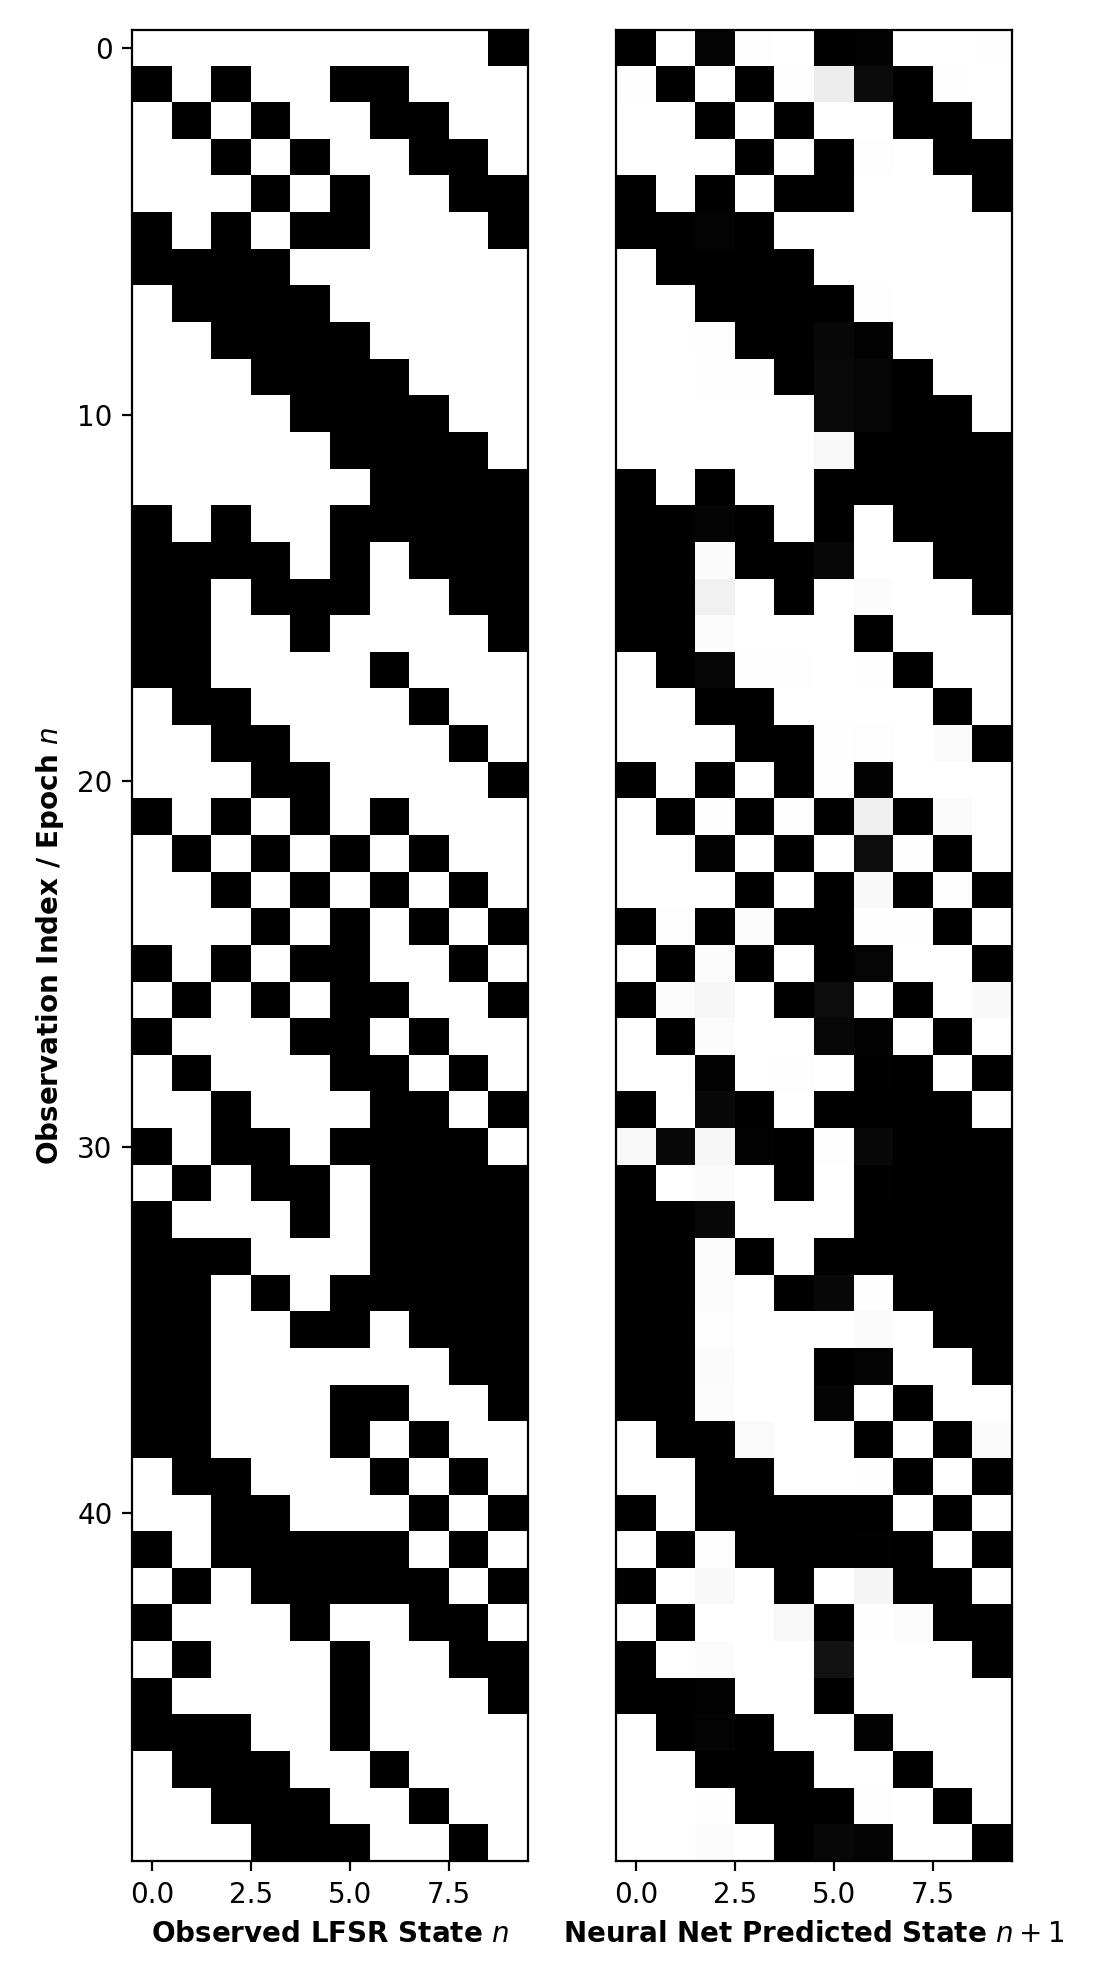

In [10]:
# Plot true n'th vs. predicted (n + 1)'st'...
if plot_prediction_masks:
    
    # Plot LFSR state progression & predicted progression (in parallel)
    true_vs_predicted_masks(idx0=0, idx1=50, input_obs=X,
                            output_activations=output_activations)

### $\textbf{Visualize Convergence of Metrics vs. Training Epoch}$

### $\textbf{Visualize LFSR State and Feedforward Binary Network}$

<IPython.core.display.Javascript object>


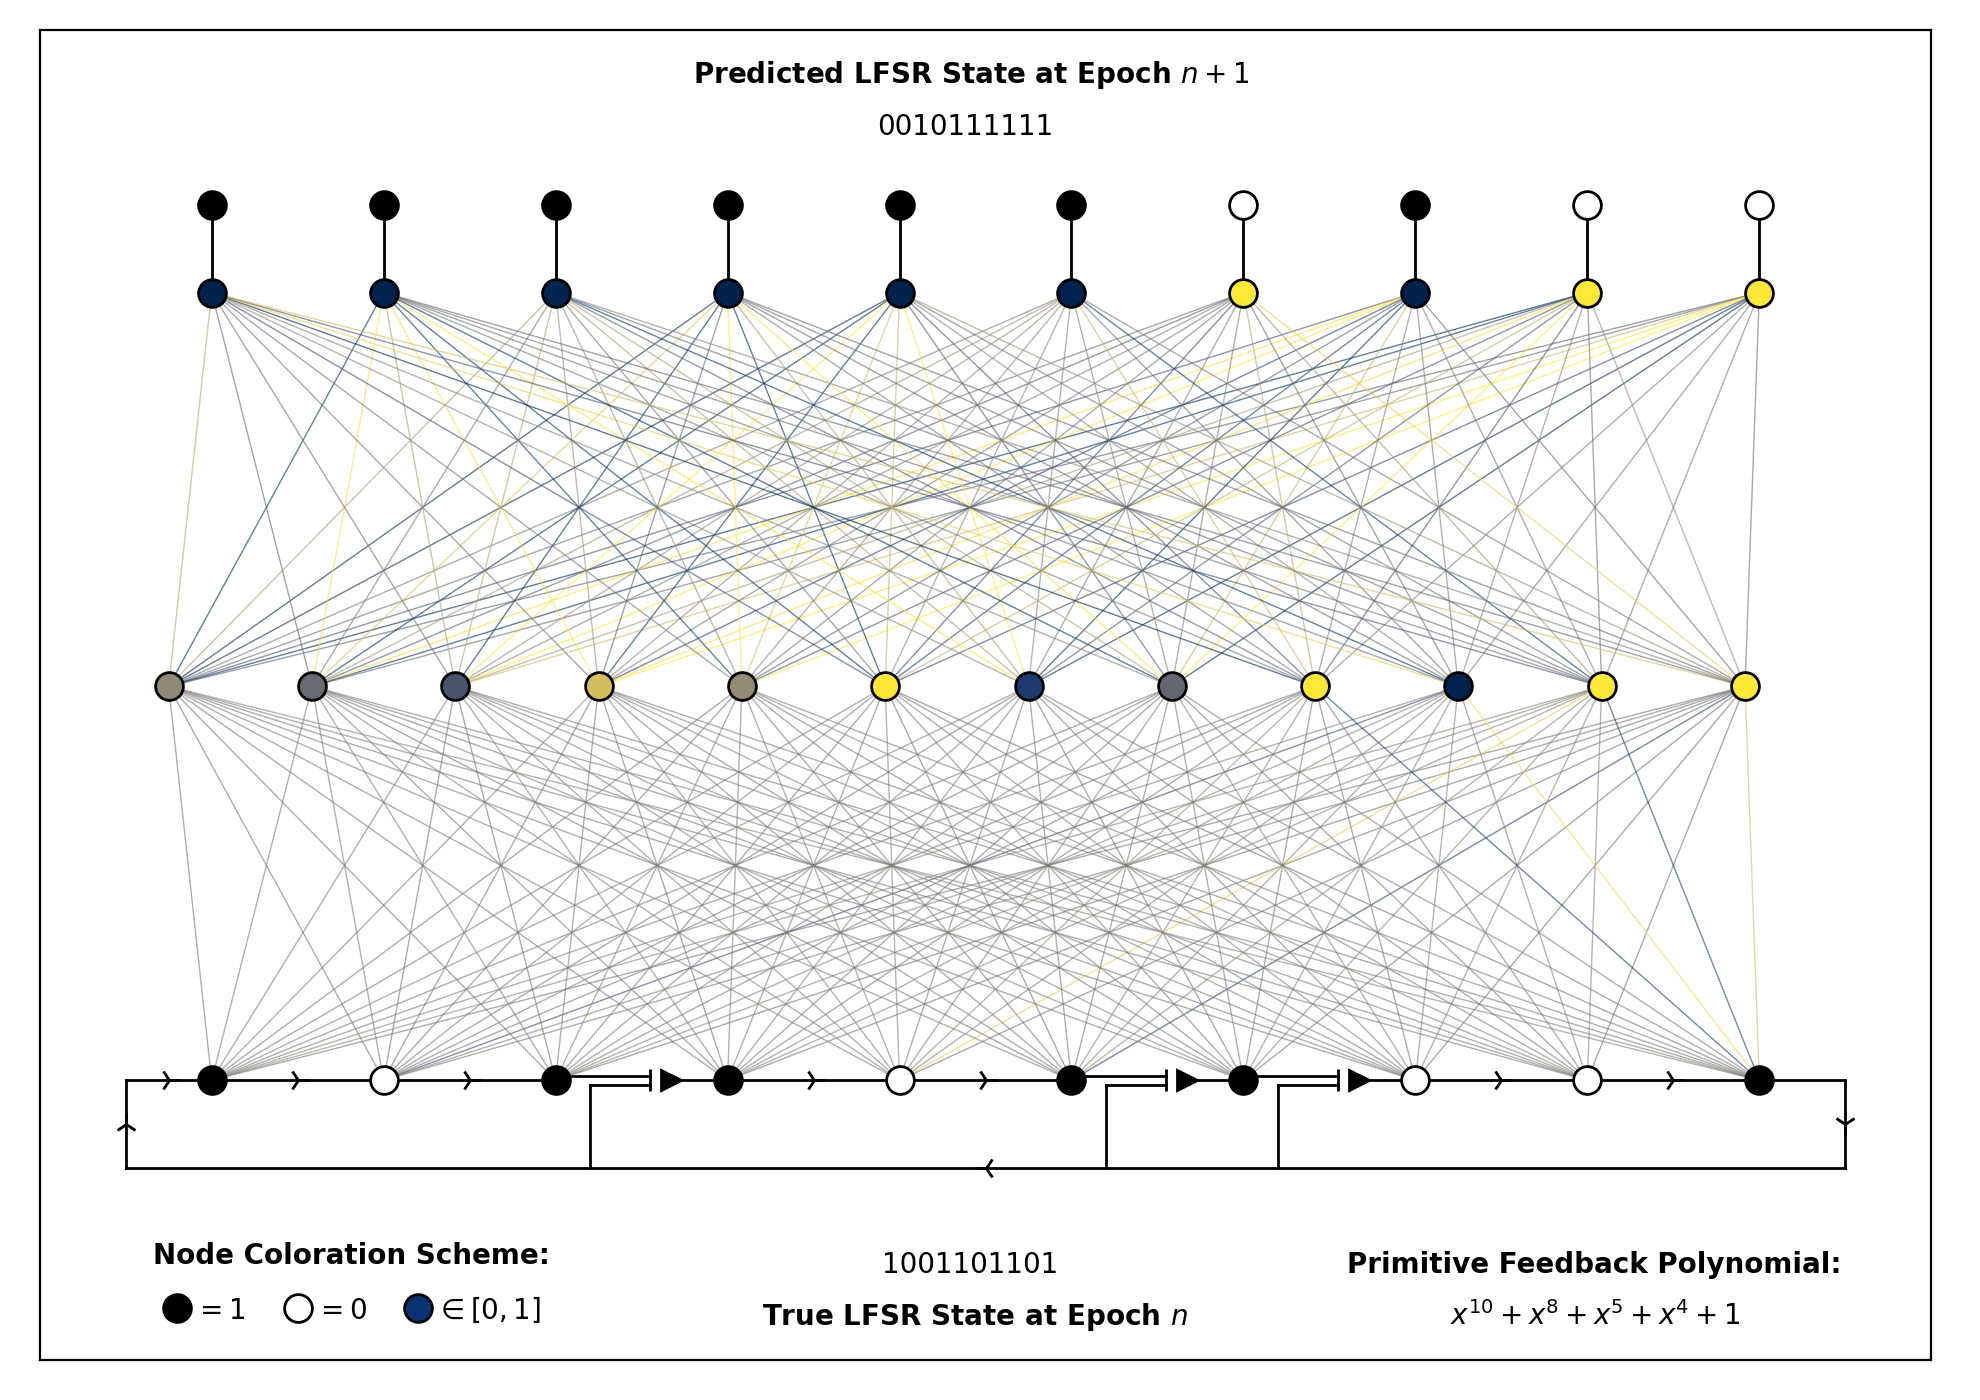

In [11]:
##############################
# Visualization config panel #
##############################

config = {
    'figsize': (9.9, 7),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'cividis',
    'y_input': 0,
    'y_hidden': 0.45,
    'y_output': 0.9,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'ylim': [-0.32, 1.2],
    'num_hidden': deg + 2,
    'num_input': deg,
    'num_output': deg,
    'node_size': 10,
    'link_width': 1,
    'net_link_alpha': 0.6,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

lfsr_prediction_animation(
    lfsr=LFSRs[p], config=config, model=model,
    state_sequence=X, hidden_activations=hidden_activations,
    output_activations=output_activations,
    run_animation=True, interval=1000, blit=True, repeat=True)